Import packages and navigate to model data directory

In [2]:
# Import packages
import os
import emc2
import xarray as xr
import pandas as pd
import numpy as np
from emc2.core import Instrument
from emc2.core.instrument import ureg
import matplotlib.pyplot as plt
import matplotlib as mpl
from datetime import datetime, timedelta
import netCDF4 as nc

# Navigate to the UM_reg data directory
os.chdir('/g/data3/jk72/slf563/UM_reg/output/db930/Mawson_resn_1_RAL3p2')
# Check current project directory
print("Project directory:", os.getcwd())

Project directory: /g/data/jk72/slf563/UM_reg/output/db930/Mawson_resn_1_RAL3p2


# File saving

NB: IF OUTPUT FILES HAVE ALREADY BEEN CREATED, PROCEED TO PLOTTING STEP

Load MARCUS coordinate data

In [2]:
# Load data and reformat as datetime64
marcus_coordinates_v3_filtered = pd.read_csv('/g/data/jk72/ck4840/projects/emc2/data/marcus_coordinates/marcus_coordinates_v3_1min_filtered.csv')
marcus_coordinates_v3_filtered['datetime_day'] = pd.to_datetime(marcus_coordinates_v3_filtered['datetime_day'])

# Filter the data based on the following datetime conditions
start_date = '2018-02-01'
end_date = '2018-02-07'
mask = (marcus_coordinates_v3_filtered['datetime_day'] >= start_date) & (marcus_coordinates_v3_filtered['datetime_day'] <= end_date)
marcus_coordinates = marcus_coordinates_v3_filtered[mask]

# Convert MARCUS coordinate data to XArray dataset and convert datetime_hour variable to a coordinate
marcus_coordinates = xr.Dataset.from_dataframe(marcus_coordinates)
marcus_coordinates = marcus_coordinates.set_coords(['datetime_1min'])

# Convert MARCUS coordinates to UM model coordinates centred on lat = -67.5 south, lon =  62.5
marcus_coordinates['latitude'] = marcus_coordinates['latitude'] + 67.5
marcus_coordinates['longitude'] = marcus_coordinates['longitude'] + 117.5

marcus_coordinates

<xarray.Dataset>
Dimensions:        (index: 1008)
Coordinates:
  * index          (index) int64 2304 2305 2306 2307 ... 3308 3309 3310 3311
    datetime_1min  (index) object '2018-02-01 00:01:00' ... '2018-02-07 23:51...
Data variables:
    longitude      (index) float64 180.6 180.5 180.5 180.5 ... 180.3 180.3 180.3
    latitude       (index) float64 0.2672 0.2614 0.2563 ... -0.0631 -0.0639
    voyage_id      (index) int64 3 3 3 3 3 3 3 3 3 3 3 ... 3 3 3 3 3 3 3 3 3 3 3
    datetime_day   (index) datetime64[ns] 2018-02-01 2018-02-01 ... 2018-02-07

Create the list of output files

In [3]:
# Create the list of file paths

# Initialise the empty list
UM_reg_list = []
# Walk through the directory tree and search for 'emcc' in filenames
for root, dirs, files in os.walk(os.getcwd()):
    for filename in files:
        # Check if the filename contains 'emcc'
        if 'emcc' in filename:
            # If 'emcc' is present, create the full file path and append it to the list
            file_path = os.path.join(root, filename)
            UM_reg_list.append(file_path)

# Arrange the list by file date
# Define a function to extract the date from the file path
def extract_date(path):
    # Split the path by '/'
    path_split = path.split('/')
    # Get the part containing the date (e.g. '20180202T1200Z')
    date_part = next(part for part in path_split if part.startswith('20'))
    # Extract and return the date portion (e.g., '20180202')
    return date_part[:8]
# Define a function to extract the numeric part of the filename
def extract_numeric_filename(filename):
    return int(filename.split('_')[-1].split('.')[0][5:]) # Extract the numeric part and convert to integer
# Sort UM_reg_list based on the extracted date and numeric part of the filename
UM_reg_list = sorted(
    UM_reg_list,
    key = lambda path: (extract_date(path), extract_numeric_filename(os.path.basename(path)))
)

# Display the sorted list
UM_reg_list

['/g/data/jk72/slf563/UM_reg/output/db930/Mawson_resn_1_RAL3p2/20180131T1200Z/umnsaa_pemcc000.nc',
 '/g/data/jk72/slf563/UM_reg/output/db930/Mawson_resn_1_RAL3p2/20180131T1200Z/umnsaa_pemcc012.nc',
 '/g/data/jk72/slf563/UM_reg/output/db930/Mawson_resn_1_RAL3p2/20180131T1200Z/umnsaa_pemcc024.nc',
 '/g/data/jk72/slf563/UM_reg/output/db930/Mawson_resn_1_RAL3p2/20180201T1200Z/umnsaa_pemcc000.nc',
 '/g/data/jk72/slf563/UM_reg/output/db930/Mawson_resn_1_RAL3p2/20180201T1200Z/umnsaa_pemcc012.nc',
 '/g/data/jk72/slf563/UM_reg/output/db930/Mawson_resn_1_RAL3p2/20180201T1200Z/umnsaa_pemcc024.nc',
 '/g/data/jk72/slf563/UM_reg/output/db930/Mawson_resn_1_RAL3p2/20180202T1200Z/umnsaa_pemcc000.nc',
 '/g/data/jk72/slf563/UM_reg/output/db930/Mawson_resn_1_RAL3p2/20180202T1200Z/umnsaa_pemcc012.nc',
 '/g/data/jk72/slf563/UM_reg/output/db930/Mawson_resn_1_RAL3p2/20180202T1200Z/umnsaa_pemcc024.nc',
 '/g/data/jk72/slf563/UM_reg/output/db930/Mawson_resn_1_RAL3p2/20180203T1200Z/umnsaa_pemcc000.nc',
 '/g/data/

Check UM_reg lat, lon, and time extrema

In [4]:
# Initialise empty lists
lat_min = []
lat_max = []
lon_min = []
lon_max = []
time_min = []
time_max = []

# Iterate across all files to retrieve the coordinate extrema
for current_file in UM_reg_list:
    UM_reg_output = xr.open_dataset(current_file)
    lat_min.append(min(UM_reg_output['lat'].values))
    lat_max.append(max(UM_reg_output['lat'].values))
    lon_min.append(min(UM_reg_output['lon'].values))
    lon_max.append(max(UM_reg_output['lon'].values))
    time_min.append(min(UM_reg_output['time'].values))
    time_max.append(max(UM_reg_output['time'].values))

# Calculate dataset durations in hours

# Convert lists to numpy arrays
time_max_array = np.array(time_max)
time_min_array = np.array(time_min)
# Calculate durations for each pair of timestamps
duration = (time_max_array - time_min_array) / np.timedelta64(1, 'h')

# Create superordinate list containing relevant information
from datetime import datetime
duration_rounded = np.round(duration)
time_min_datetime = [np.datetime_as_string(ts, unit='s') for ts in time_min]
time_max_datetime = [np.datetime_as_string(ts, unit='s') for ts in time_max]
formatted_time_min = [datetime.strptime(ts, '%Y-%m-%dT%H:%M:%S').strftime('%Y-%m-%d %H:%M:%S') for ts in time_min_datetime]
formatted_time_max = [datetime.strptime(ts, '%Y-%m-%dT%H:%M:%S').strftime('%Y-%m-%d %H:%M:%S') for ts in time_max_datetime]
# UM_reg_list, time_min, time_max, duration
UM_reg_list_super = list(zip(UM_reg_list,
                             formatted_time_min,
                             formatted_time_max,
                             duration_rounded))

# Print filepaths, datetime extrema, and duration in hours
for row in UM_reg_list_super:
    print(row)

('/g/data/jk72/slf563/UM_reg/output/db930/Mawson_resn_1_RAL3p2/20180131T1200Z/umnsaa_pemcc000.nc', '2018-01-31 12:01:00', '2018-01-31 23:51:00', 12.0)
('/g/data/jk72/slf563/UM_reg/output/db930/Mawson_resn_1_RAL3p2/20180131T1200Z/umnsaa_pemcc012.nc', '2018-02-01 00:01:00', '2018-02-01 11:51:00', 12.0)
('/g/data/jk72/slf563/UM_reg/output/db930/Mawson_resn_1_RAL3p2/20180131T1200Z/umnsaa_pemcc024.nc', '2018-02-01 12:01:00', '2018-02-01 23:51:00', 12.0)
('/g/data/jk72/slf563/UM_reg/output/db930/Mawson_resn_1_RAL3p2/20180201T1200Z/umnsaa_pemcc000.nc', '2018-02-01 12:01:00', '2018-02-01 23:51:00', 12.0)
('/g/data/jk72/slf563/UM_reg/output/db930/Mawson_resn_1_RAL3p2/20180201T1200Z/umnsaa_pemcc012.nc', '2018-02-02 00:01:00', '2018-02-02 11:51:00', 12.0)
('/g/data/jk72/slf563/UM_reg/output/db930/Mawson_resn_1_RAL3p2/20180201T1200Z/umnsaa_pemcc024.nc', '2018-02-02 12:01:00', '2018-02-02 23:51:00', 12.0)
('/g/data/jk72/slf563/UM_reg/output/db930/Mawson_resn_1_RAL3p2/20180202T1200Z/umnsaa_pemcc000.

File treatment protocol based on time extrema and duration

In [5]:
# Each day has three parts: a 12hr spin-up from the previous day, the first 12hrs, and the second 12hrs
# We wnt to discard the 12hr spin-up only, and this requires excluding umnsaa_pemcc000 files
UM_reg_list_final = [s for s in UM_reg_list if 'umnsaa_pemcc000' not in s]
UM_reg_list_final

['/g/data/jk72/slf563/UM_reg/output/db930/Mawson_resn_1_RAL3p2/20180131T1200Z/umnsaa_pemcc012.nc',
 '/g/data/jk72/slf563/UM_reg/output/db930/Mawson_resn_1_RAL3p2/20180131T1200Z/umnsaa_pemcc024.nc',
 '/g/data/jk72/slf563/UM_reg/output/db930/Mawson_resn_1_RAL3p2/20180201T1200Z/umnsaa_pemcc012.nc',
 '/g/data/jk72/slf563/UM_reg/output/db930/Mawson_resn_1_RAL3p2/20180201T1200Z/umnsaa_pemcc024.nc',
 '/g/data/jk72/slf563/UM_reg/output/db930/Mawson_resn_1_RAL3p2/20180202T1200Z/umnsaa_pemcc012.nc',
 '/g/data/jk72/slf563/UM_reg/output/db930/Mawson_resn_1_RAL3p2/20180202T1200Z/umnsaa_pemcc024.nc',
 '/g/data/jk72/slf563/UM_reg/output/db930/Mawson_resn_1_RAL3p2/20180203T1200Z/umnsaa_pemcc012.nc',
 '/g/data/jk72/slf563/UM_reg/output/db930/Mawson_resn_1_RAL3p2/20180203T1200Z/umnsaa_pemcc024.nc',
 '/g/data/jk72/slf563/UM_reg/output/db930/Mawson_resn_1_RAL3p2/20180204T1200Z/umnsaa_pemcc012.nc',
 '/g/data/jk72/slf563/UM_reg/output/db930/Mawson_resn_1_RAL3p2/20180204T1200Z/umnsaa_pemcc024.nc',
 '/g/data/

Extract the parent folder names

In [6]:
# Initialise the empty parent folder list
parent_folders_list = []

# Iterate over UM_reg_list_final to extract the previous date
for file_path in UM_reg_list_final:
    path_parts = file_path.split('/')
    parent_folder = path_parts[-2]
    parent_folders_list.append(parent_folder)

print(parent_folders_list)
print(np.unique(parent_folders_list))

['20180131T1200Z', '20180131T1200Z', '20180201T1200Z', '20180201T1200Z', '20180202T1200Z', '20180202T1200Z', '20180203T1200Z', '20180203T1200Z', '20180204T1200Z', '20180204T1200Z', '20180205T1200Z', '20180205T1200Z', '20180206T1200Z', '20180206T1200Z', '20180207T1200Z', '20180207T1200Z']
['20180131T1200Z' '20180201T1200Z' '20180202T1200Z' '20180203T1200Z'
 '20180204T1200Z' '20180205T1200Z' '20180206T1200Z' '20180207T1200Z']


Save the data as daily files

In [13]:
# Extract unique parent folder names, excluding data beyond 2018-02-07
unique_parent_folders_list = np.unique(parent_folders_list)[0:7]

# TEST ON ONE DAY ONLY
# unique_parent_folders_list = np.unique(parent_folders_list)[0:1]
# unique_parent_folders_list = [np.unique(parent_folders_list)[0]]
# unique_parent_folders_list = [np.unique(parent_folders_list)[3]]

# Load the files in pairs, concatenate, add additional variables, and re-save as daily files
for parent_folder in unique_parent_folders_list:
    
    # Create file paths
    file_path_p1 = f'/g/data/jk72/slf563/UM_reg/output/db930/Mawson_resn_1_RAL3p2/{parent_folder}/umnsaa_pemcc012.nc'
    file_path_p2 = f'/g/data/jk72/slf563/UM_reg/output/db930/Mawson_resn_1_RAL3p2/{parent_folder}/umnsaa_pemcc024.nc'
    
    # Extract date from parent folder
    current_date = datetime.strptime(parent_folder.split('T')[0], '%Y%m%d') + timedelta(days = 1)
    current_date_str = current_date.strftime('%Y%m%d')
    current_date_precise_str = current_date.strftime('%Y-%m-%d %H:%M:%S')
    
    # Load UM_reg model datasets and filter to current date
    UM_reg_output_p1 = xr.open_dataset(file_path_p1)
    UM_reg_output_p1 = UM_reg_output_p1.sel(time = slice(current_date, None))
    UM_reg_output_p2 = xr.open_dataset(file_path_p2)
    UM_reg_output_p2 = UM_reg_output_p2.sel(time = slice(current_date, None))

    # Extract the time values from the UM_reg model data
    time_values_p1 = pd.to_datetime(UM_reg_output_p1['time']).round('1min')
    time_dataset_p1 = xr.Dataset({'time': time_values_p1})
    time_values_p2 = pd.to_datetime(UM_reg_output_p2['time']).round('1min')
    time_dataset_p2 = xr.Dataset({'time': time_values_p2})

    # Subset marcus_coordinates to the current_date
    current_date_np = np.datetime64(current_date_precise_str)
    marcus_coordinates_current = marcus_coordinates.where(marcus_coordinates['datetime_day'] == current_date_np, drop=True)
    marcus_coordinates_current_p1 = marcus_coordinates_current.isel(index=slice(0,72))
    marcus_coordinates_current_p2 = marcus_coordinates_current.isel(index=slice(72,144))

    # Initialize lists to store latitudes and longitudes
    lat_values_p1 = []
    lon_values_p1 = []
    lat_values_p2 = []
    lon_values_p2 = []
    
    # Initalise list to store the individual datasets from each iteration
    list_of_datasets_p1 = []
    list_of_datasets_p2 = []
    
    # Loop over each time step in the ship dataset
    # P1
    for i in range(len(time_values_p1)):
        # Get the lat, lon, and time values for each step
        lat = marcus_coordinates_current_p1['latitude'].isel(index=i)
        lon = marcus_coordinates_current_p1['longitude'].isel(index=i)
        time = marcus_coordinates_current_p1['datetime_1min'].isel(index=i)
    
        # Extract the current lat and lon values
        lat_values_p1.append(lat - 67.5)
        lon_values_p1.append(lon - 117.5)
        
        # Interpolating the entire dataset at the ship's position
        UM_reg_output_p1_interpolated = UM_reg_output_p1.interp(
            lat=lat.item(),
            lon=lon.item(),
            time=time_values_p1[i],
            method='nearest'
        )
    
        # Drop the old latitude and longitude variables
        UM_reg_output_p1_interpolated = UM_reg_output_p1_interpolated.drop_vars('lat')
        UM_reg_output_p1_interpolated = UM_reg_output_p1_interpolated.drop_vars('lon')
        
        # Append each interpolated dataset to the list
        list_of_datasets_p1.append(UM_reg_output_p1_interpolated)
    # P1
    for i in range(len(time_values_p2)):
        # Get the lat, lon, and time values for each step
        lat = marcus_coordinates_current_p2['latitude'].isel(index=i)
        lon = marcus_coordinates_current_p2['longitude'].isel(index=i)
        time = marcus_coordinates_current_p2['datetime_1min'].isel(index=i)
    
        # Extract the current lat and lon values
        lat_values_p2.append(lat - 67.5)
        lon_values_p2.append(lon - 117.5)
        
        # Interpolating the entire dataset at the ship's position
        UM_reg_output_p2_interpolated = UM_reg_output_p2.interp(
            lat=lat.item(),
            lon=lon.item(),
            time=time_values_p2[i],
            method='nearest'
        )
    
        # Drop the old latitude and longitude variables
        UM_reg_output_p2_interpolated = UM_reg_output_p2_interpolated.drop_vars('lat')
        UM_reg_output_p2_interpolated = UM_reg_output_p2_interpolated.drop_vars('lon')
        
        # Append each interpolated dataset to the list
        list_of_datasets_p2.append(UM_reg_output_p2_interpolated)

    # Concatenate all datasets along the 'time' dimension
    UM_reg_output_p1_subset = xr.combine_nested(list_of_datasets_p1, concat_dim='time')
    UM_reg_output_p2_subset = xr.combine_nested(list_of_datasets_p2, concat_dim='time')
    
    # Add latitudes and longitudes as variables
    lat_values_p1 = xr.DataArray(data=lat_values_p1, dims='dim_name')
    lon_values_p1 = xr.DataArray(data=lon_values_p1, dims='dim_name')
    UM_reg_output_p1_subset['lat'] = ('time', lat_values_p1.data)
    UM_reg_output_p1_subset['lon'] = ('time', lon_values_p1.data)
    lat_values_p2 = xr.DataArray(data=lat_values_p2, dims='dim_name')
    lon_values_p2 = xr.DataArray(data=lon_values_p2, dims='dim_name')
    UM_reg_output_p2_subset['lat'] = ('time', lat_values_p2.data)
    UM_reg_output_p2_subset['lon'] = ('time', lon_values_p2.data)

    # Concatenate both parts
    UM_reg_output_subset = xr.concat([UM_reg_output_p1_subset, UM_reg_output_p2_subset], dim = 'time')

    # # ASSUMING THE UNITS OF THE NUMBER MIXING RATIO FIELDS ARE PARTICLES PER KILOGRAM OF SPECIES
    # # NOT CURRENTLY IN USE
    # # Calculate particle number mixing ratio in particles per cubic metre for each of the five species
    # # Nc,air = Nc,ice * Qc,ice * rhoa
    # ncl = UM_reg_output_subset.field75 * UM_reg_output_subset.field254 * UM_reg_output_subset.field408/(287.052874 * UM_reg_output_subset.ta)
    # ncf = UM_reg_output_subset.field78 * UM_reg_output_subset.field271 * UM_reg_output_subset.field408/(287.052874 * UM_reg_output_subset.ta)
    # npl = UM_reg_output_subset.field76 * UM_reg_output_subset.field272 * UM_reg_output_subset.field408/(287.052874 * UM_reg_output_subset.ta)
    # npf = UM_reg_output_subset.field79 * UM_reg_output_subset.field12 * UM_reg_output_subset.field408/(287.052874 * UM_reg_output_subset.ta)
    # npg = UM_reg_output_subset.field81 * UM_reg_output_subset.field273 * UM_reg_output_subset.field408/(287.052874 * UM_reg_output_subset.ta)
    # # Add particle effective radius for each of the four species to the dataset
    # UM_reg_output_subset['ncl'] = xr.DataArray(data = ncl,dims = ('time','z0_hybrid_height'))
    # UM_reg_output_subset['ncf'] = xr.DataArray(data = ncf,dims = ('time','z0_hybrid_height'))
    # UM_reg_output_subset['npl'] = xr.DataArray(data = npl,dims = ('time','z0_hybrid_height'))
    # UM_reg_output_subset['npf'] = xr.DataArray(data = npf,dims = ('time','z0_hybrid_height'))
    # UM_reg_output_subset['npg'] = xr.DataArray(data = npg,dims = ('time','z0_hybrid_height'))
    # # Replace effective radius nans with zeros
    # UM_reg_output_subset['ncl'] = UM_reg_output_subset['ncl'].fillna(0)
    # UM_reg_output_subset['ncf'] = UM_reg_output_subset['ncf'].fillna(0)
    # UM_reg_output_subset['npl'] = UM_reg_output_subset['npl'].fillna(0)
    # UM_reg_output_subset['npf'] = UM_reg_output_subset['npf'].fillna(0)
    # UM_reg_output_subset['npg'] = UM_reg_output_subset['npf'].fillna(0)
    # # Replace effective radius inf with zeros
    # UM_reg_output_subset['ncl'] = xr.where(np.isinf(UM_reg_output_subset['ncl']), 0, UM_reg_output_subset['ncl'])
    # UM_reg_output_subset['ncf'] = xr.where(np.isinf(UM_reg_output_subset['ncf']), 0, UM_reg_output_subset['ncf'])
    # UM_reg_output_subset['npl'] = xr.where(np.isinf(UM_reg_output_subset['npl']), 0, UM_reg_output_subset['npl'])
    # UM_reg_output_subset['npf'] = xr.where(np.isinf(UM_reg_output_subset['npf']), 0, UM_reg_output_subset['npf'])
    # UM_reg_output_subset['npg'] = xr.where(np.isinf(UM_reg_output_subset['npg']), 0, UM_reg_output_subset['npg'])
    
    # Calculate particle effective radius for each of the four species
    rcl = ((((UM_reg_output_subset.field254/UM_reg_output_subset.field75)/1000)*3)/(4*np.pi))**(1./3)
    rci = ((((UM_reg_output_subset.field271/UM_reg_output_subset.field78)/500)*3)/(4*np.pi))**(1./3)
    rpl = ((((UM_reg_output_subset.field272/UM_reg_output_subset.field76)/1000)*3)/(4*np.pi))**(1./3)
    rpi = ((((UM_reg_output_subset.field12/UM_reg_output_subset.field79)/250)*3)/(4*np.pi))**(1./3)
    rpg = ((((UM_reg_output_subset.field273/UM_reg_output_subset.field81)/250)*3)/(4*np.pi))**(1./3)
    # Add particle effective radius for each of the four species to the dataset
    UM_reg_output_subset['re_mccl'] = xr.DataArray(data = rcl,dims = ('time','z0_hybrid_height'))
    UM_reg_output_subset['re_mcci'] = xr.DataArray(data = rci,dims = ('time','z0_hybrid_height'))
    UM_reg_output_subset['re_mcpl'] = xr.DataArray(data = rpl,dims = ('time','z0_hybrid_height'))
    UM_reg_output_subset['re_mcpi'] = xr.DataArray(data = rpi,dims = ('time','z0_hybrid_height'))
    UM_reg_output_subset['re_mcpg'] = xr.DataArray(data = rpg,dims = ('time','z0_hybrid_height'))
    # Replace effective radius nans with zeros
    UM_reg_output_subset['re_mccl'] = UM_reg_output_subset['re_mccl'].fillna(0)
    UM_reg_output_subset['re_mcci'] = UM_reg_output_subset['re_mcci'].fillna(0)
    UM_reg_output_subset['re_mcpl'] = UM_reg_output_subset['re_mcpl'].fillna(0)
    UM_reg_output_subset['re_mcpi'] = UM_reg_output_subset['re_mcpi'].fillna(0)
    UM_reg_output_subset['re_mcpg'] = UM_reg_output_subset['re_mcpg'].fillna(0)
    # Replace effective radius inf with zeros
    UM_reg_output_subset['re_mccl'] = xr.where(np.isinf(UM_reg_output_subset['re_mccl']), 0, UM_reg_output_subset['re_mccl'])
    UM_reg_output_subset['re_mcci'] = xr.where(np.isinf(UM_reg_output_subset['re_mcci']), 0, UM_reg_output_subset['re_mcci'])
    UM_reg_output_subset['re_mcpl'] = xr.where(np.isinf(UM_reg_output_subset['re_mcpl']), 0, UM_reg_output_subset['re_mcpl'])
    UM_reg_output_subset['re_mcpi'] = xr.where(np.isinf(UM_reg_output_subset['re_mcpi']), 0, UM_reg_output_subset['re_mcpi'])
    UM_reg_output_subset['re_mcpg'] = xr.where(np.isinf(UM_reg_output_subset['re_mcpg']), 0, UM_reg_output_subset['re_mcpg'])

    # Create a dataset filled with zeros
    zeros_data = xr.DataArray(
        data = np.zeros((len(UM_reg_output_subset['time']), len(UM_reg_output_subset['z0_hybrid_height']))),
        dims = ('time', 'z0_hybrid_height'),
        coords = {'time': UM_reg_output_subset['time'], 'z0_hybrid_height': UM_reg_output_subset['z0_hybrid_height']}
    )
    UM_reg_output_subset['zeros_var'] = zeros_data

    # Add a 2-dimensional z_values variable to the data subset
    z0_values = UM_reg_output_subset['z0_hybrid_height'].values
    z_values = z0_values[:, np.newaxis] * np.ones(len(UM_reg_output_subset['time']))
    UM_reg_output_subset['z'] = (('z0_hybrid_height', 'time'), z_values)
    UM_reg_output_subset['z'].attrs['units'] = 'meter'
    UM_reg_output_subset['z'] = UM_reg_output_subset['z'].transpose('time', 'z0_hybrid_height')
    
    # Add units to all fields
    # Mass mixing ratio
    UM_reg_output_subset['field254'] = UM_reg_output_subset['field254'].assign_attrs(units=ureg.kg/ureg.kg)
    UM_reg_output_subset['field254'].attrs['units'] = str(UM_reg_output_subset['field254'].attrs['units'])
    UM_reg_output_subset['field271'] = UM_reg_output_subset['field271'].assign_attrs(units=ureg.kg/ureg.kg)
    UM_reg_output_subset['field271'].attrs['units'] = str(UM_reg_output_subset['field271'].attrs['units'])
    UM_reg_output_subset['field272'] = UM_reg_output_subset['field272'].assign_attrs(units=ureg.kg/ureg.kg)
    UM_reg_output_subset['field272'].attrs['units'] = str(UM_reg_output_subset['field272'].attrs['units'])
    UM_reg_output_subset['field12'] = UM_reg_output_subset['field12'].assign_attrs(units=ureg.kg/ureg.kg)
    UM_reg_output_subset['field12'].attrs['units'] = str(UM_reg_output_subset['field12'].attrs['units'])
    UM_reg_output_subset['field273'] = UM_reg_output_subset['field273'].assign_attrs(units=ureg.kg/ureg.kg)
    UM_reg_output_subset['field273'].attrs['units'] = str(UM_reg_output_subset['field273'].attrs['units'])
    # Number concentration
    UM_reg_output_subset['field75'] = UM_reg_output_subset['field75'].assign_attrs(units=ureg.meter**(-3))
    UM_reg_output_subset['field75'].attrs['units'] = str(UM_reg_output_subset['field75'].attrs['units'])
    UM_reg_output_subset['field78'] = UM_reg_output_subset['field78'].assign_attrs(units=ureg.meter**(-3))
    UM_reg_output_subset['field78'].attrs['units'] = str(UM_reg_output_subset['field78'].attrs['units'])
    UM_reg_output_subset['field76'] = UM_reg_output_subset['field76'].assign_attrs(units=ureg.meter**(-3))
    UM_reg_output_subset['field76'].attrs['units'] = str(UM_reg_output_subset['field76'].attrs['units'])
    UM_reg_output_subset['field79'] = UM_reg_output_subset['field79'].assign_attrs(units=ureg.meter**(-3))
    UM_reg_output_subset['field79'].attrs['units'] = str(UM_reg_output_subset['field79'].attrs['units'])
    UM_reg_output_subset['field81'] = UM_reg_output_subset['field81'].assign_attrs(units=ureg.meter**(-3))
    UM_reg_output_subset['field81'].attrs['units'] = str(UM_reg_output_subset['field81'].attrs['units'])
    # # Number concentration from custom calculations
    # UM_reg_output_subset['ncl'] = UM_reg_output_subset['ncl'].assign_attrs(units=ureg.meter**(-3))
    # UM_reg_output_subset['ncl'].attrs['units'] = str(UM_reg_output_subset['ncl'].attrs['units'])
    # UM_reg_output_subset['ncf'] = UM_reg_output_subset['ncf'].assign_attrs(units=ureg.meter**(-3))
    # UM_reg_output_subset['ncf'].attrs['units'] = str(UM_reg_output_subset['ncf'].attrs['units'])
    # UM_reg_output_subset['npl'] = UM_reg_output_subset['npl'].assign_attrs(units=ureg.meter**(-3))
    # UM_reg_output_subset['npl'].attrs['units'] = str(UM_reg_output_subset['npl'].attrs['units'])
    # UM_reg_output_subset['npf'] = UM_reg_output_subset['npf'].assign_attrs(units=ureg.meter**(-3))
    # UM_reg_output_subset['npf'].attrs['units'] = str(UM_reg_output_subset['npf'].attrs['units'])
    # UM_reg_output_subset['npg'] = UM_reg_output_subset['npg'].assign_attrs(units=ureg.meter**(-3))
    # UM_reg_output_subset['npg'].attrs['units'] = str(UM_reg_output_subset['npg'].attrs['units'])
    
    # Stratiform fraction
    UM_reg_output_subset['field267'] = UM_reg_output_subset['field267'].assign_attrs(units=ureg.meter/ureg.meter)
    UM_reg_output_subset['field267'].attrs['units'] = str(UM_reg_output_subset['field267'].attrs['units'])
    UM_reg_output_subset['field268'] = UM_reg_output_subset['field268'].assign_attrs(units=ureg.meter/ureg.meter)
    UM_reg_output_subset['field268'].attrs['units'] = str(UM_reg_output_subset['field268'].attrs['units'])
    # Effective radius
    UM_reg_output_subset['re_mccl'] = UM_reg_output_subset['re_mccl'].assign_attrs(units=ureg.meter)
    UM_reg_output_subset['re_mccl'].attrs['units'] = str(UM_reg_output_subset['re_mccl'].attrs['units'])
    UM_reg_output_subset['re_mcci'] = UM_reg_output_subset['re_mcci'].assign_attrs(units=ureg.meter)
    UM_reg_output_subset['re_mcci'].attrs['units'] = str(UM_reg_output_subset['re_mcci'].attrs['units'])
    UM_reg_output_subset['re_mcpl'] = UM_reg_output_subset['re_mcpl'].assign_attrs(units=ureg.meter)
    UM_reg_output_subset['re_mcpl'].attrs['units'] = str(UM_reg_output_subset['re_mcpl'].attrs['units'])
    UM_reg_output_subset['re_mcpi'] = UM_reg_output_subset['re_mcpi'].assign_attrs(units=ureg.meter)
    UM_reg_output_subset['re_mcpi'].attrs['units'] = str(UM_reg_output_subset['re_mcpi'].attrs['units'])
    UM_reg_output_subset['re_mcpg'] = UM_reg_output_subset['re_mcpg'].assign_attrs(units=ureg.meter)
    UM_reg_output_subset['re_mcpg'].attrs['units'] = str(UM_reg_output_subset['re_mcpg'].attrs['units'])
    # Water vapour mixing ratio
    UM_reg_output_subset['hus'] = UM_reg_output_subset['hus'].assign_attrs(units=ureg.kg/ureg.kg)
    UM_reg_output_subset['hus'].attrs['units'] = str(UM_reg_output_subset['hus'].attrs['units'])
    # Pressure
    UM_reg_output_subset['field408'] = UM_reg_output_subset['field408'].assign_attrs(units=ureg.pascal)
    UM_reg_output_subset['field408'].attrs['units'] = str(UM_reg_output_subset['field408'].attrs['units'])
    # Temperature
    UM_reg_output_subset['ta'] = UM_reg_output_subset['ta'].assign_attrs(units=ureg.kelvin)
    UM_reg_output_subset['ta'].attrs['units'] = str(UM_reg_output_subset['ta'].attrs['units'])
    # Height
    # No need to reassign units to custom height array
    # UM_reg_output_subset['z'] = UM_reg_output_subset['ta'].assign_attrs(units=ureg.kelvin)
    # UM_reg_output_subset['z'].attrs['units'] = str(UM_reg_output_subset['ta'].attrs['units'])
    # Assign units to height array - not used by EMC2
    # UM_reg_output_subset['z0_hybrid_height'] = UM_reg_output_subset['z0_hybrid_height'].assign_attrs(units=ureg.meter)
    # UM_reg_output_subset['z0_hybrid_height'].attrs['units'] = str(UM_reg_output_subset['z0_hybrid_height'].attrs['units'])
    # No need to wipe and reassign units to height array
    # UM_reg_output_subset['z0_hybrid_height'].attrs = {}
    # UM_reg_output_subset['z0_hybrid_height'] = UM_reg_output_subset['z0_hybrid_height'].assign_attrs(units=ureg.meter)
    # UM_reg_output_subset['z0_hybrid_height'].attrs['z0_hybrid_height'] = str(UM_reg_output_subset['z0_hybrid_height'].attrs['units'])

    # Now, the combined_dataset contains the interpolated values for each time step of the current day in a single dataset, along with estimated particle effective radius fields and correct units for all fields
    
    # Save the data
    file_path_output = f'/g/data/jk72/ck4840/projects/emc2/data/um_reg/um_reg_marcus_{current_date_str}.nc'
    UM_reg_output_subset.to_netcdf(file_path_output)
print('Finished saving daily files')

Finished saving daily files


# Saved file checks

In [3]:
# Create the list of full filepaths to the daily files

# Set daily file parent folder
daily_filepath = '/g/data/jk72/ck4840/projects/emc2/data/um_reg/'
# List daily files in the parent folder
daily_UM_reg_list = os.listdir(path = daily_filepath)
# Create the list of daily filepaths
daily_UM_reg_list = [os.path.join(daily_filepath, file) for file in daily_UM_reg_list]
# Sort the list by date
def extract_date(filepath):
    return filepath[12:-3]
daily_UM_reg_list = sorted(daily_UM_reg_list, key = extract_date)
daily_UM_reg_list = [path for path in daily_UM_reg_list if 'um_reg_marcus_' in path]
daily_UM_reg_list

['/g/data/jk72/ck4840/projects/emc2/data/um_reg/um_reg_marcus_20180201.nc',
 '/g/data/jk72/ck4840/projects/emc2/data/um_reg/um_reg_marcus_20180202.nc',
 '/g/data/jk72/ck4840/projects/emc2/data/um_reg/um_reg_marcus_20180203.nc',
 '/g/data/jk72/ck4840/projects/emc2/data/um_reg/um_reg_marcus_20180204.nc',
 '/g/data/jk72/ck4840/projects/emc2/data/um_reg/um_reg_marcus_20180205.nc',
 '/g/data/jk72/ck4840/projects/emc2/data/um_reg/um_reg_marcus_20180206.nc',
 '/g/data/jk72/ck4840/projects/emc2/data/um_reg/um_reg_marcus_20180207.nc']

In [62]:
np.max(test.time.values)

numpy.datetime64('2018-02-04T23:51:00.000000000')

In [29]:
test = xr.open_dataset(daily_UM_reg_list[3])

# Check maximum values and assigned units
print('Field maximum values')
print('\n')
print('Mass mixing ratio')
print('Cloud liquid:', np.max(test['field254'].values), test['field254'].attrs)
print('Cloud ice:', np.max(test['field271'].values), test['field271'].attrs)
print('Precip liquid:', np.max(test['field272'].values), test['field272'].attrs)
print('Precip ice:', np.max(test['field12'].values),test['field12'].attrs)
print('Precip graupel:', np.max(test['field273'].values),test['field273'].attrs)
print('\n')
print('Number concentration')
print('Cloud liquid, field75:', np.max(test['field75'].values), test['field75'].attrs)
print('Cloud ice:', np.max(test['field78'].values), test['field78'].attrs)
print('Precip liquid:', np.max(test['field76'].values), test['field76'].attrs)
print('Precip ice:', np.max(test['field79'].values), test['field79'].attrs)
print('Precip graupel:', np.max(test['field81'].values), test['field81'].attrs)
print('\n')
print('Stratiform fraction')
print('Cloud liquid:', np.max(test['field267'].values), test['field267'].attrs)
print('Cloud ice:', np.max(test['field268'].values), test['field268'].attrs)
print('\n')
print('Effective radius')
print('Cloud liquid:', np.max(test['re_mccl'].values), test['re_mccl'].attrs)
print('Cloud ice:', np.max(test['re_mcci'].values), test['re_mcci'].attrs)
print('Precip liquid:', np.max(test['re_mcpl'].values), test['re_mcpl'].attrs)
print('Precip ice:', np.max(test['re_mcpi'].values), test['re_mcpi'].attrs)
print('Precip graupel:', np.max(test['re_mcpg'].values), test['re_mcpg'].attrs)
print('\n')

print('Other')
print('Water vapour mixing ratio (specific humidity):', np.max(test['hus'].values), test['hus'].attrs)
print('Pressure:', np.max(test['field408'].values), test['field408'].attrs)
print('Temperature:', np.max(test['ta'].values), test['ta'].attrs)
print('Height:', np.max(test['z'].values), test['z'].attrs)

Field maximum values


Mass mixing ratio
Cloud liquid: 0.00032037497 {'units': 'dimensionless'}
Cloud ice: 2.5510788e-05 {'units': 'dimensionless'}
Precip liquid: 4.7683716e-07 {'units': 'dimensionless'}
Precip ice: 0.0002449751 {'units': 'dimensionless'}
Precip graupel: 1.1920929e-07 {'units': 'dimensionless'}


Number concentration
Cloud liquid, field75: 144703490.0 {'units': '1 / meter ** 3'}
Cloud ice: 1048576.0 {'units': '1 / meter ** 3'}
Precip liquid: 0.0 {'units': '1 / meter ** 3'}
Precip ice: 0.0 {'units': '1 / meter ** 3'}
Precip graupel: 0.0 {'units': '1 / meter ** 3'}


Stratiform fraction
Cloud liquid: 1.0 {'units': 'dimensionless'}
Cloud ice: 1.0 {'units': 'dimensionless'}


Effective radius
Cloud liquid: 8.607328e-06 {'units': 'meter'}
Cloud ice: 2.2647571e-05 {'units': 'meter'}
Precip liquid: 0.0 {'units': 'meter'}
Precip ice: 0.0 {'units': 'meter'}
Precip graupel: 0.0 {'units': 'meter'}


Other
Water vapour mixing ratio (specific humidity): 0.0028620362 {'units': 'dime

In [33]:
max_indices = np.unravel_index(test['field254'].values.argmax(), test['field254'].shape)
max_field_value = test['field254'].values[max_indices]
corresponding_field_value = test['field75'].values[max_indices]
print(f"Maximum value of QCL occurs at indices: {max_indices}")
print(f"At this point, QCL (qcl after timestep) has the value: {max_field_value}")
print(f"At this point, NCL (cloud number after timestep) has the value: {corresponding_field_value}")
print('\n')

max_indices = np.unravel_index(test['field271'].values.argmax(), test['field271'].shape)
max_field_value = test['field271'].values[max_indices]
corresponding_field_value = test['field78'].values[max_indices]
print(f"Maximum value of QCF occurs at indices: {max_indices}")
print(f"At this point, QCF (cloud ice (crystals) after timestep) has the value: {max_field_value}")
print(f"At this point, NCF (ice number after timestep) has the value: {corresponding_field_value}")
corresponding_field_value = test['field79'].values[max_indices]
print(f"At this point, NPF (snow number after timestep) has the value: {corresponding_field_value}")
print('\n')

max_indices = np.unravel_index(test['field272'].values.argmax(), test['field272'].shape)
max_field_value = test['field272'].values[max_indices]
corresponding_field_value = test['field76'].values[max_indices]
print(f"Maximum value of QPL occurs at indices: {max_indices}")
print(f"At this point, QPL (rain after timestep) has the value: {max_field_value}")
print(f"At this point, NPL (rain number after timestep) has the value: {corresponding_field_value}")
print('\n')

max_indices = np.unravel_index(test['field12'].values.argmax(), test['field12'].shape)
max_field_value = test['field12'].values[max_indices]
corresponding_field_value = test['field79'].values[max_indices]
print(f"Maximum value of QPF occurs at indices: {max_indices}")
print(f"At this point, QPF (qcf after timestep) has the value: {max_field_value}")
print(f"At this point, NPF (snow number after timestep) has the value: {corresponding_field_value}")
corresponding_field_value = test['field78'].values[max_indices]
print(f"At this point, NCF (ice number after timestep) has the value: {corresponding_field_value}")
print('\n')

max_indices = np.unravel_index(test['field273'].values.argmax(), test['field273'].shape)
max_field_value = test['field273'].values[max_indices]
corresponding_field_value = test['field81'].values[max_indices]
print(f"Maximum value of QPG occurs at indices: {max_indices}")
print(f"At this point, QPG (graupel after timestep) has the value: {max_field_value}")
print(f"At this point, NPG (graupel number after timestep) has the value: {corresponding_field_value}")

Maximum value of QCL occurs at indices: (88, 25)
At this point, QCL (qcl after timestep) has the value: 0.0003203749656677246
At this point, NCL (cloud number after timestep) has the value: 125829120.0


Maximum value of QCF occurs at indices: (85, 48)
At this point, QCF (cloud ice (crystals) after timestep) has the value: 2.5510787963867188e-05
At this point, NCF (ice number after timestep) has the value: 1048576.0
At this point, NPF (snow number after timestep) has the value: 0.0


Maximum value of QPL occurs at indices: (87, 25)
At this point, QPL (rain after timestep) has the value: 4.76837158203125e-07
At this point, NPL (rain number after timestep) has the value: 0.0


Maximum value of QPF occurs at indices: (117, 27)
At this point, QPF (qcf after timestep) has the value: 0.00024497509002685547
At this point, NPF (snow number after timestep) has the value: 0.0
At this point, NCF (ice number after timestep) has the value: 0.0


Maximum value of QPG occurs at indices: (134, 39)
At 

In [31]:
max_indices = np.unravel_index(test['field75'].values.argmax(), test['field75'].shape)
max_field_value = test['field75'].values[max_indices]
corresponding_field_value = test['field254'].values[max_indices]
print(f"Maximum value of NCL occurs at indices: {max_indices}")
print(f"At this point, NCL (cloud number after timestep) has the value: {max_field_value}")
print(f"At this point, QCL (qcl after timestep) has the value: {corresponding_field_value}")
print('\n')

max_indices = np.unravel_index(test['field78'].values.argmax(), test['field78'].shape)
max_field_value = test['field78'].values[max_indices]
corresponding_field_value = test['field271'].values[max_indices]
print(f"Maximum value of NCF occurs at indices: {max_indices}")
print(f"At this point, NCF (ice number after timestep) has the value: {max_field_value}")
print(f"At this point, QCF (cloud ice (crystals) after timestep) has the value: {corresponding_field_value}")
corresponding_field_value = test['field12'].values[max_indices]
print(f"At this point, QPF (qcf after timestep) has the value: {corresponding_field_value}")
print('\n')

max_indices = np.unravel_index(test['field76'].values.argmax(), test['field76'].shape)
max_field_value = test['field76'].values[max_indices]
corresponding_field_value = test['field272'].values[max_indices]
print(f"Maximum value of NPL occurs at indices: {max_indices}")
print(f"At this point, NPL (rain number after timestep) has the value: {max_field_value}")
print(f"At this point, QPL (rain after timestep) has the value: {corresponding_field_value}")
print('\n')

max_indices = np.unravel_index(test['field79'].values.argmax(), test['field79'].shape)
max_field_value = test['field79'].values[max_indices]
corresponding_field_value = test['field12'].values[max_indices]
print(f"Maximum value of NPF occurs at indices: {max_indices}")
print(f"At this point, NPF (snow number after timestep) has the value: {max_field_value}")
print(f"At this point, QPF (qcf after timestep) has the value: {corresponding_field_value}")
corresponding_field_value = test['field271'].values[max_indices]
print(f"At this point, QCF (cloud ice (crystals) after timestep) has the value: {corresponding_field_value}")
print('\n')

max_indices = np.unravel_index(test['field81'].values.argmax(), test['field81'].shape)
max_field_value = test['field81'].values[max_indices]
corresponding_field_value = test['field273'].values[max_indices]
print(f"Maximum value of NPG occurs at indices: {max_indices}")
print(f"At this point, NPG (graupel number after timestep) has the value: {max_field_value}")
print(f"At this point, QPG (graupel after timestep) has the value: {corresponding_field_value}")

Maximum value of NCL occurs at indices: (93, 23)
At this point, NCL (cloud number after timestep) has the value: 144703488.0
At this point, QCL (qcl after timestep) has the value: 5.02467155456543e-05


Maximum value of NCF occurs at indices: (74, 51)
At this point, NCF (ice number after timestep) has the value: 1048576.0
At this point, QCF (cloud ice (crystals) after timestep) has the value: 1.823902130126953e-05
At this point, QPF (qcf after timestep) has the value: 0.0


Maximum value of NPL occurs at indices: (0, 0)
At this point, NPL (rain number after timestep) has the value: 0.0
At this point, QPL (rain after timestep) has the value: 0.0


Maximum value of NPF occurs at indices: (0, 0)
At this point, NPF (snow number after timestep) has the value: 0.0
At this point, QPF (qcf after timestep) has the value: 0.0
At this point, QCF (cloud ice (crystals) after timestep) has the value: 0.0


Maximum value of NPG occurs at indices: (0, 0)
At this point, NPG (graupel number after timest

In [58]:
test.time.values

array(['2018-02-04T00:01:00.000000000', '2018-02-04T00:11:00.000000000',
       '2018-02-04T00:21:00.000000000', '2018-02-04T00:31:00.000000000',
       '2018-02-04T00:41:00.000000000', '2018-02-04T00:51:00.000000000',
       '2018-02-04T01:01:00.000000000', '2018-02-04T01:11:00.000000000',
       '2018-02-04T01:21:00.000000000', '2018-02-04T01:31:00.000000000',
       '2018-02-04T01:41:00.000000000', '2018-02-04T01:51:00.000000000',
       '2018-02-04T02:01:00.000000000', '2018-02-04T02:11:00.000000000',
       '2018-02-04T02:21:00.000000000', '2018-02-04T02:31:00.000000000',
       '2018-02-04T02:41:00.000000000', '2018-02-04T02:51:00.000000000',
       '2018-02-04T03:01:00.000000000', '2018-02-04T03:11:00.000000000',
       '2018-02-04T03:21:00.000000000', '2018-02-04T03:31:00.000000000',
       '2018-02-04T03:41:00.000000000', '2018-02-04T03:51:00.000000000',
       '2018-02-04T04:01:00.000000000', '2018-02-04T04:11:00.000000000',
       '2018-02-04T04:21:00.000000000', '2018-02-04

In [53]:
# Access the 'z0_hybrid_height' values from the dataset
z0_values = test.z0_hybrid_height.values

# Print the unique 'z0_hybrid_height' values
# print(np.round(z0_values))
for value in z0_values:
    print('{:.0f}'.format(np.round(value)))

# Initialize a list to store the differences
differences = []

# Iterate through the 'z0_hybrid_height' values
for i in range(1, len(z0_values)):
    # Calculate the difference between the current value and the previous value
    diff = z0_values[i] - z0_values[i - 1]
    # Append the difference to the list
    differences.append(diff)

# Print the differences
print("Differences between consecutive z0_hybrid_height values:")
print(np.round(differences))

# Initialize a list to store the differences between differences
diff_of_diff = []

# Iterate through the differences
for i in range(1, len(differences)):
    # Calculate the difference between the current difference and the previous difference
    diff_diff = differences[i] - differences[i - 1]
    # Append the difference to the list
    diff_of_diff.append(diff_diff)

# Print the differences between differences
print("\nDifferences between consecutive differences:")
# print(diff_of_diff)
print(np.round(diff_of_diff))

5
17
36
63
96
137
185
240
302
371
448
531
622
720
825
937
1056
1183
1316
1457
1605
1760
1922
2091
2268
2451
2642
2840
3045
3257
3476
3703
3936
4177
4425
4680
4942
5211
5488
5771
6063
6363
6672
6990
7318
7656
8005
8364
8734
9115
9509
9914
10333
10764
11209
11668
12142
12630
13134
13654
14191
14745
15317
15907
16516
17144
17793
18463
19154
19867
20604
21364
22148
22957
23793
24655
25544
26462
27409
28386
29394
30433
31505
32610
33750
34926
36137
37386
38673
40000
Differences between consecutive z0_hybrid_height values:
[  12.   19.   26.   34.   41.   48.   55.   62.   69.   76.   84.   91.
   98.  105.  112.  119.  126.  134.  141.  148.  155.  162.  169.  176.
  184.  191.  198.  205.  212.  219.  226.  234.  241.  248.  255.  262.
  269.  276.  284.  291.  300.  309.  318.  328.  338.  348.  359.  370.
  382.  393.  406.  418.  431.  445.  459.  474.  489.  504.  520.  537.
  554.  572.  590.  609.  629.  649.  670.  691.  713.  736.  760.  784.
  809.  835.  862.  890.  918.  947.  9

In [28]:
# # Convert N_c from particles per kilogram of ice to particles per cubic metre of air

# ncl = test['field75'].values
# qcl = test['field254'].values
# p = test['field408'].values
# ta = test['ta'].values
# rhoa = p / (287.052874 * ta)

# ncl2 = ncl * qcl * rhoa

In [29]:
# print(np.max(ncl))
# print(np.max(qcl))
# # print(np.max(p))
# # print(np.max(ta))
# print(np.max(rhoa))
# print(np.max(ncl2))

In [30]:
# # Convert N_c from particles per kilogram of ice to particles per cubic metre of air

# nci = test['field78'].values
# qcf = test['field271'].values
# p = test['field408'].values
# ta = test['ta'].values
# rhoa = p / (287.052874 * ta)

# ncf = nci * qcf * rhoa

In [31]:
# print(np.max(nci))
# print(np.max(qcf))
# # print(np.max(p))
# # print(np.max(ta))
# print(np.max(rhoa))
# print(np.max(ncf))

In [32]:
# rcl = ((((test.field254/test.field75)/1000)*3)/(4*np.pi))**(1./3)
# rci = ((((test.field12/test.field78)/500)*3)/(4*np.pi))**(1./3)
# rpl = ((((test.field272/test.field76)/1000)*3)/(4*np.pi))**(1./3)
# rpi = ((((test.field271/test.field79)/250)*3)/(4*np.pi))**(1./3)

# rcl = rcl.fillna(0)
# rci = rci.fillna(0)
# rpl = rpl.fillna(0)
# rpi = rcl.fillna(0)

# rcl = xr.where(np.isinf(rcl), 0, rcl)
# rci = xr.where(np.isinf(rci), 0, rci)
# rpl = xr.where(np.isinf(rpl), 0, rpl)
# rpi = xr.where(np.isinf(rpi), 0, rpi)

In [ ]:
# print(np.max(test.field12).values)
# print(np.max(test.field78).values)

# Plotting

In [39]:
daily_UM_reg_output = xr.open_dataset('/g/data/jk72/ck4840/projects/emc2/data/um_reg/um_reg_marcus_20180204.nc', engine = 'netcdf4')

# RCL check
field254_max = np.max(daily_UM_reg_output['field254'].values)
field254 = daily_UM_reg_output['field254'].values
max_indices = np.where(field254 == field254_max)

qcl = field254_max
ncl = daily_UM_reg_output['field75'].values[max_indices]

rcl = ((((qcl/ncl)/1000)*3)/(4*np.pi))**(1./3)
re_mccl = daily_UM_reg_output['re_mccl'].values[max_indices]
# print(rcl)
# print(re_mccl)

# RCI check
field12_max = np.max(daily_UM_reg_output['field12'].values)
field12 = daily_UM_reg_output['field12'].values
max_indices = np.where(field12 == field12_max)

qcl = field12_max
ncl = daily_UM_reg_output['field78'].values[max_indices]

rci = ((((qcl/ncl)/1000)*3)/(4*np.pi))**(1./3)
re_mcci = daily_UM_reg_output['re_mcci'].values[max_indices]
print(rci)
print(re_mcci)

[inf]
[0.]


NB: START HERE IF DAILY FILES HAVE ALREADY BEEN SAVED

In [44]:
# Create the list of full filepaths to the daily files

# Set daily file parent folder
daily_filepath = '/g/data/jk72/ck4840/projects/emc2/data/um_reg/'
# List daily files in the parent folder
daily_UM_reg_list = os.listdir(path = daily_filepath)
# Create the list of daily filepaths
daily_UM_reg_list = [os.path.join(daily_filepath, file) for file in daily_UM_reg_list]
# Sort the list by date
def extract_date(filepath):
    return filepath[12:-3]
daily_UM_reg_list = sorted(daily_UM_reg_list, key = extract_date)
daily_UM_reg_list = [path for path in daily_UM_reg_list if 'old' not in path and '.ipynb_checkpoints' not in path and 'emc2_output' not in path]
daily_UM_reg_list

['/g/data/jk72/ck4840/projects/emc2/data/um_reg/um_reg_marcus_20180201.nc',
 '/g/data/jk72/ck4840/projects/emc2/data/um_reg/um_reg_marcus_20180202.nc',
 '/g/data/jk72/ck4840/projects/emc2/data/um_reg/um_reg_marcus_20180203.nc',
 '/g/data/jk72/ck4840/projects/emc2/data/um_reg/um_reg_marcus_20180204.nc',
 '/g/data/jk72/ck4840/projects/emc2/data/um_reg/um_reg_marcus_20180205.nc',
 '/g/data/jk72/ck4840/projects/emc2/data/um_reg/um_reg_marcus_20180206.nc',
 '/g/data/jk72/ck4840/projects/emc2/data/um_reg/um_reg_marcus_20180207.nc']

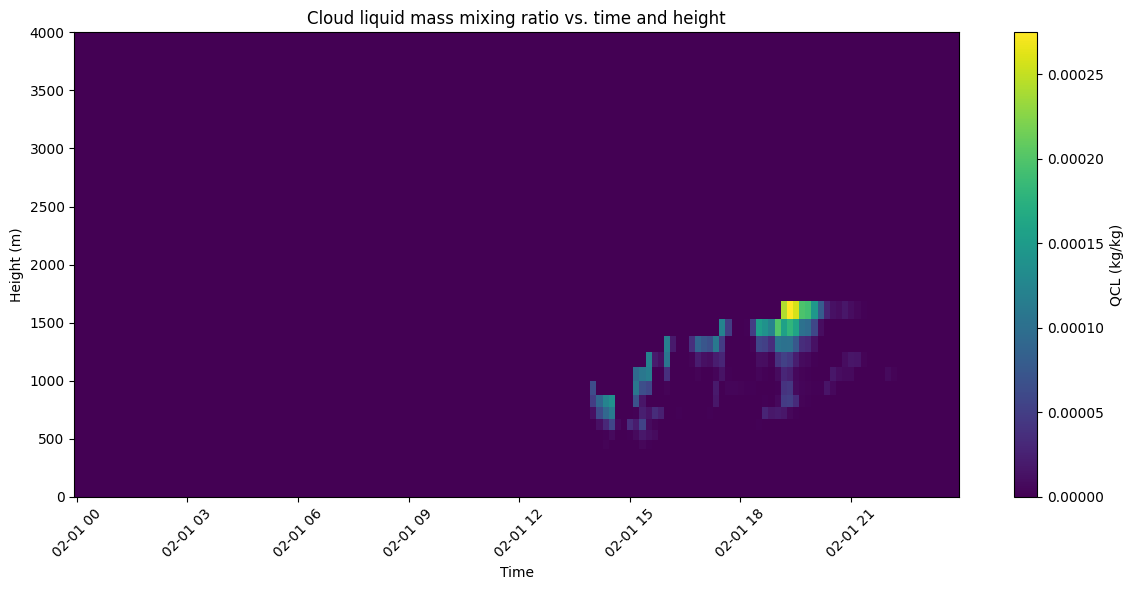

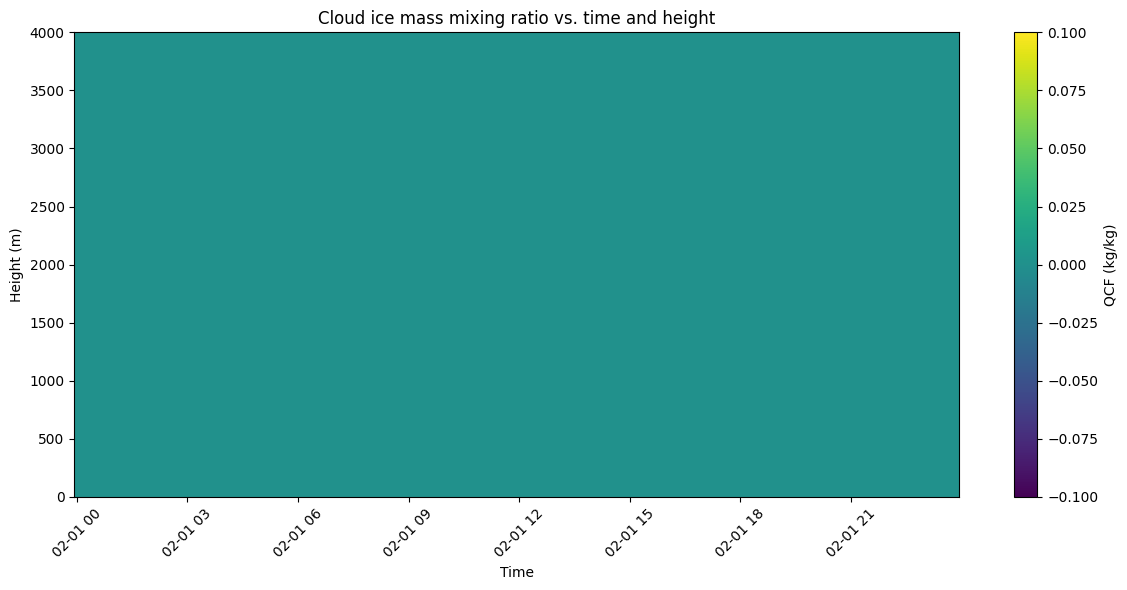

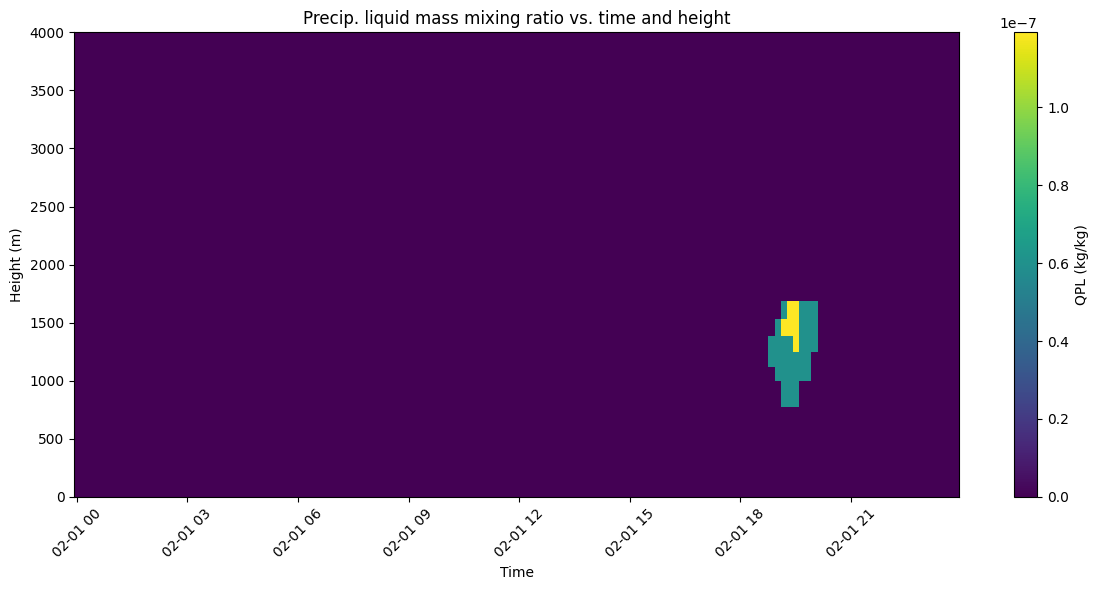

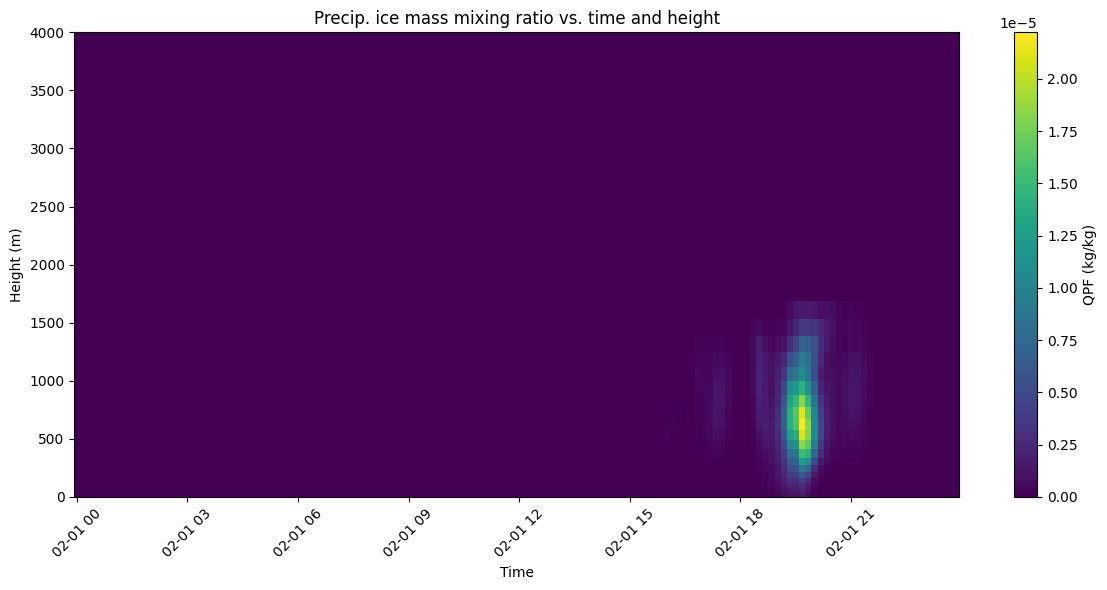

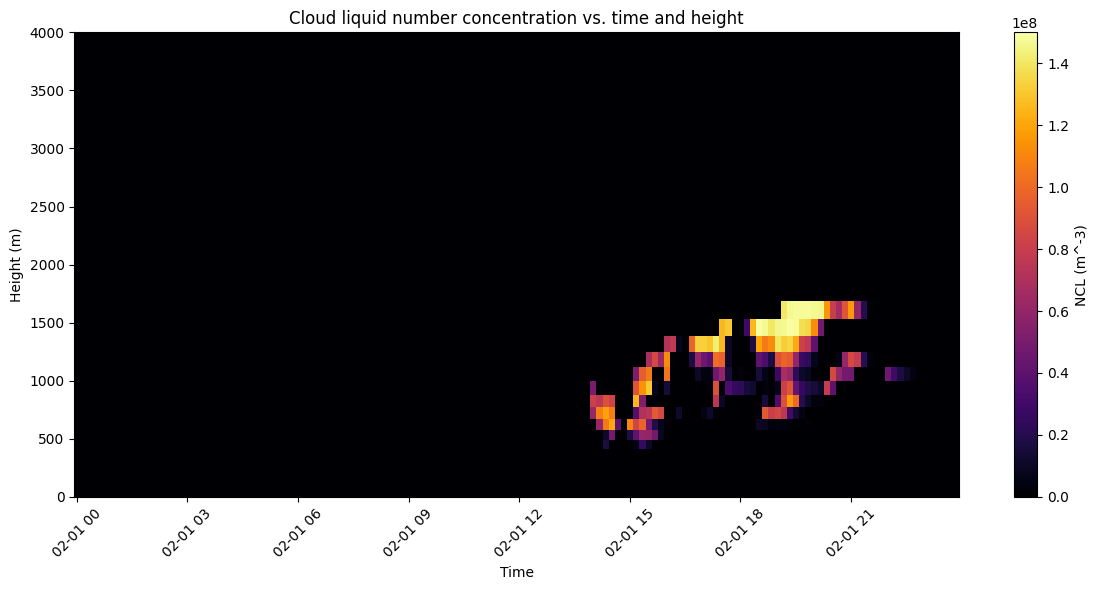

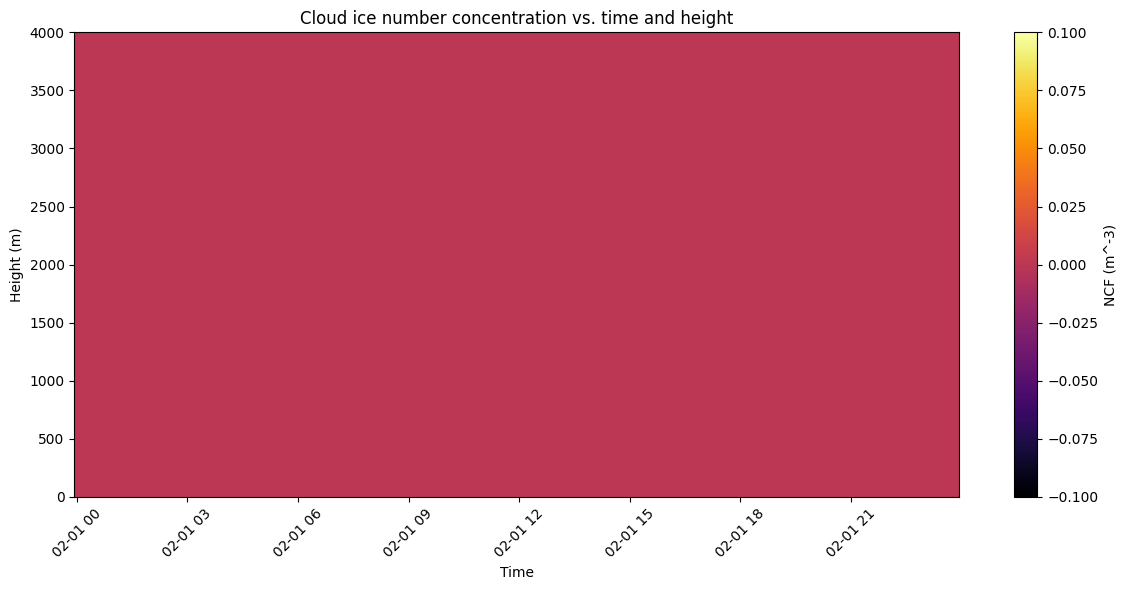

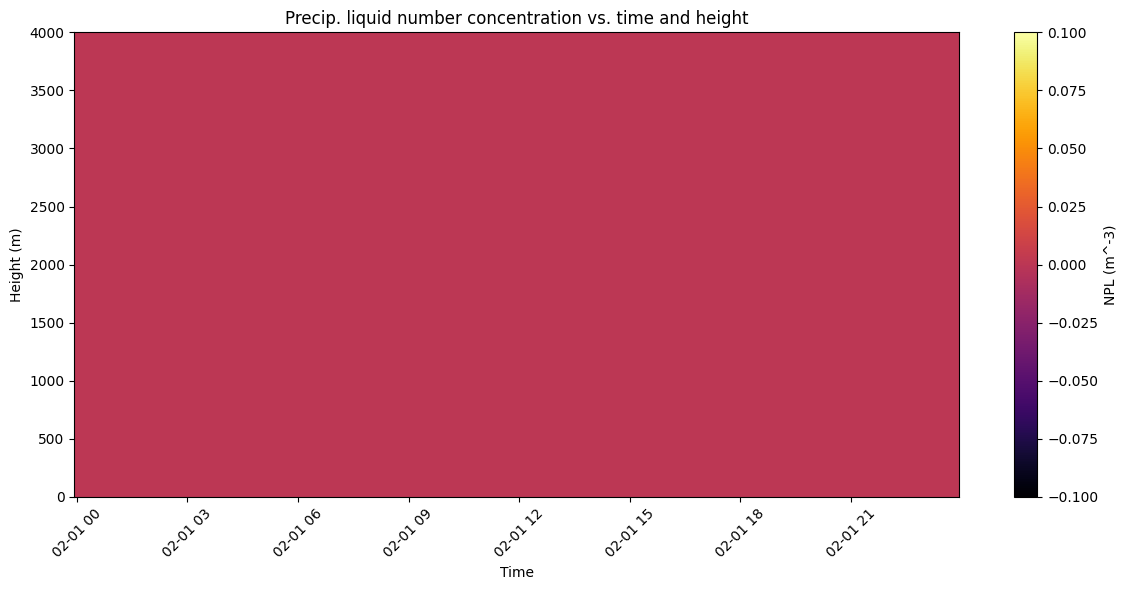

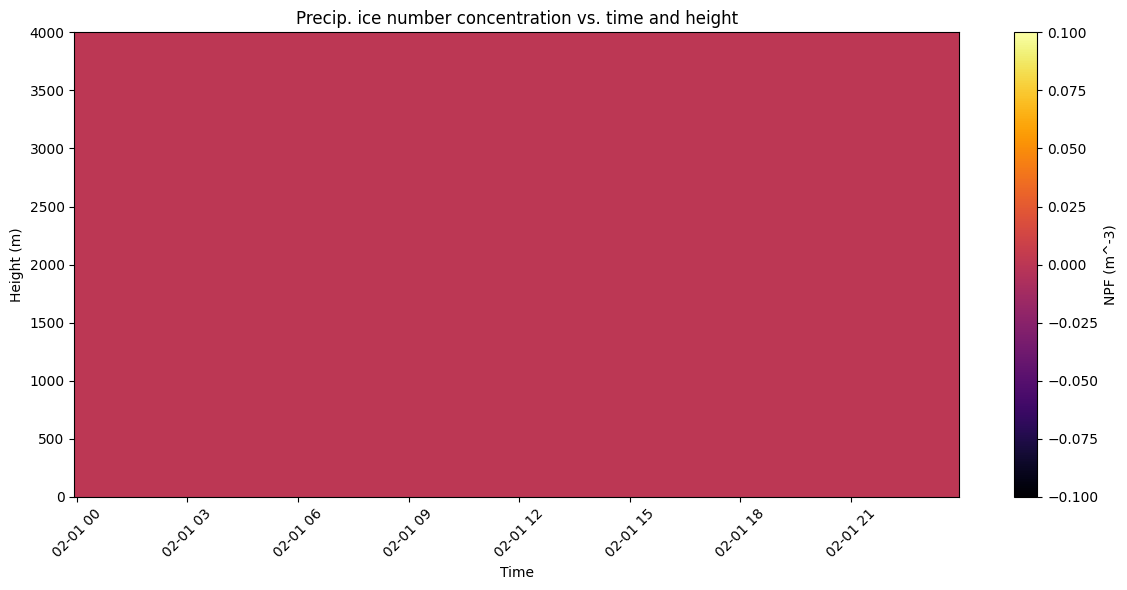

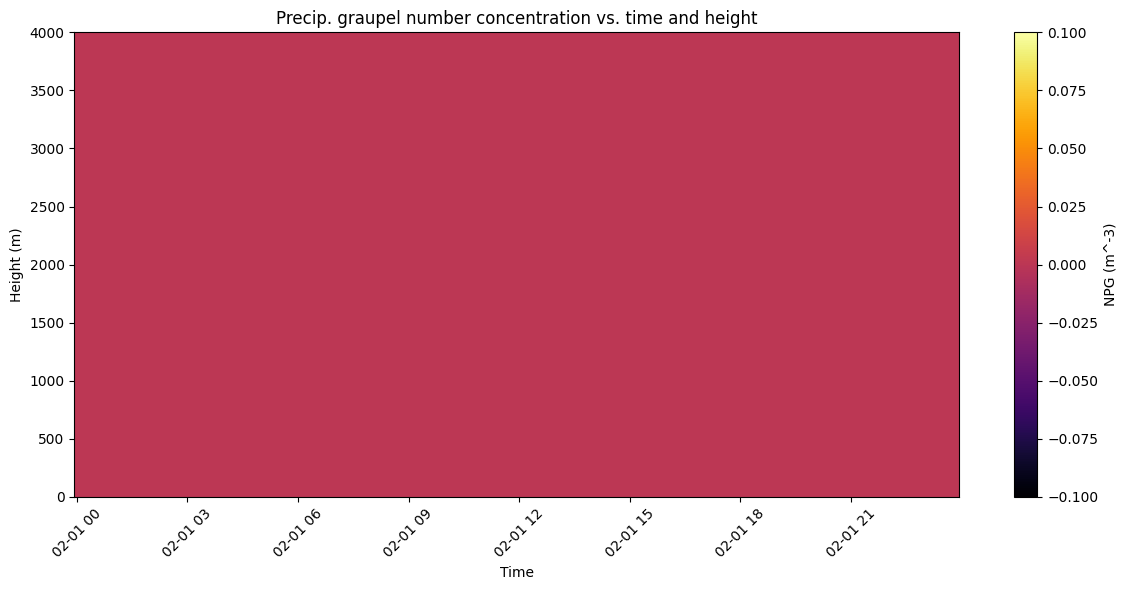

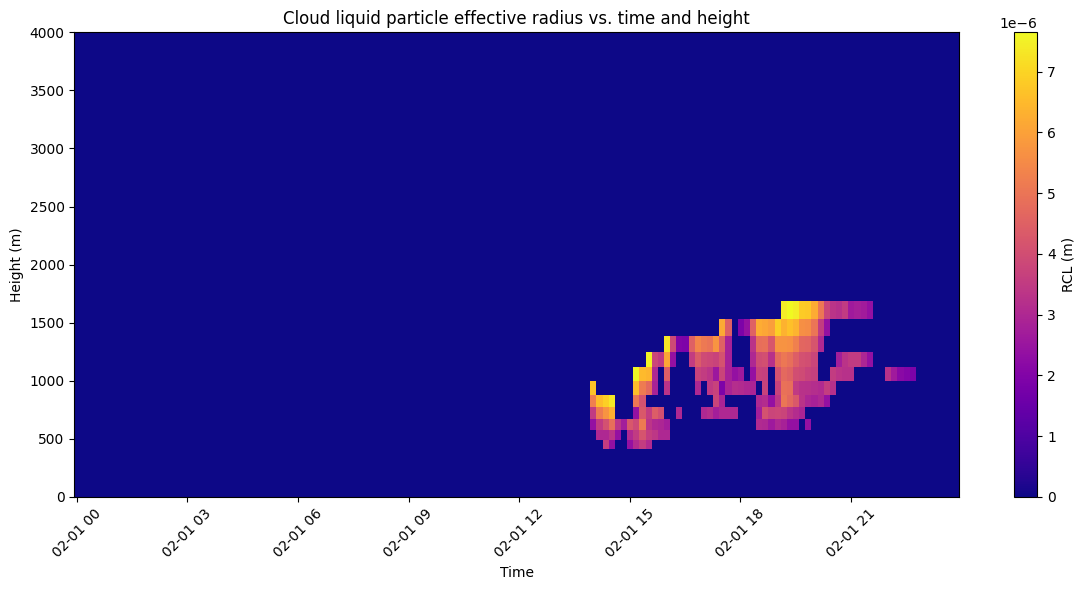

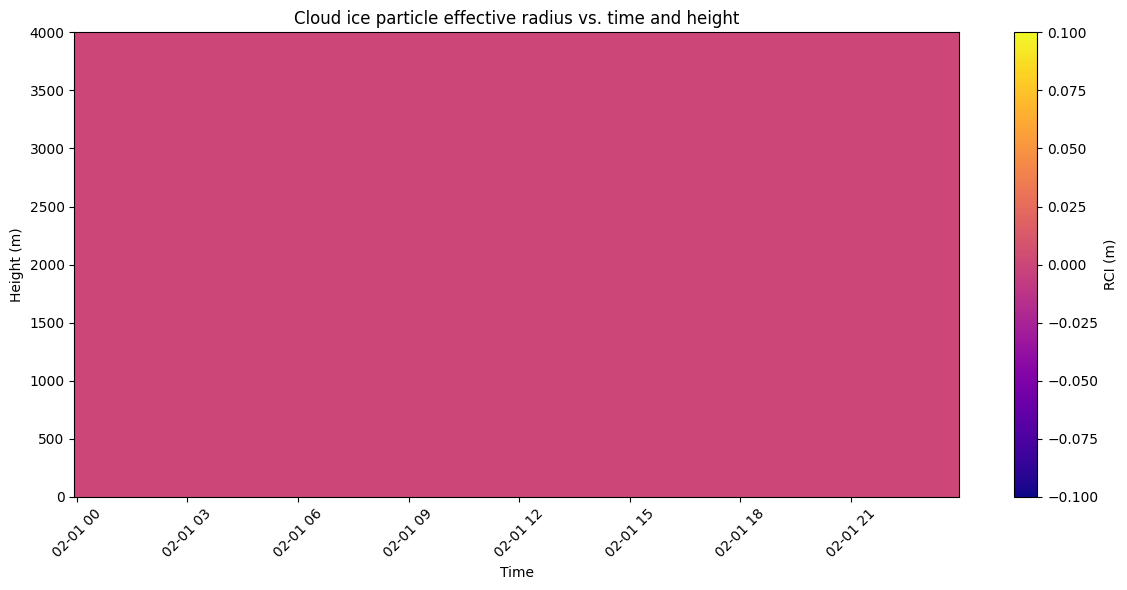

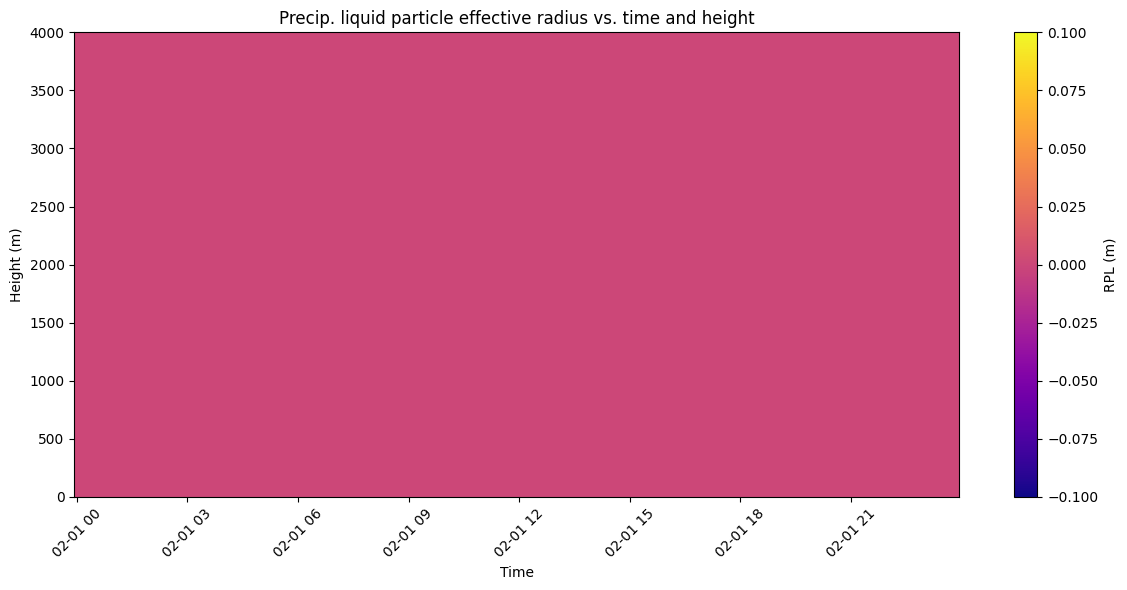

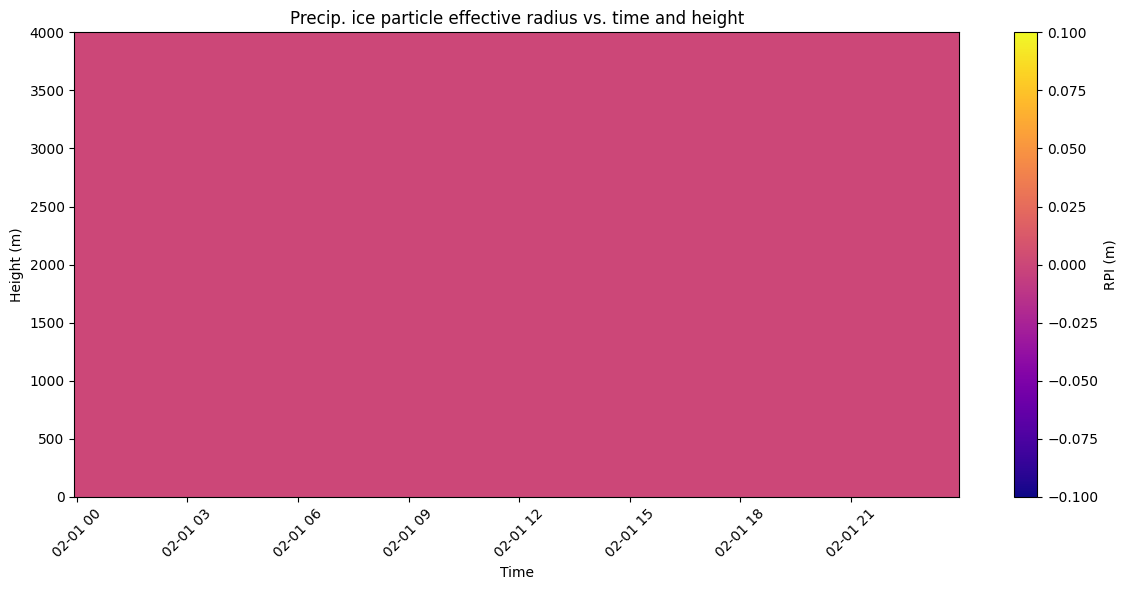

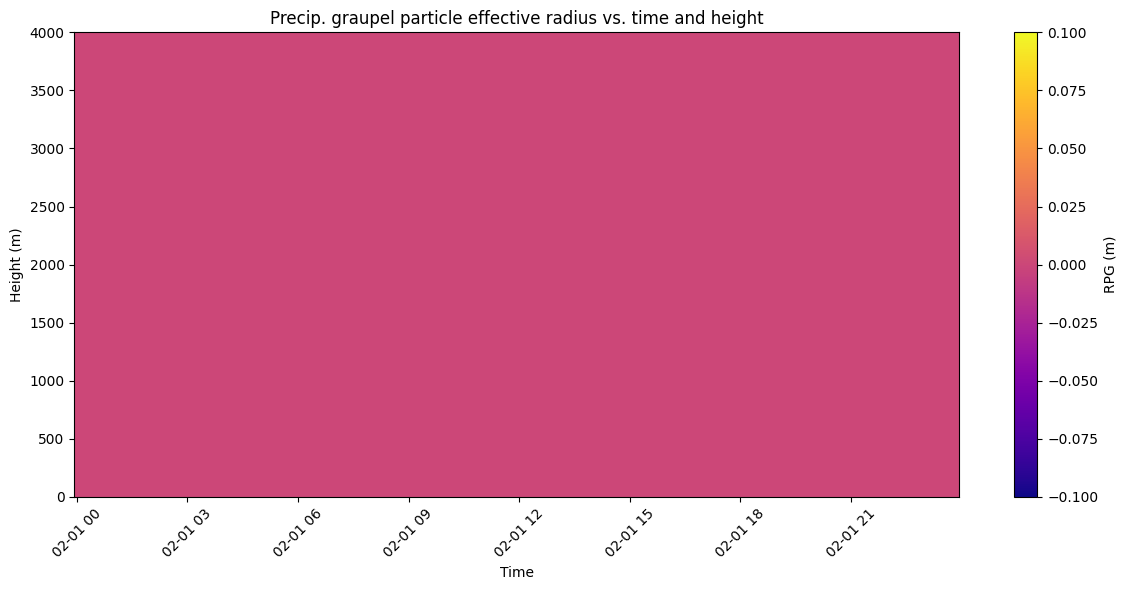

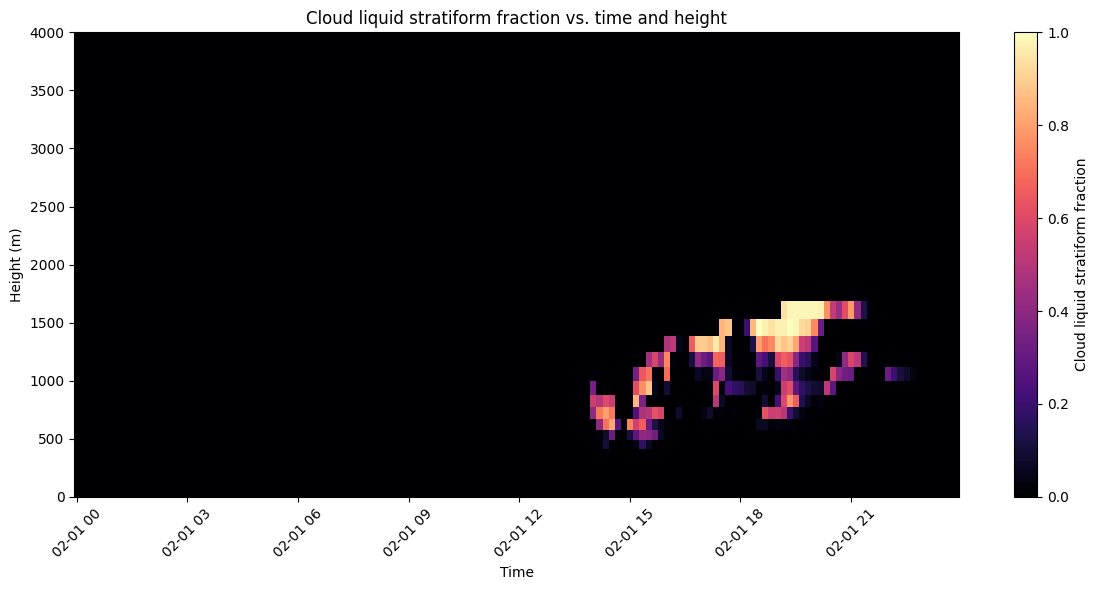

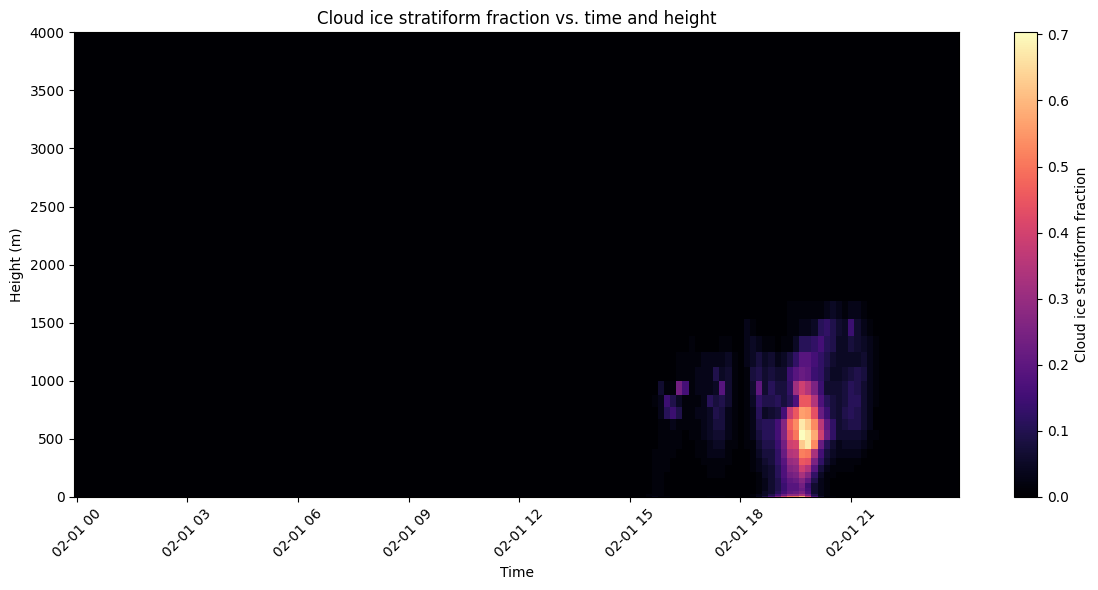

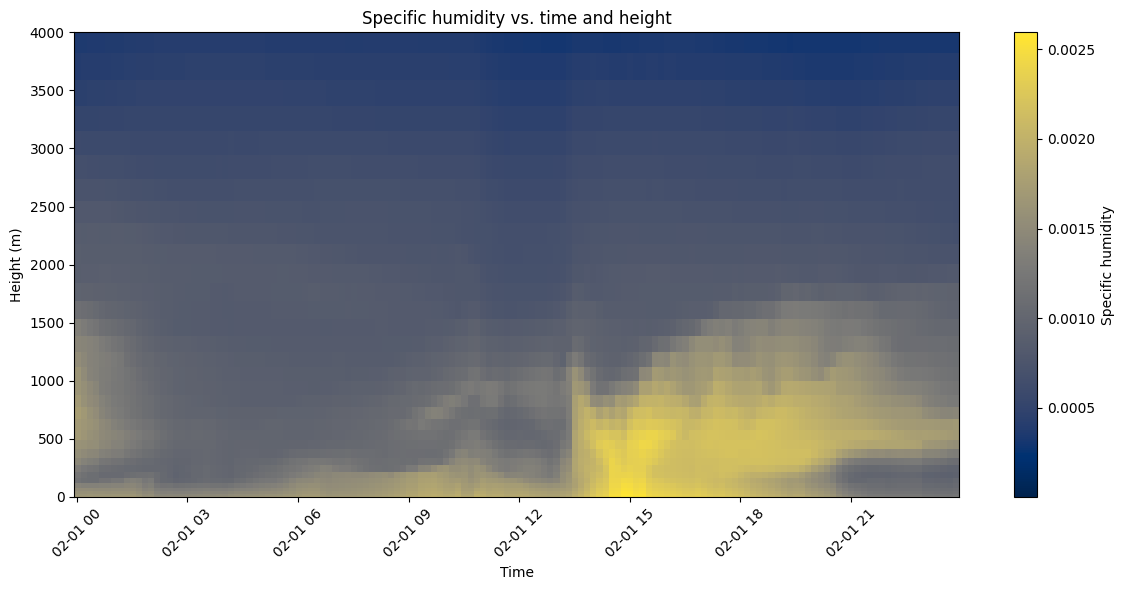

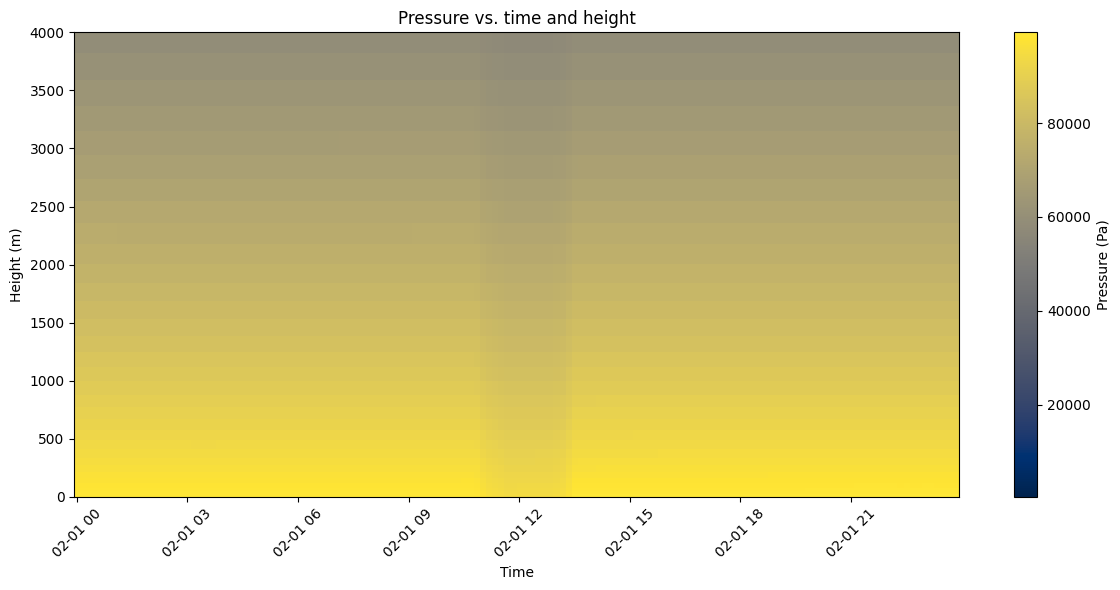

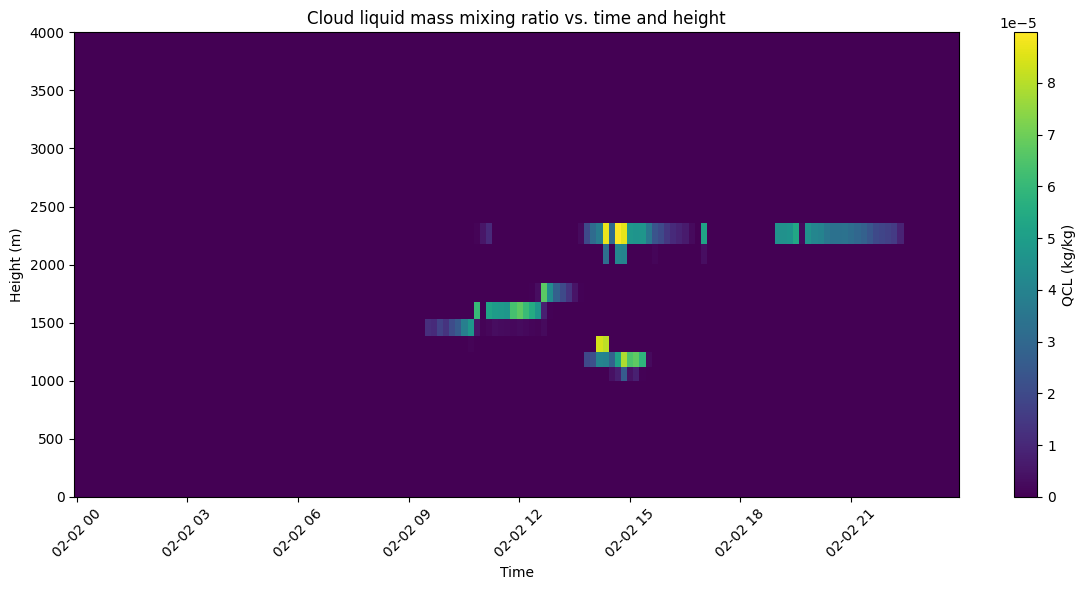

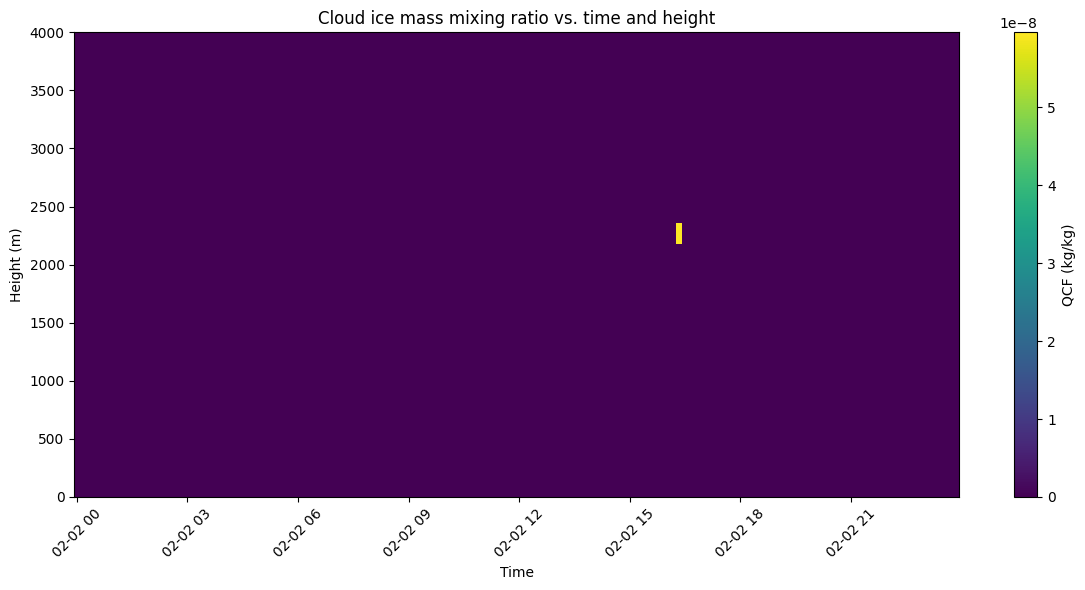

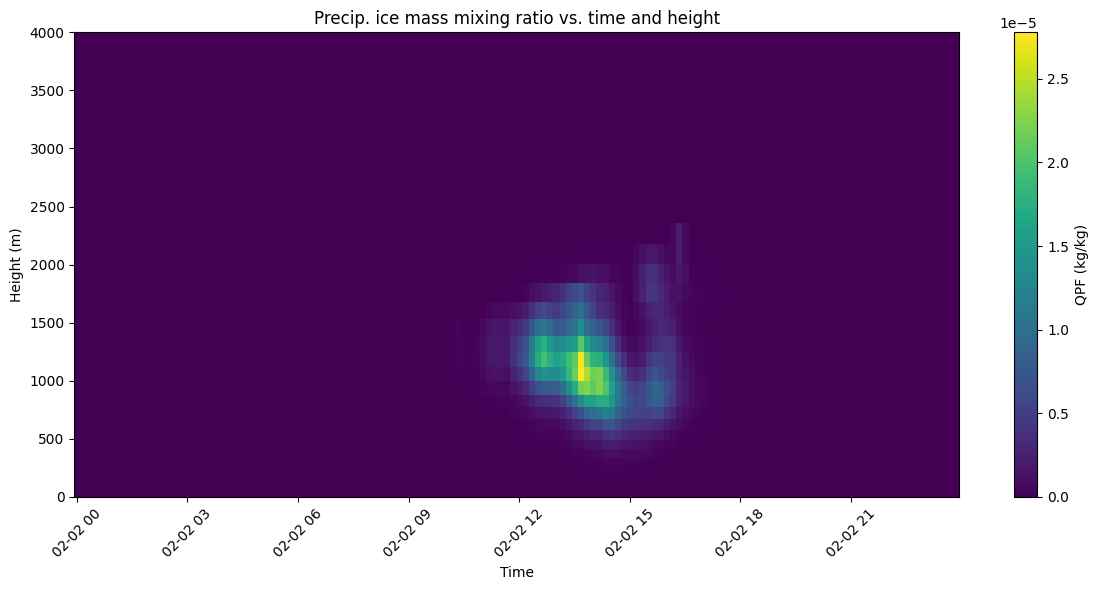

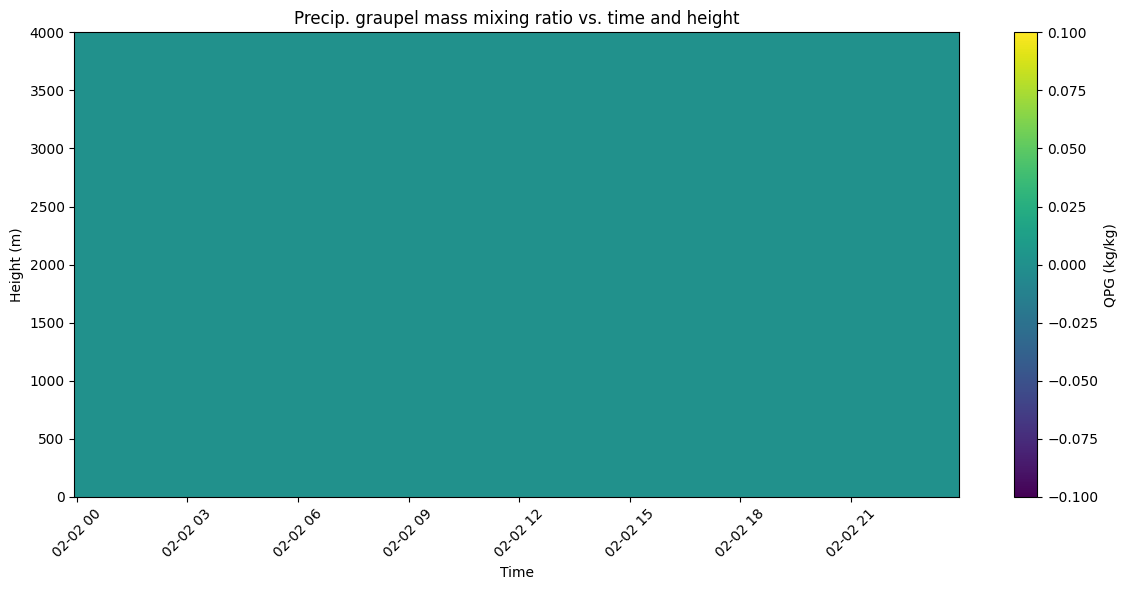

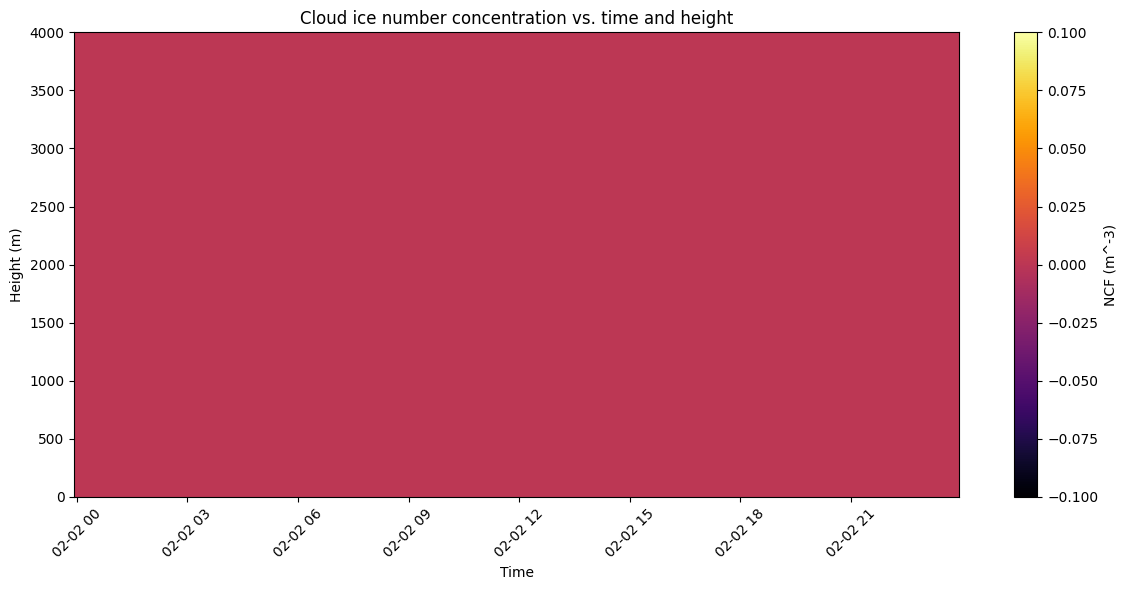

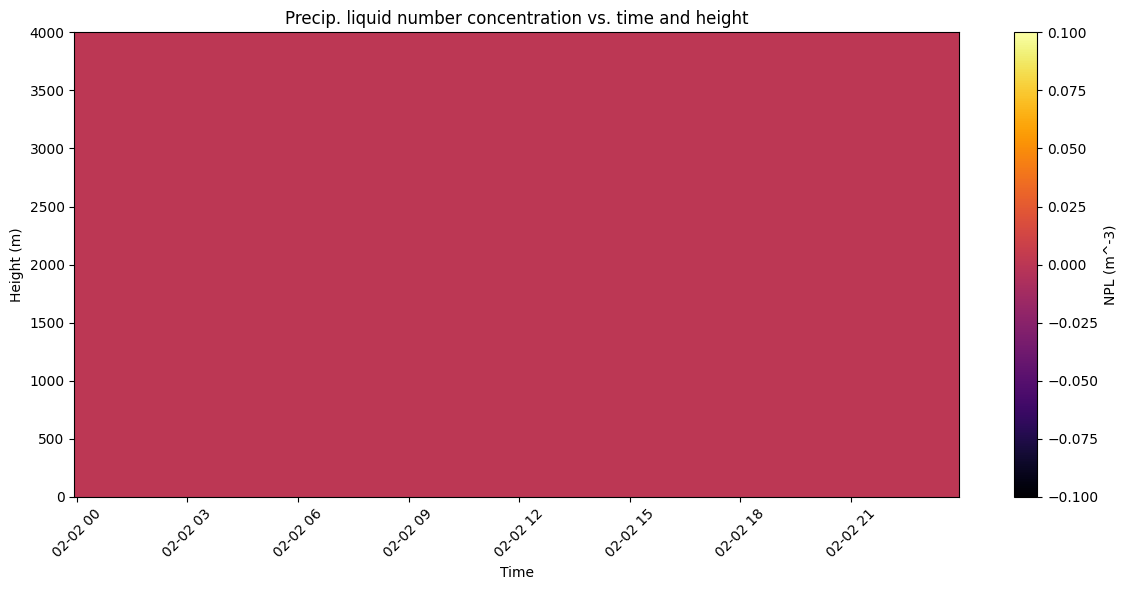

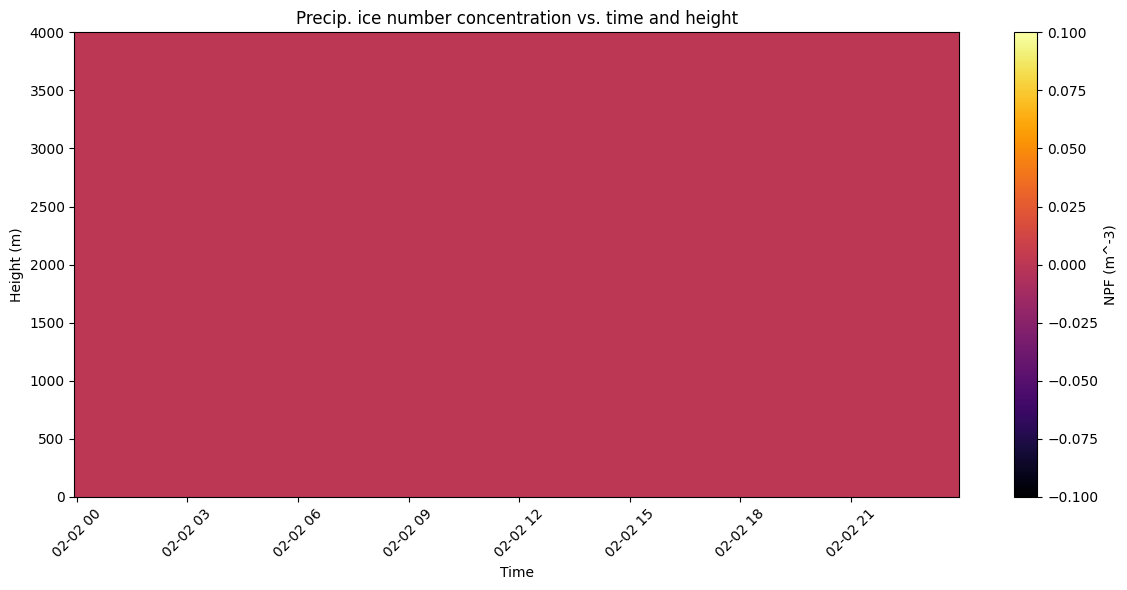

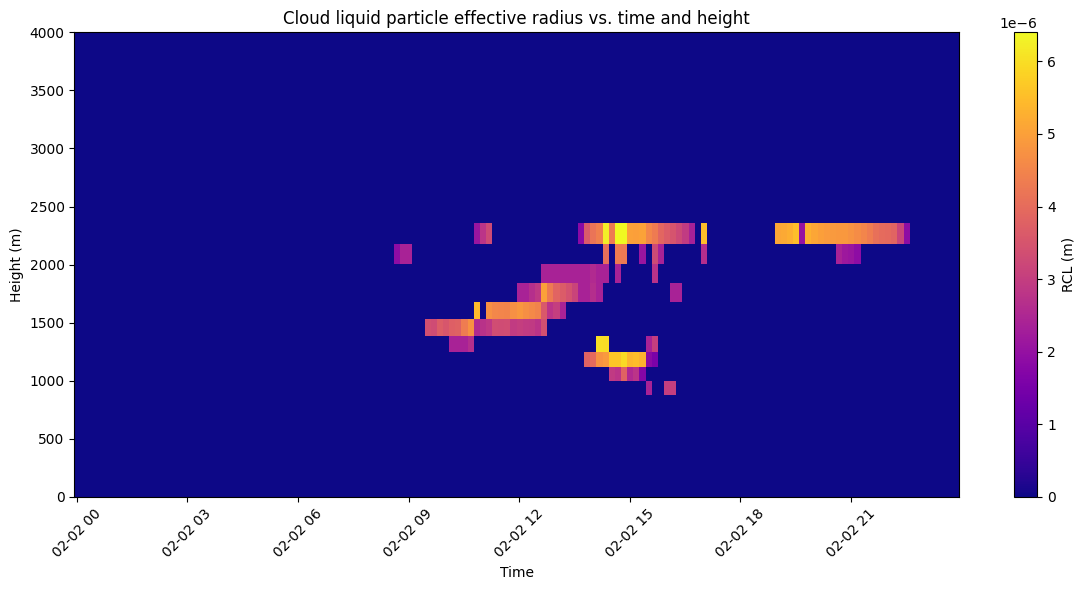

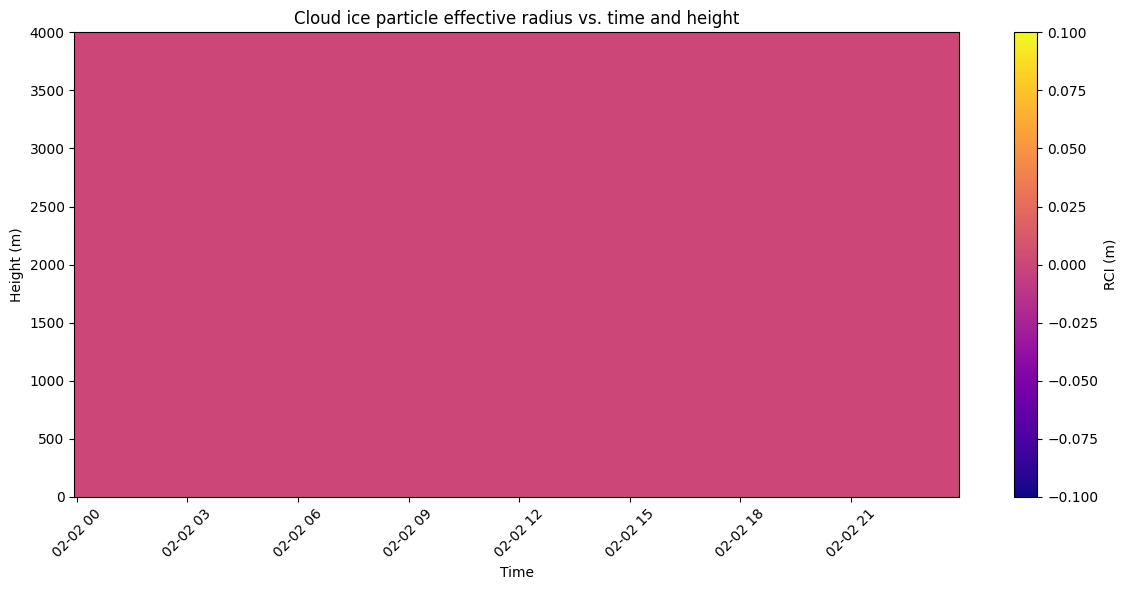

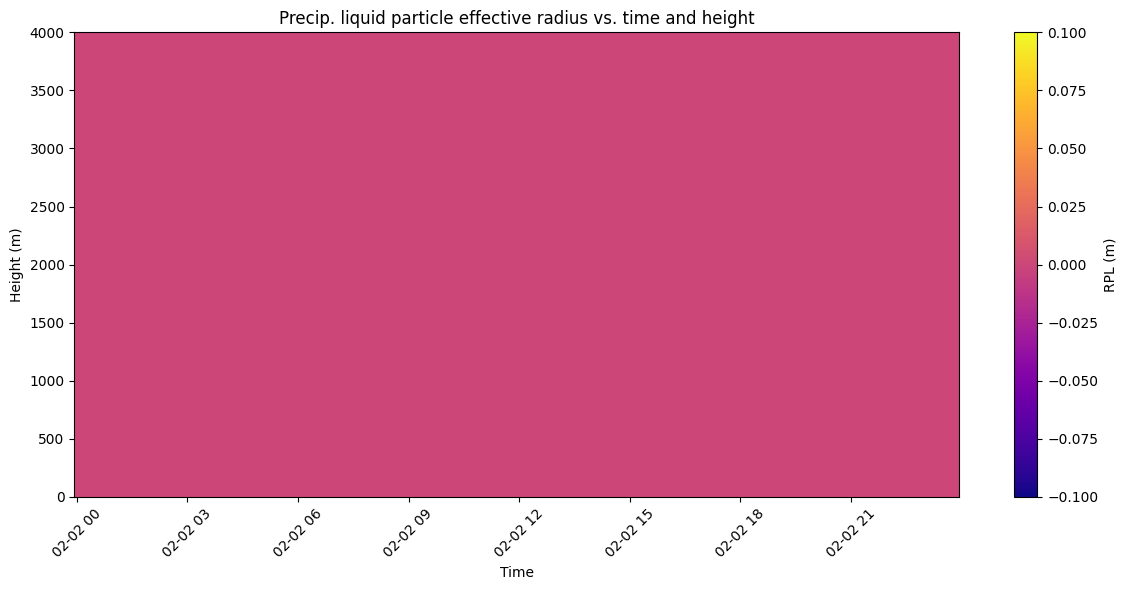

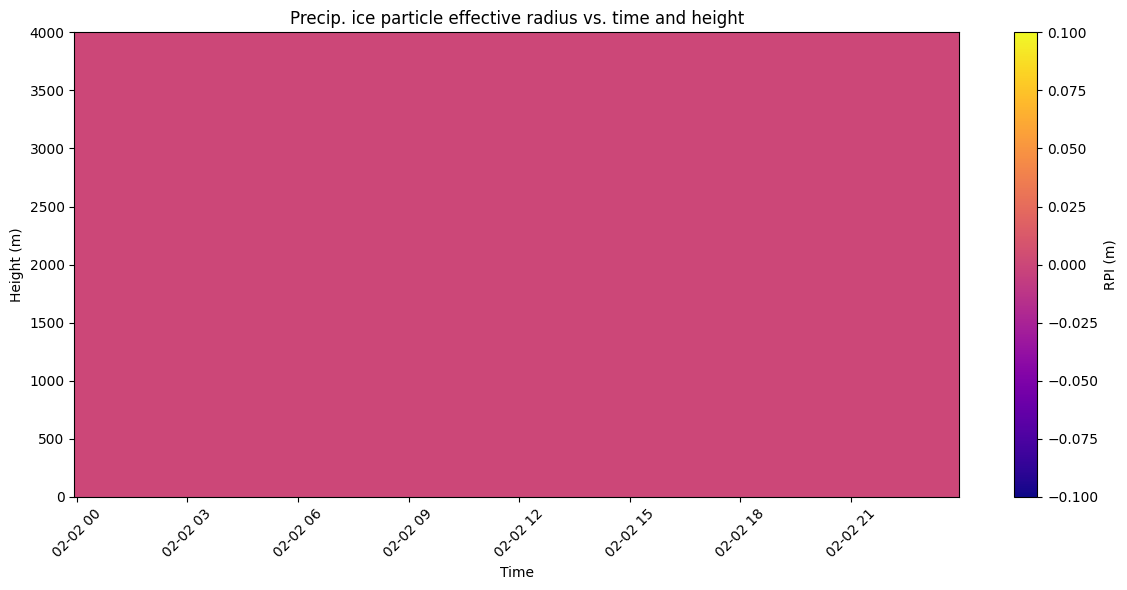

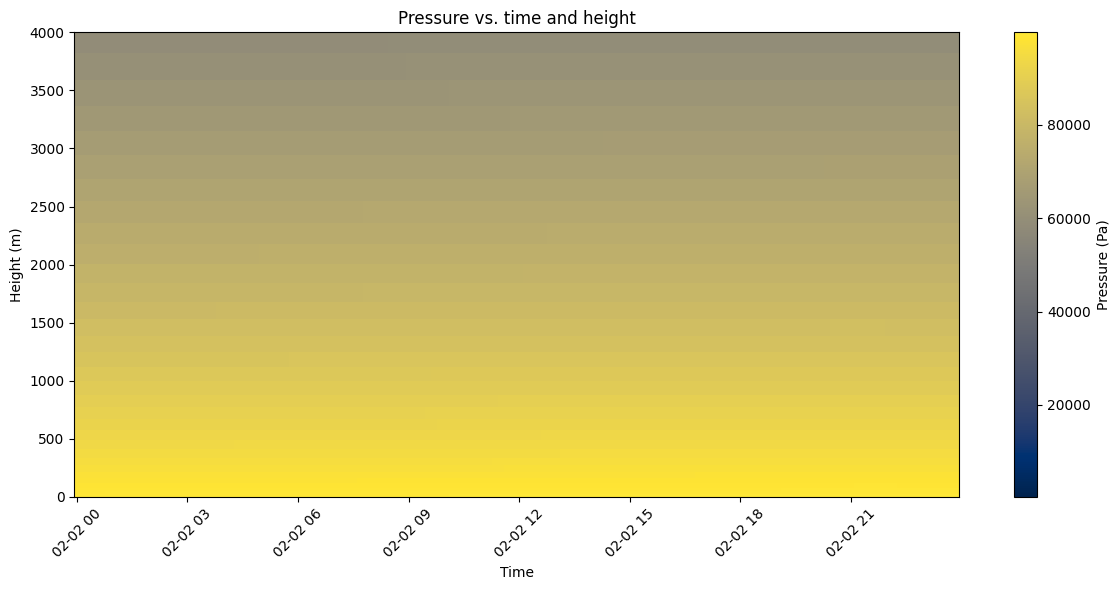

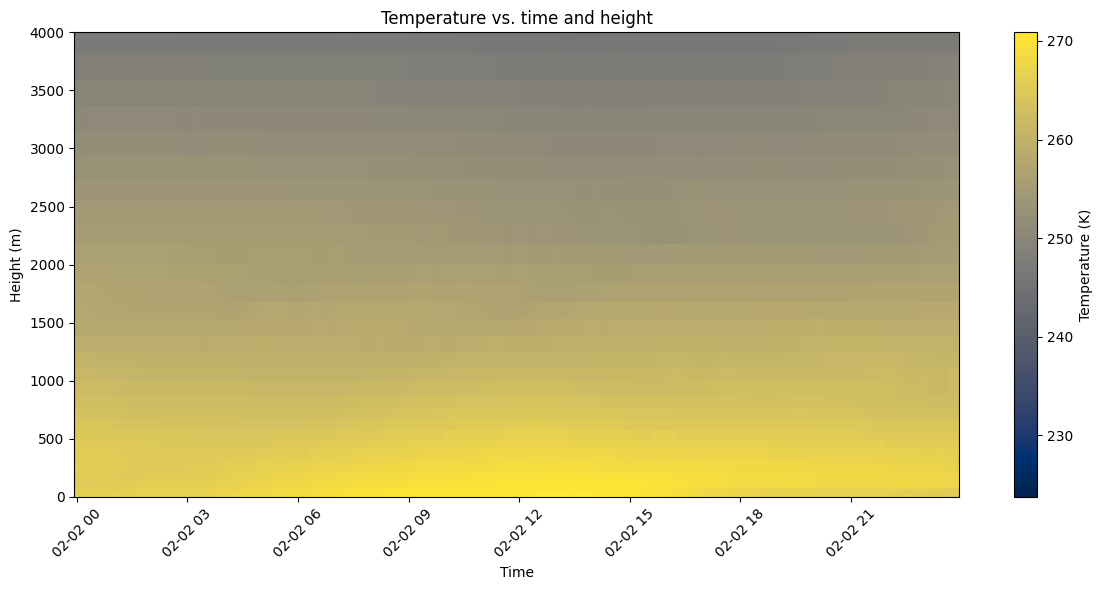

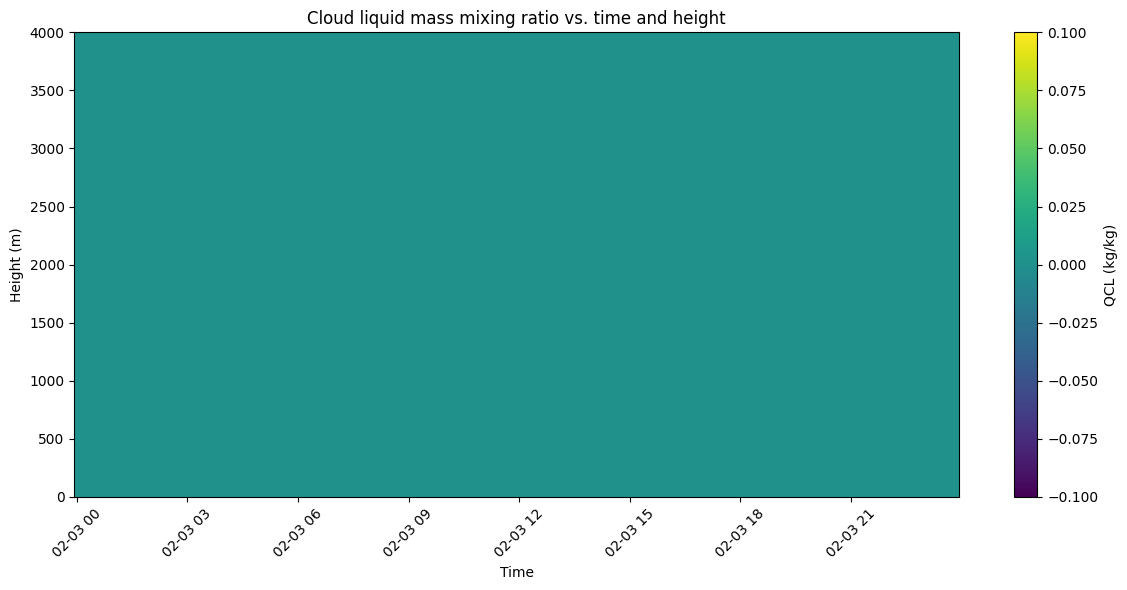

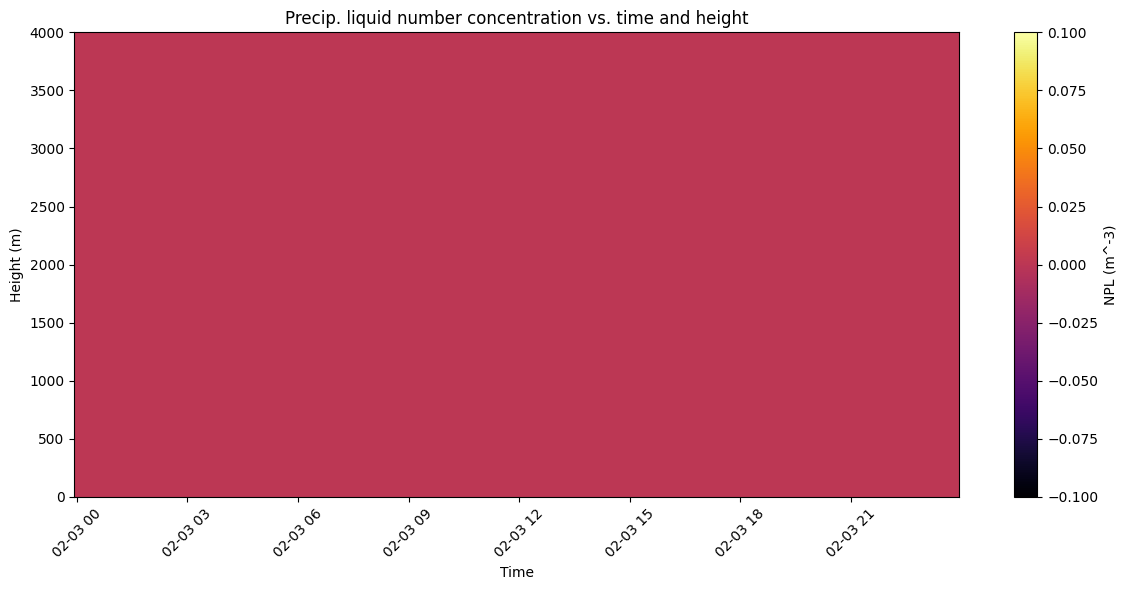

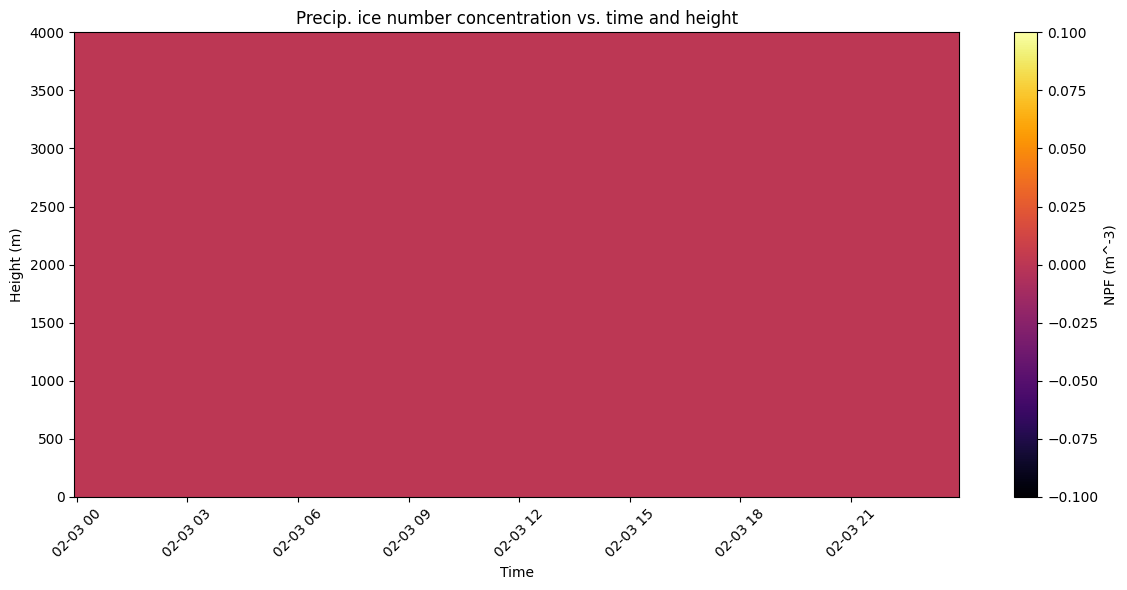

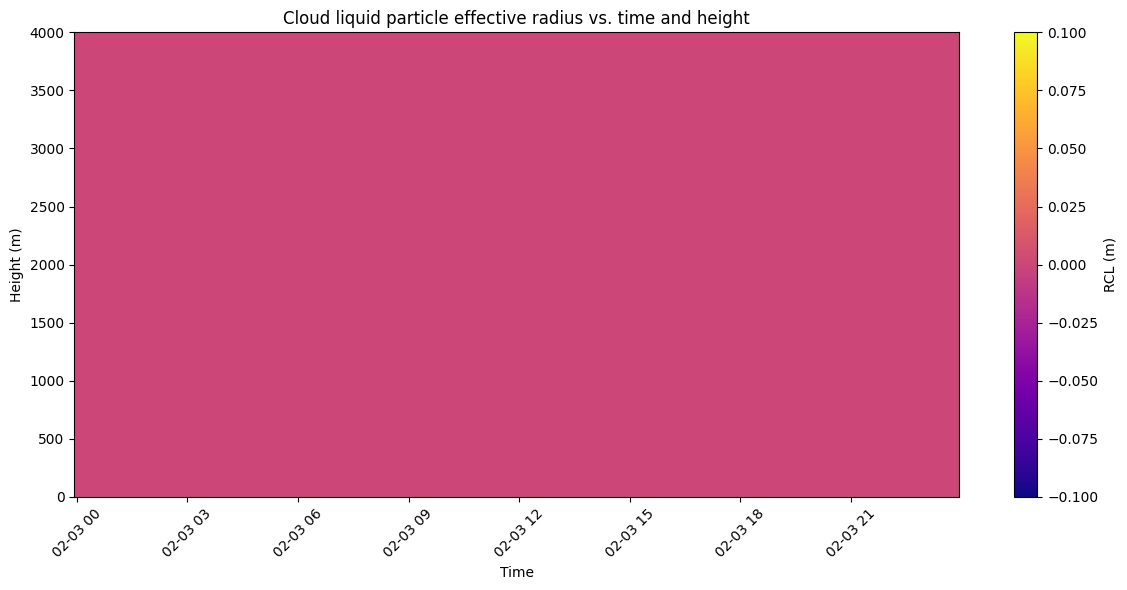

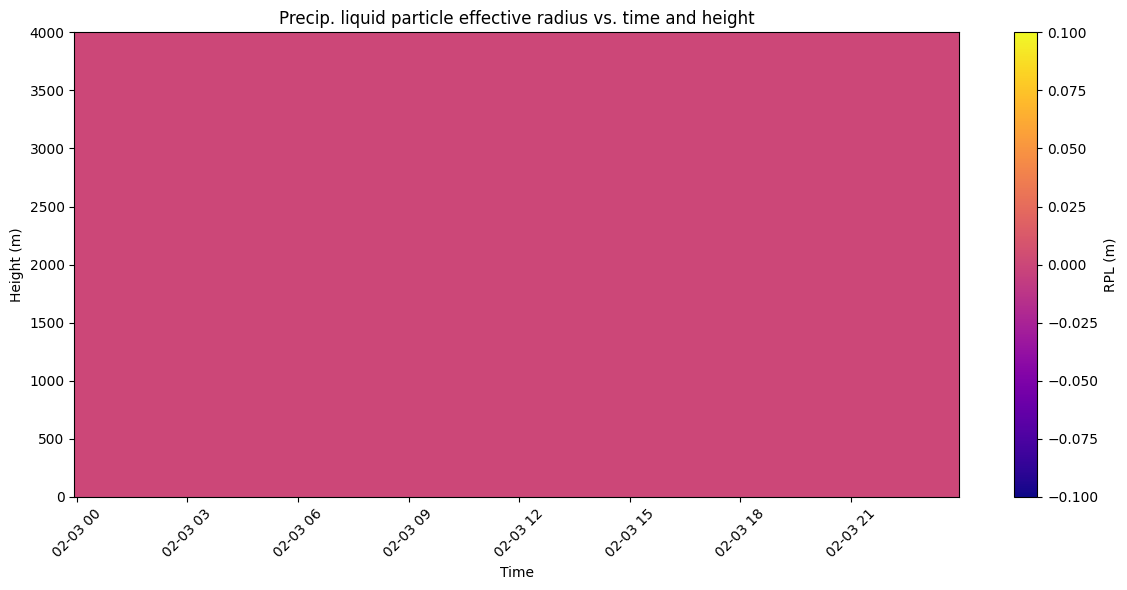

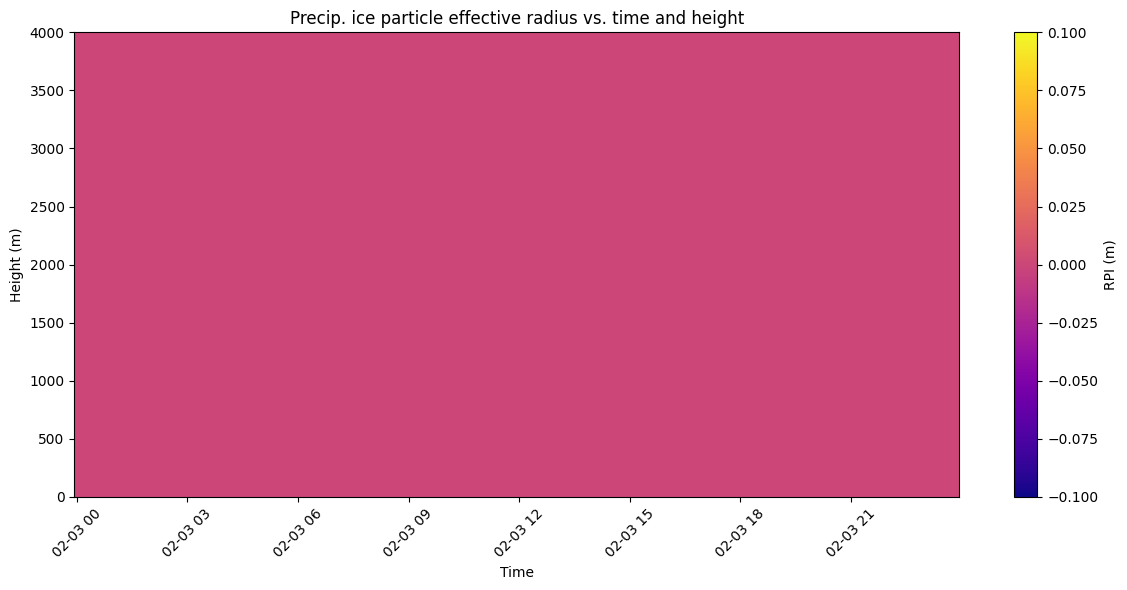

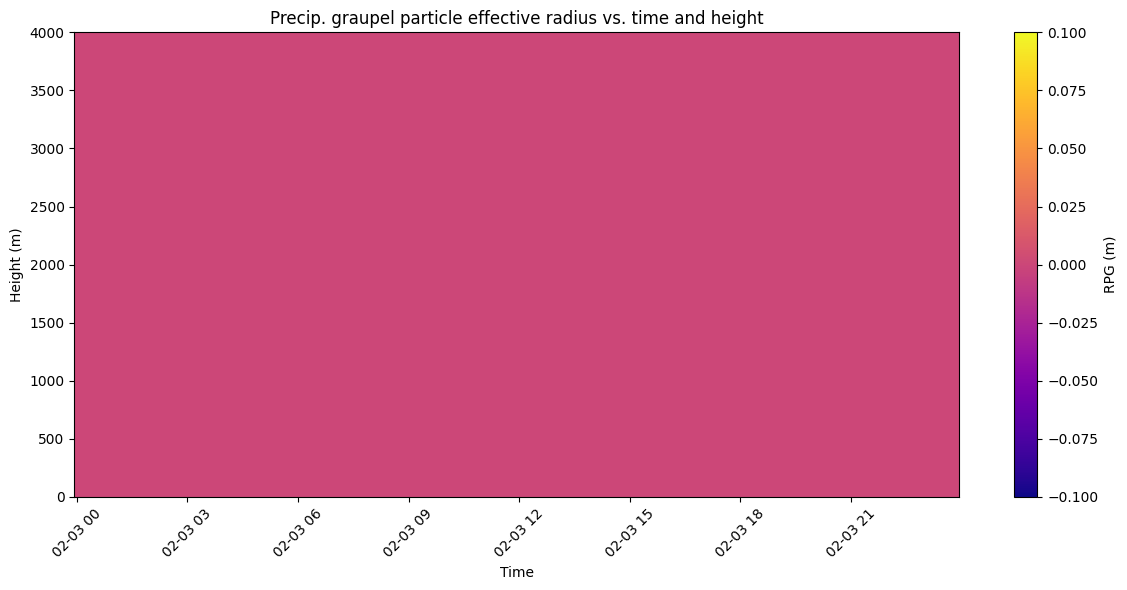

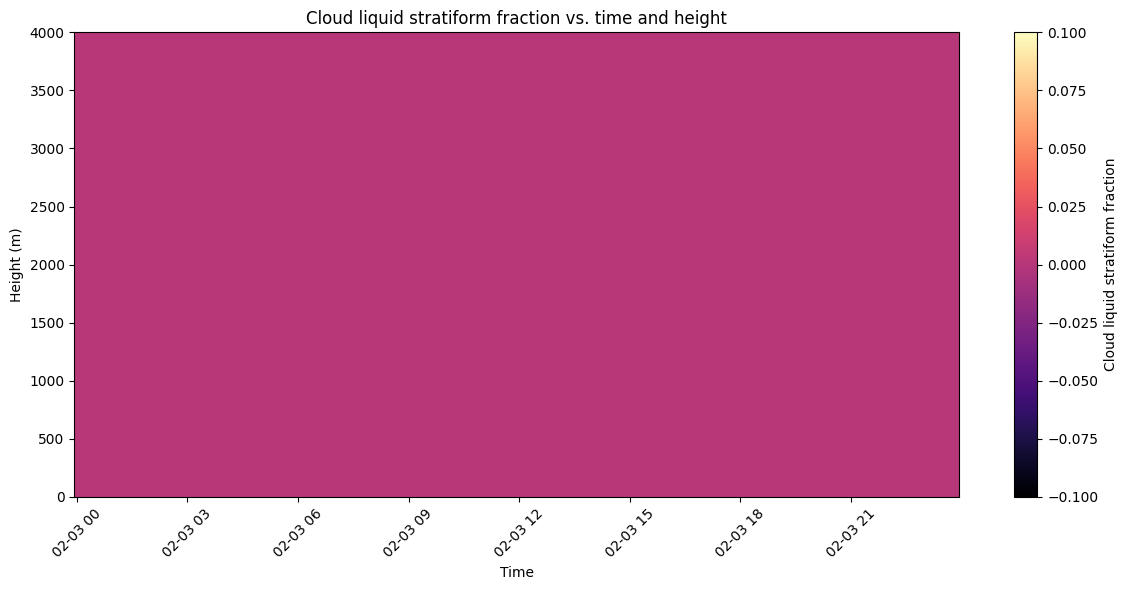

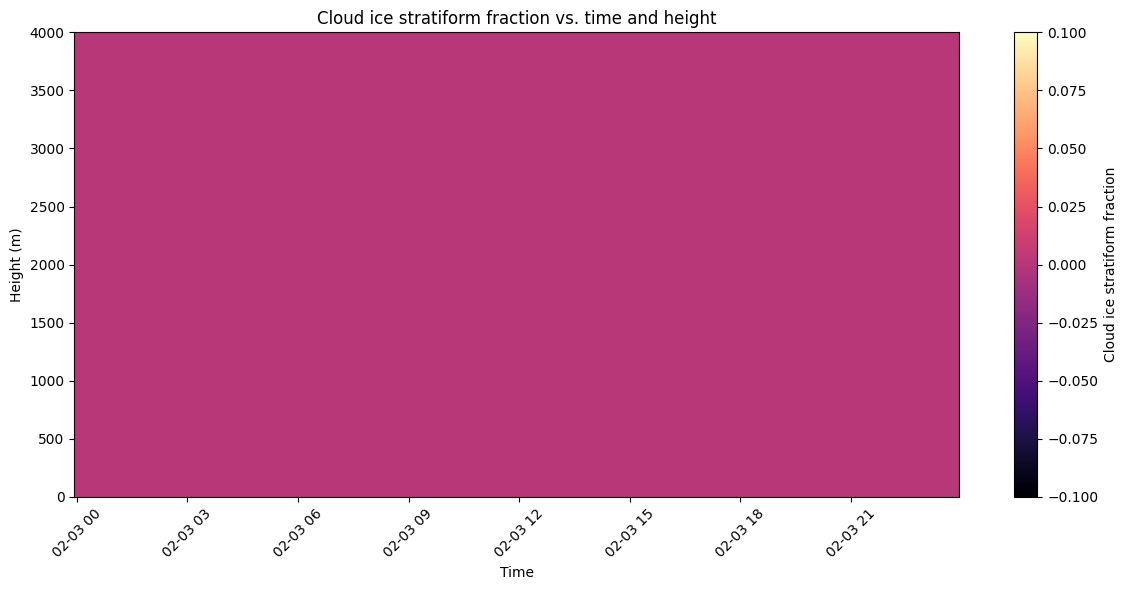

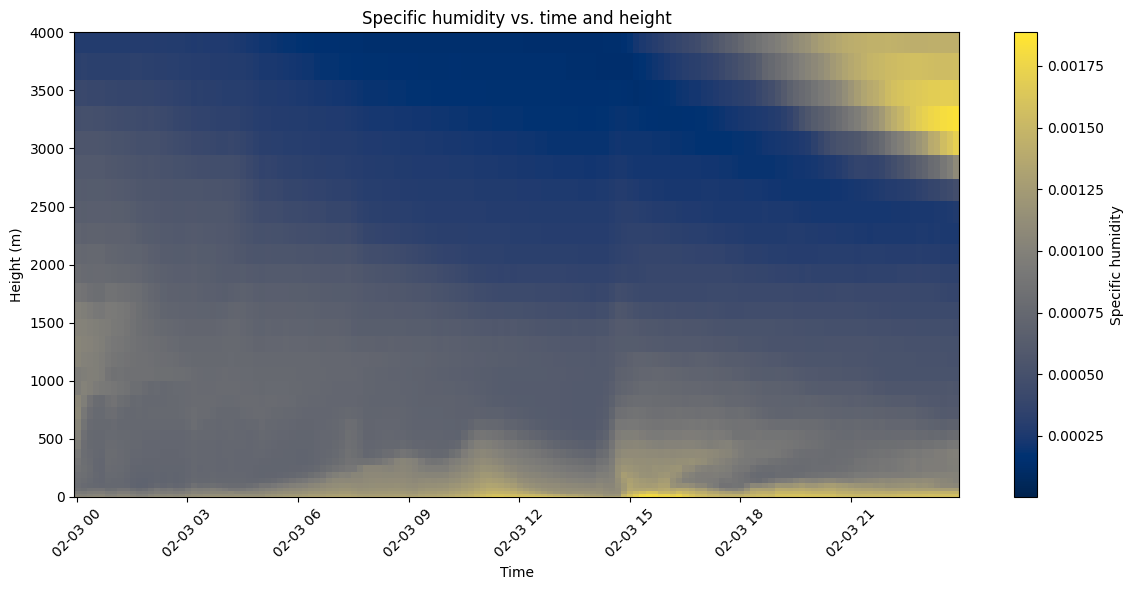

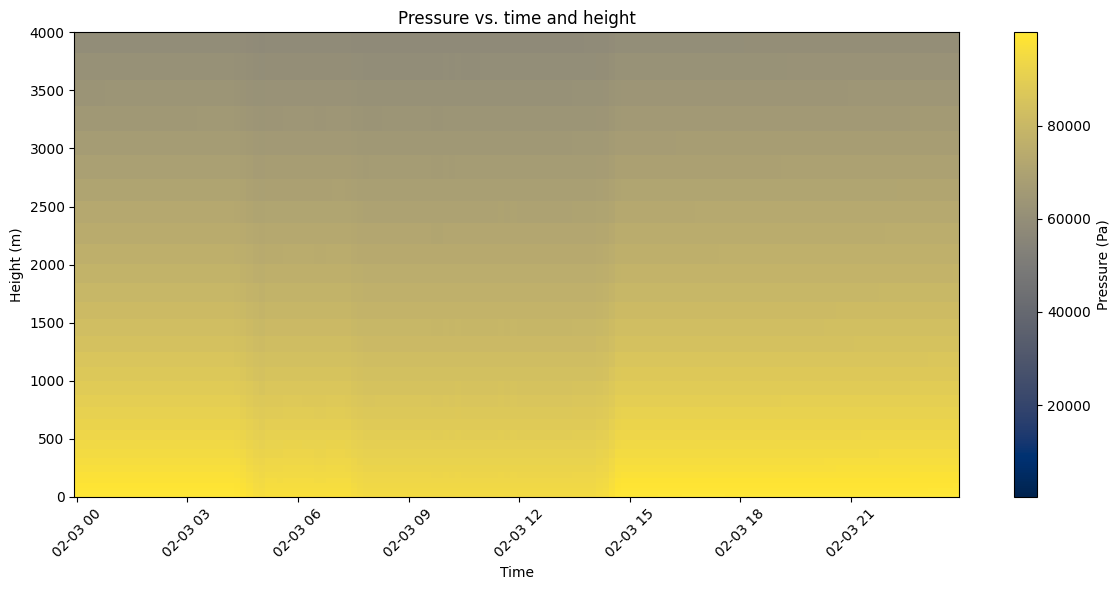

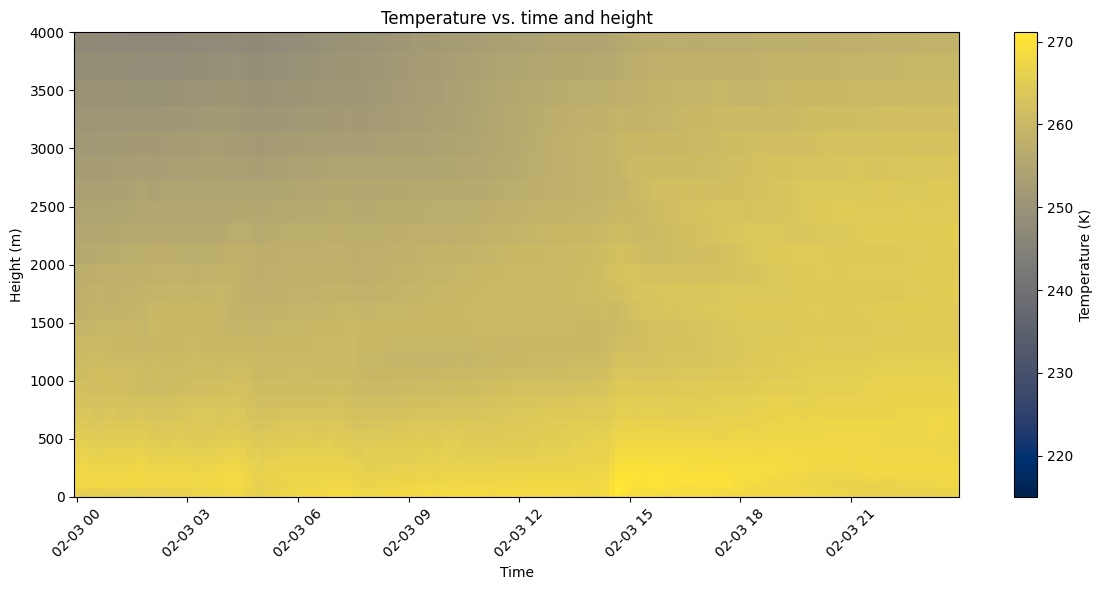

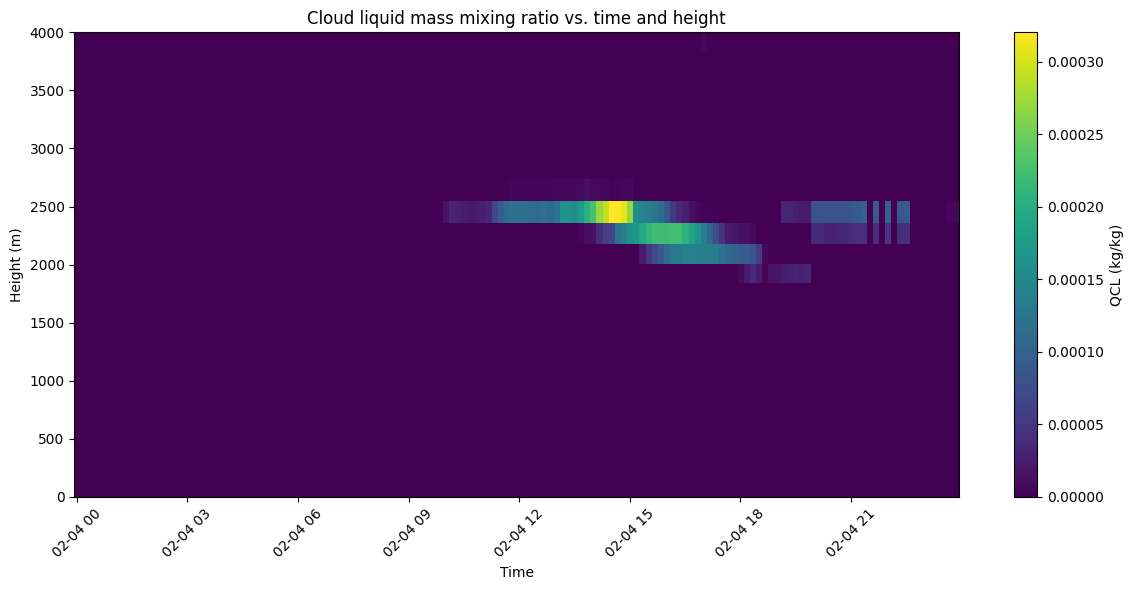

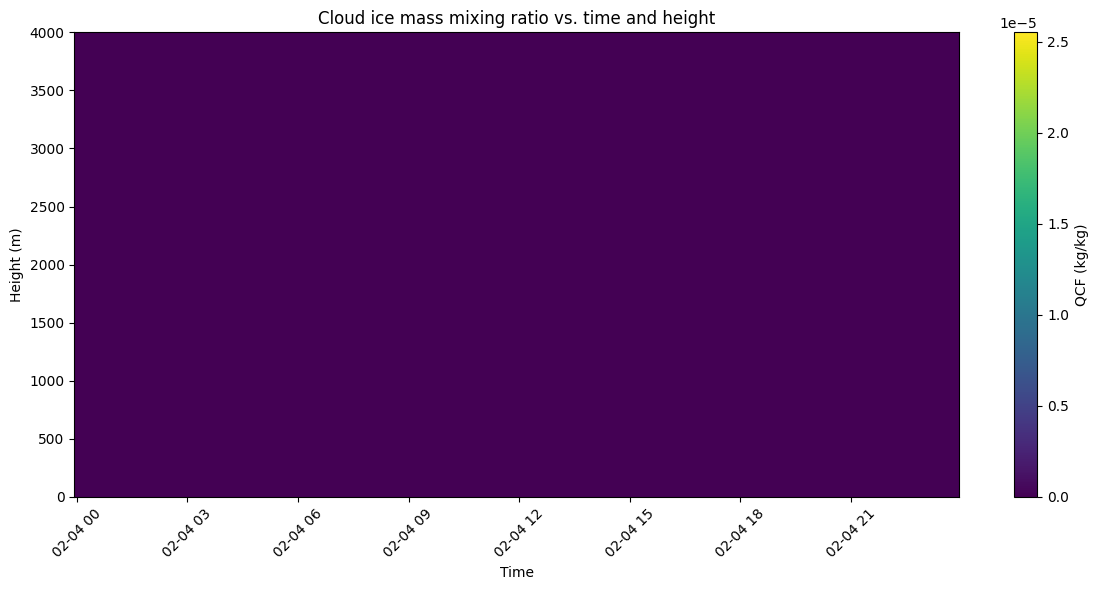

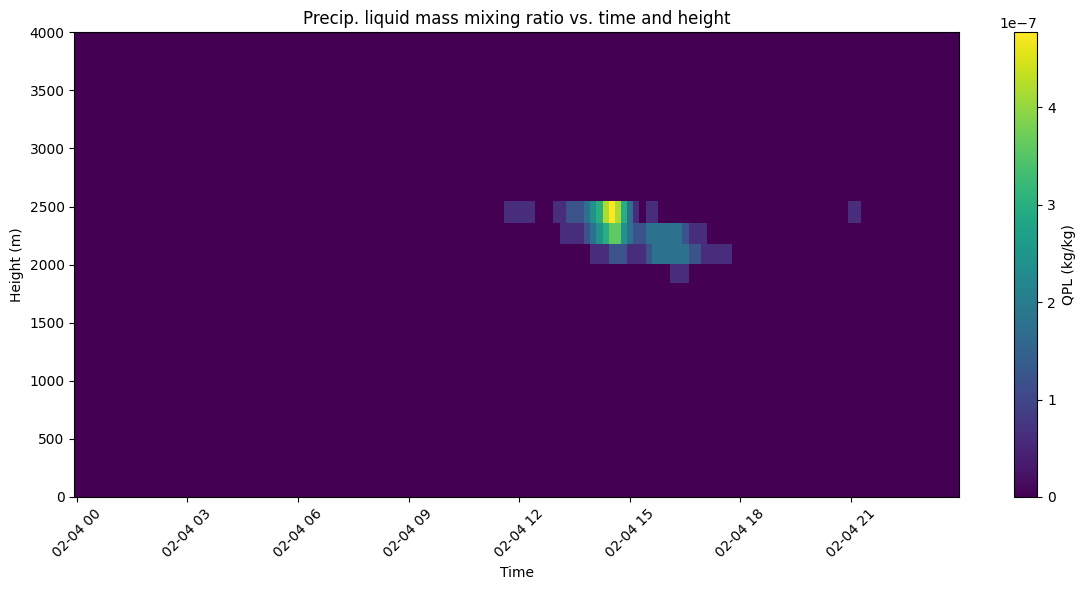

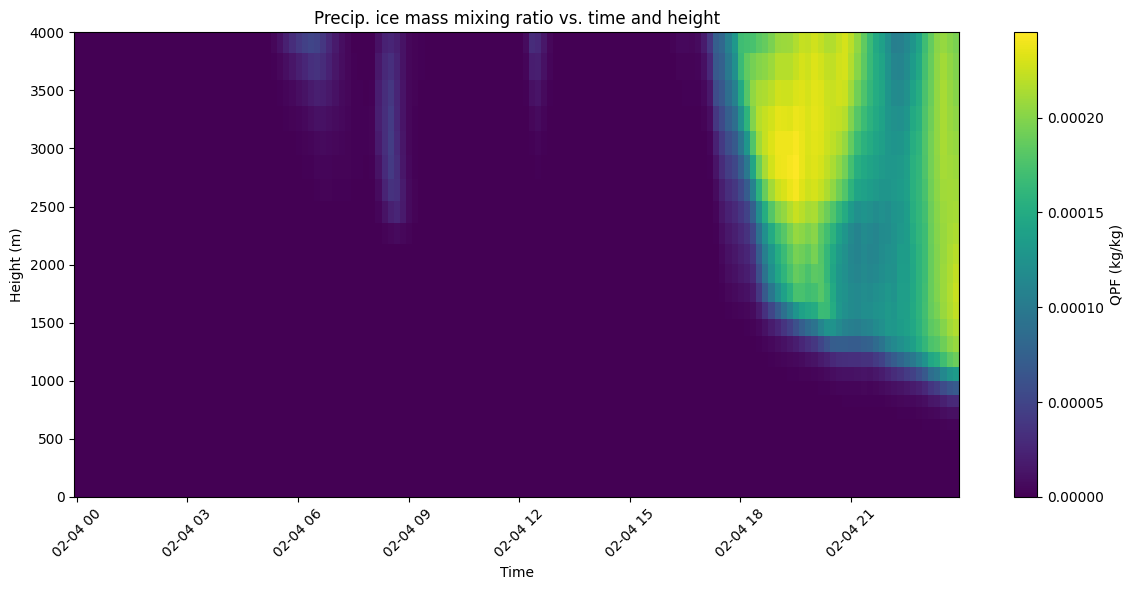

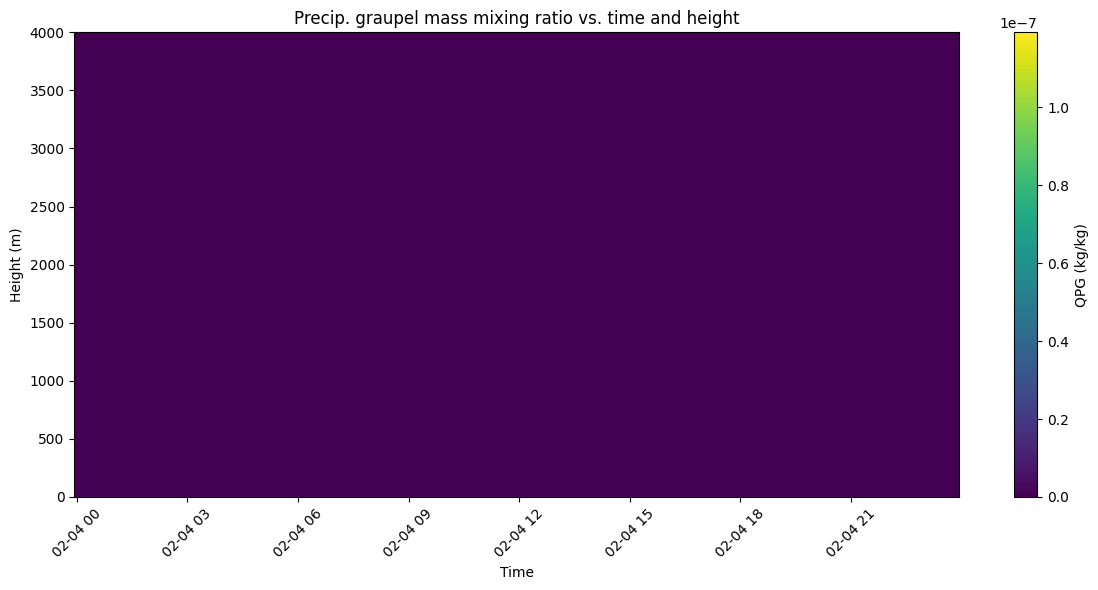

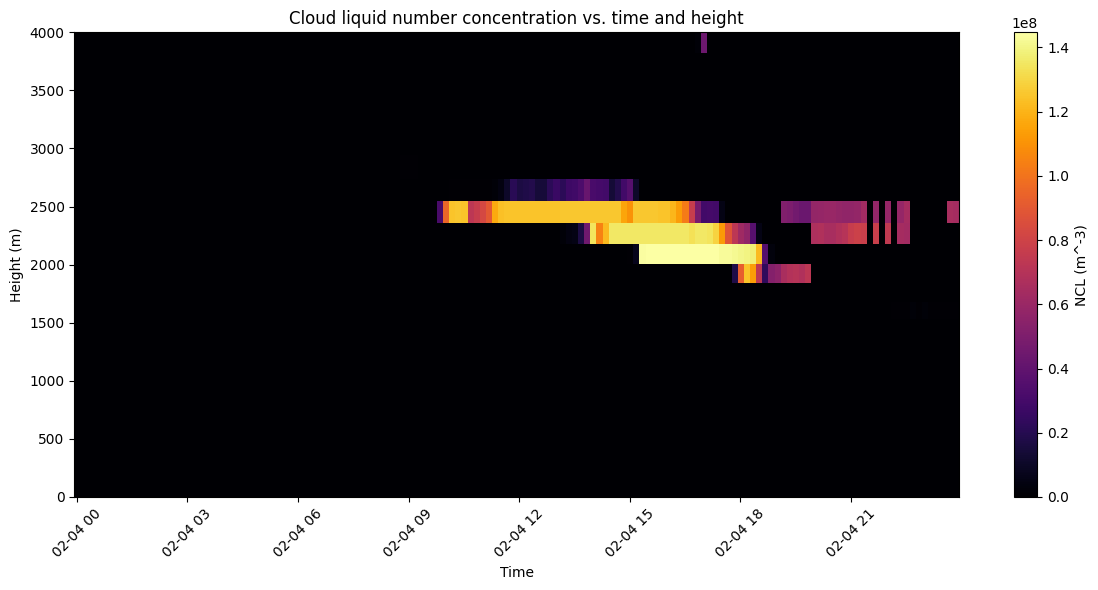

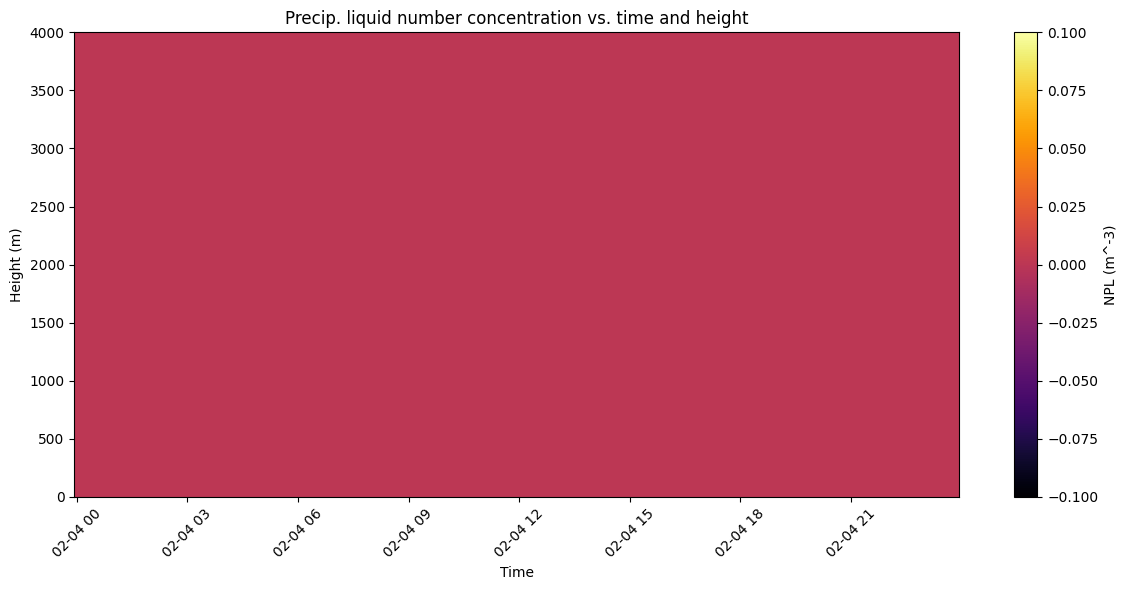

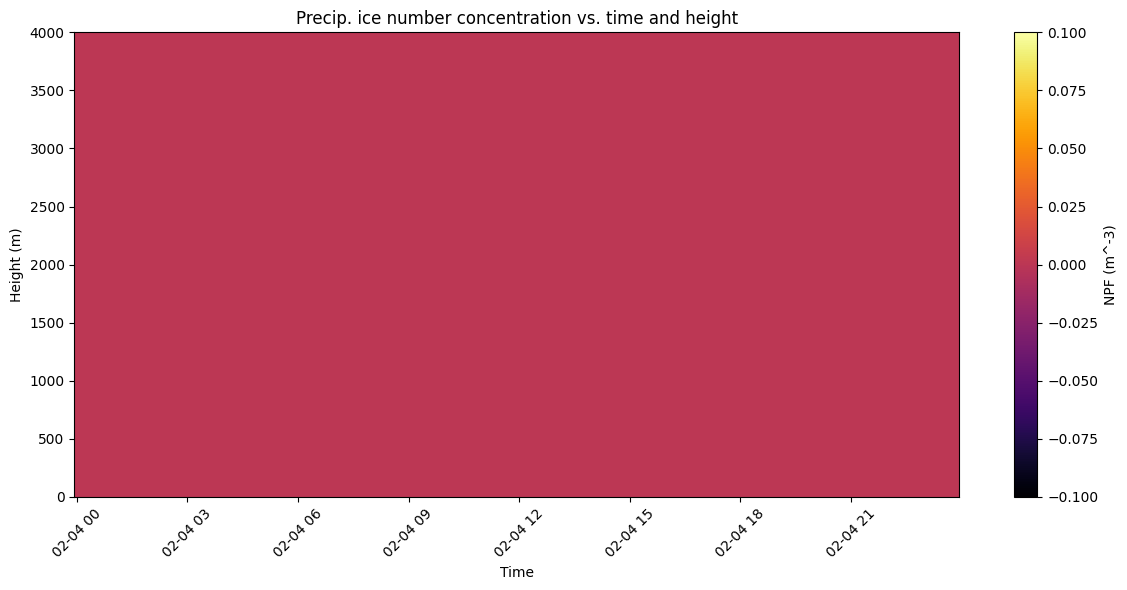

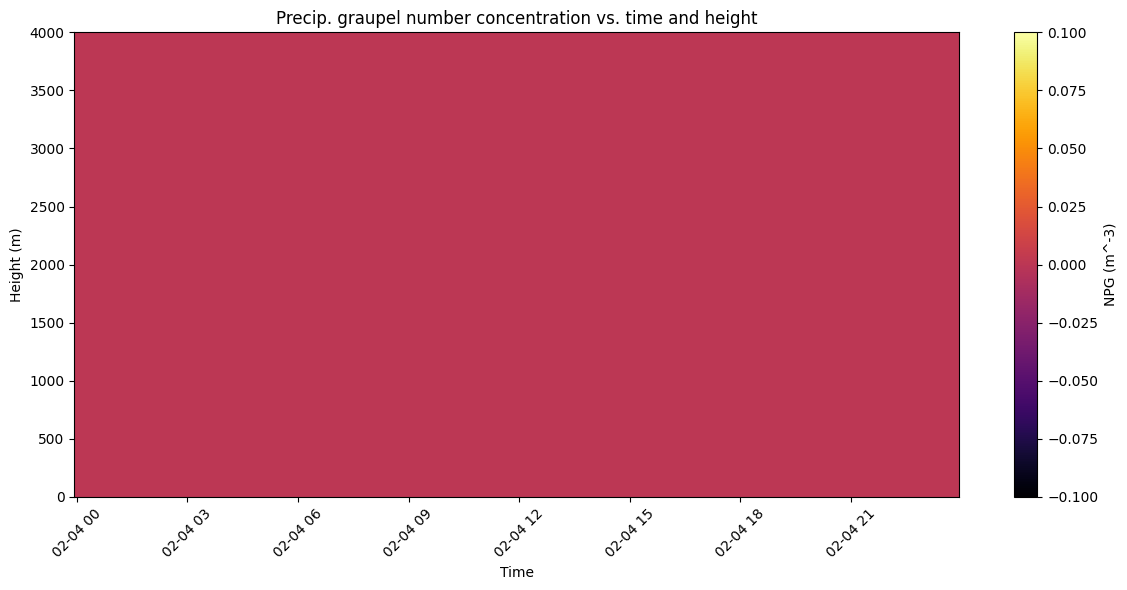

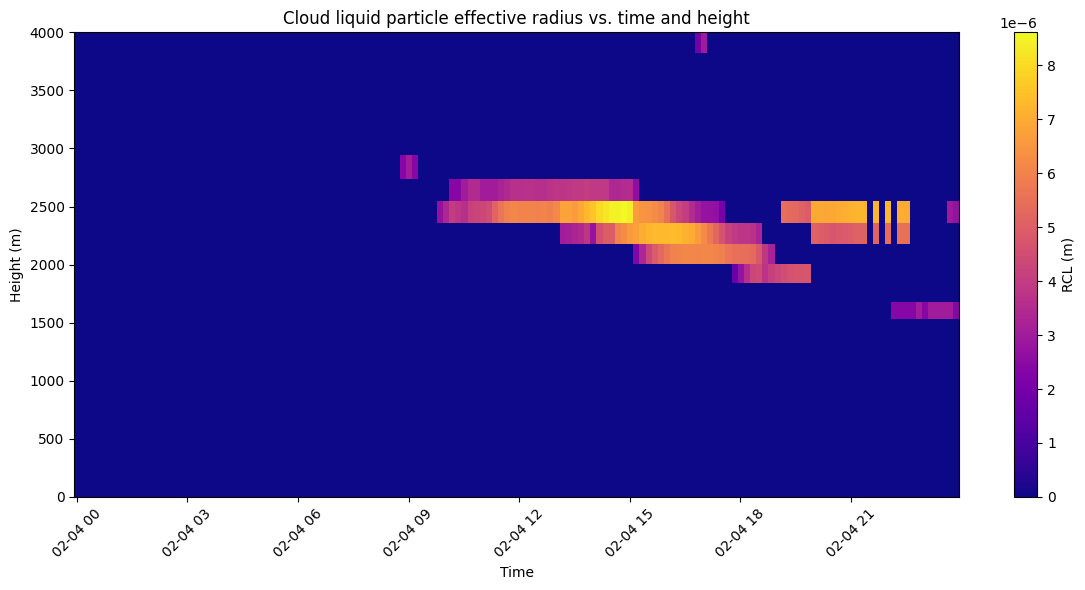

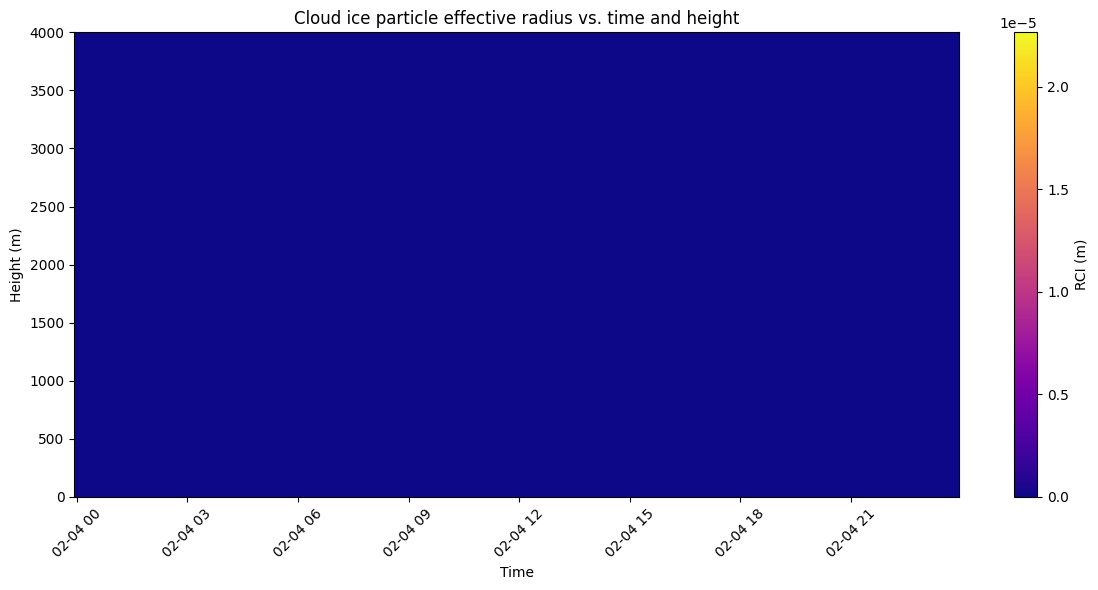

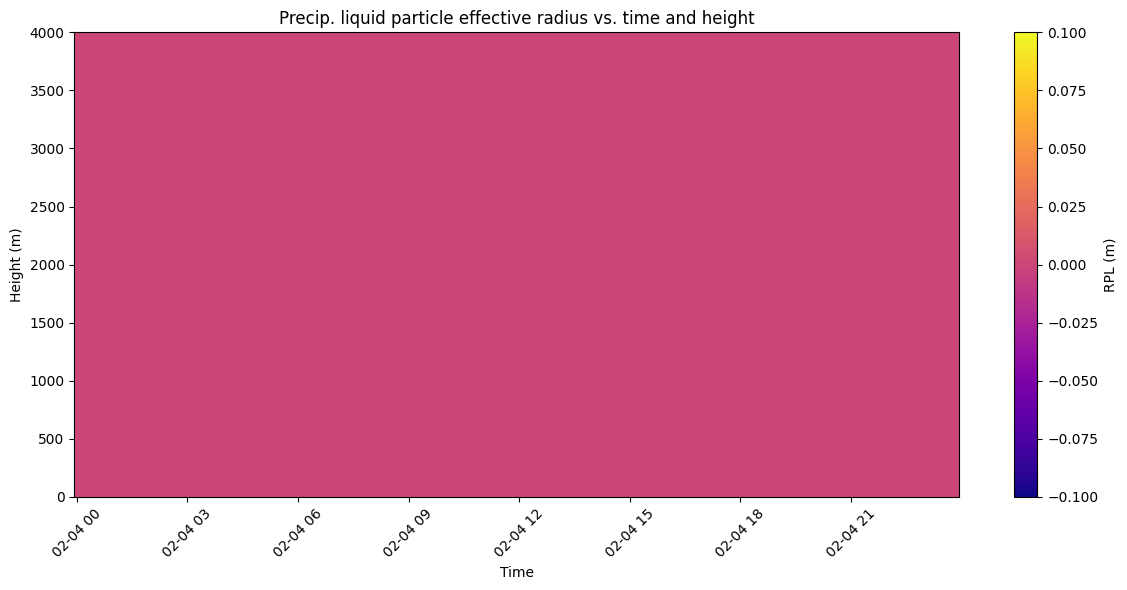

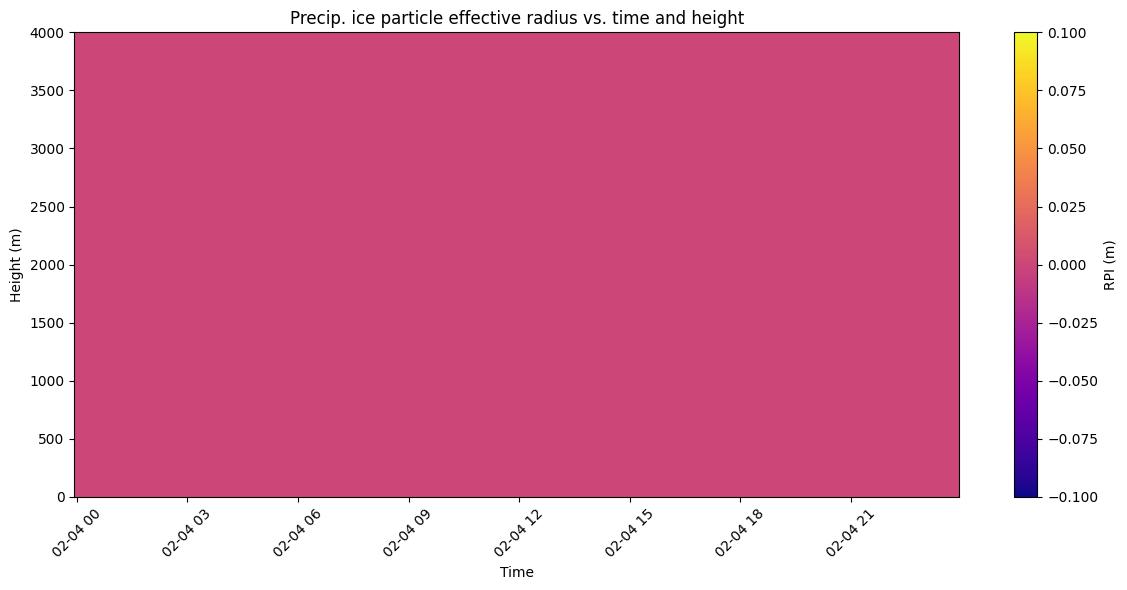

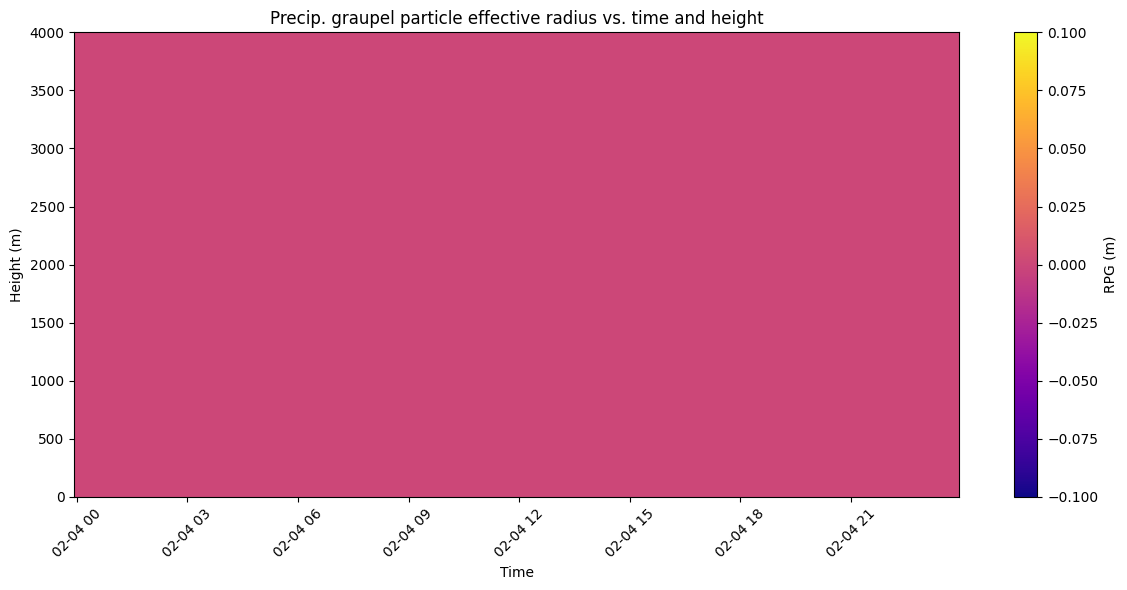

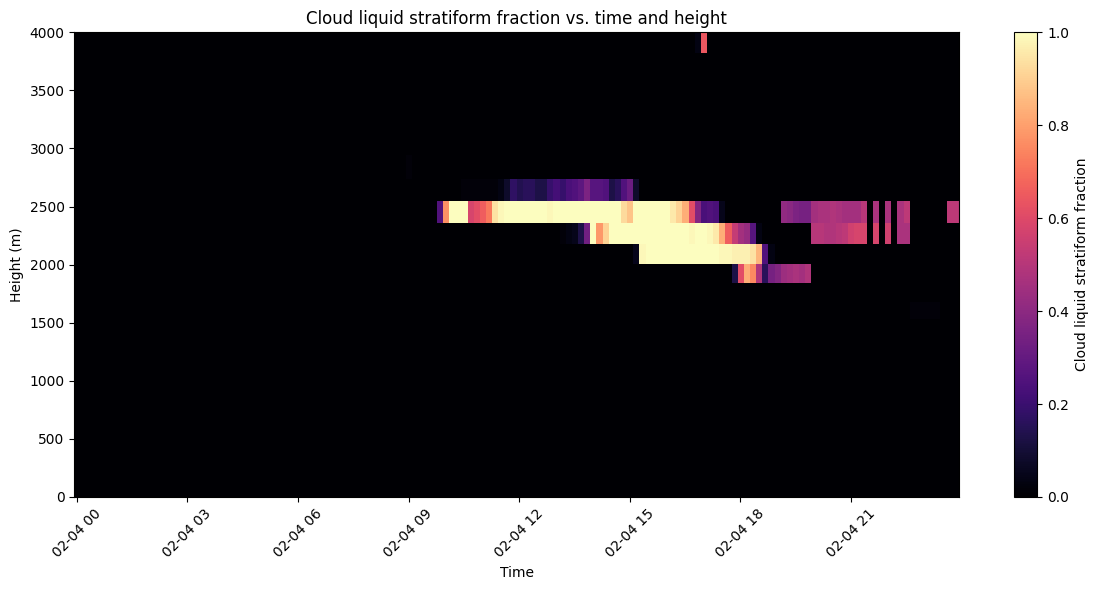

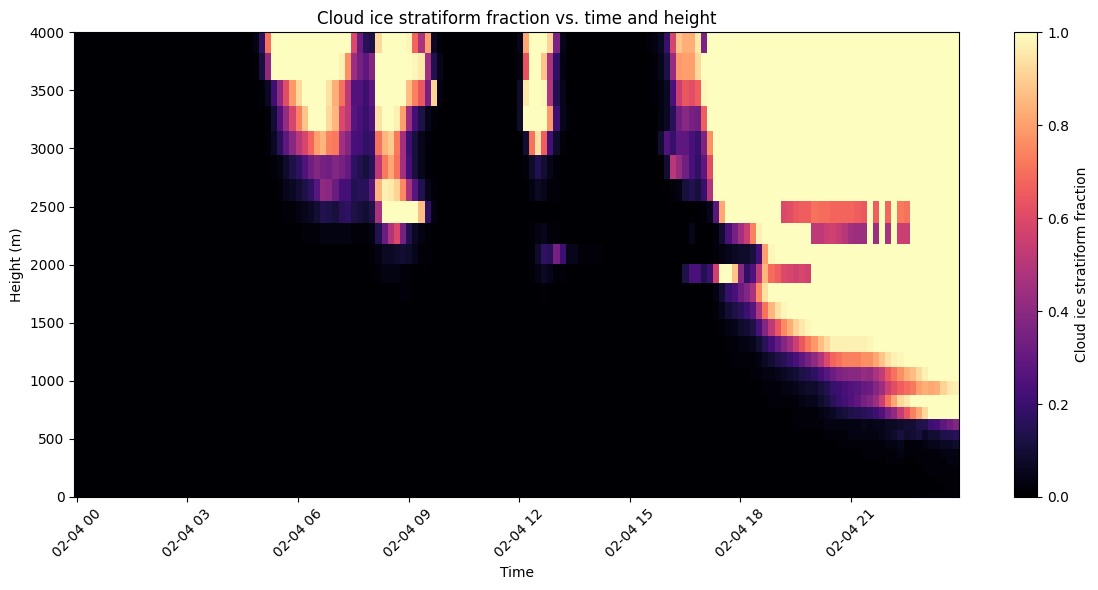

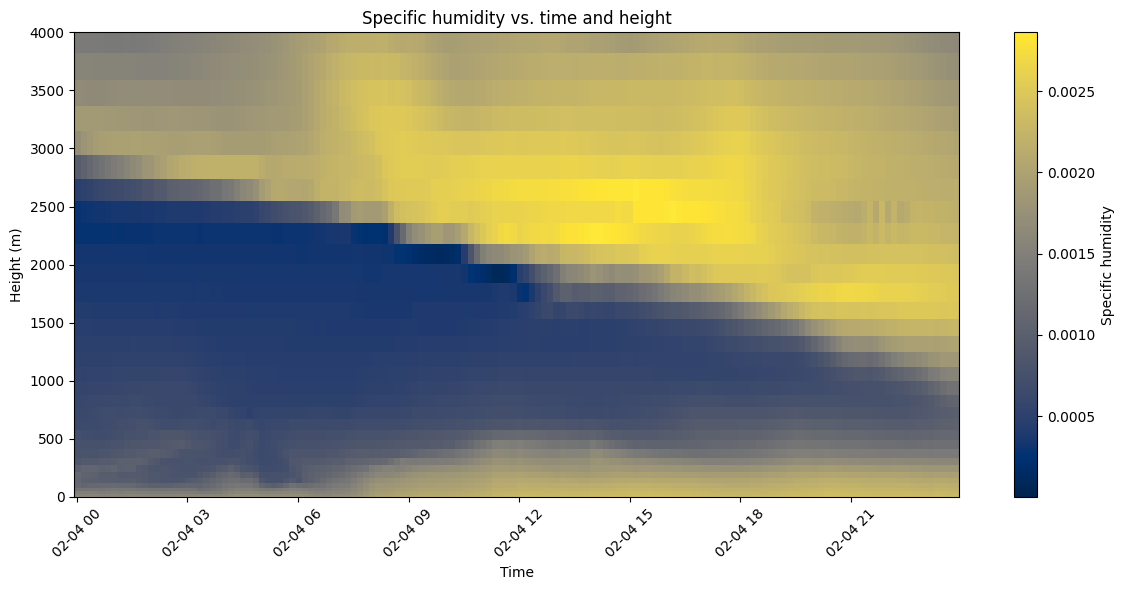

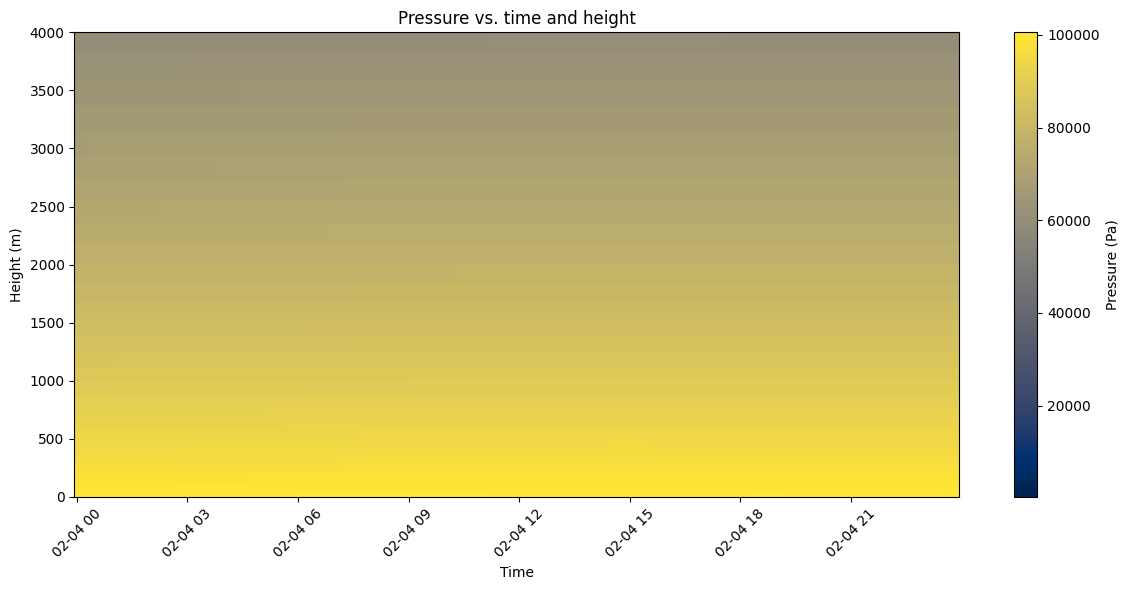

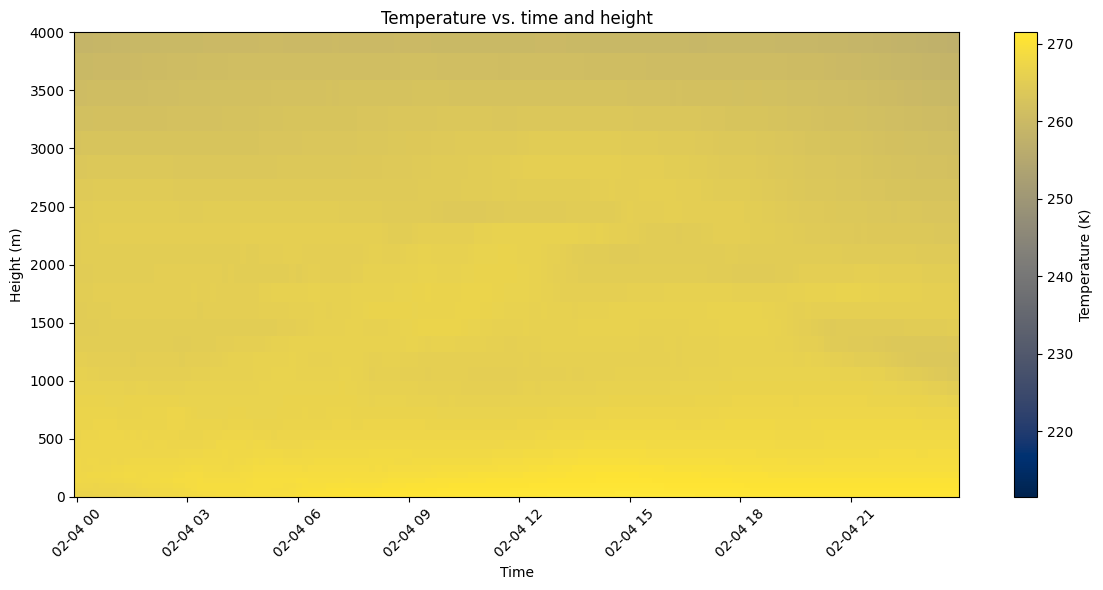

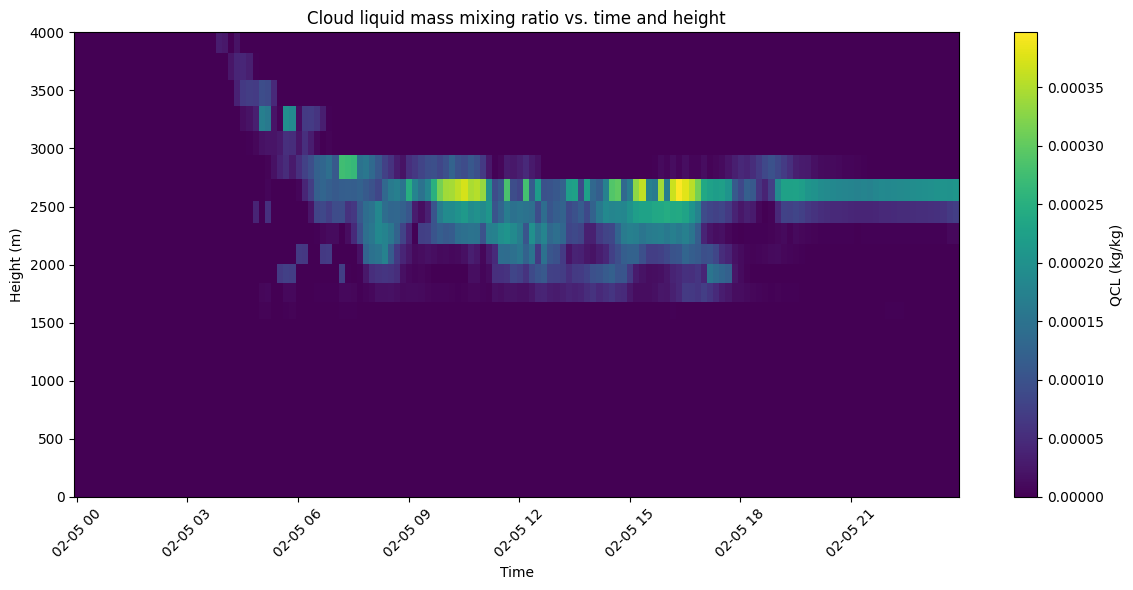

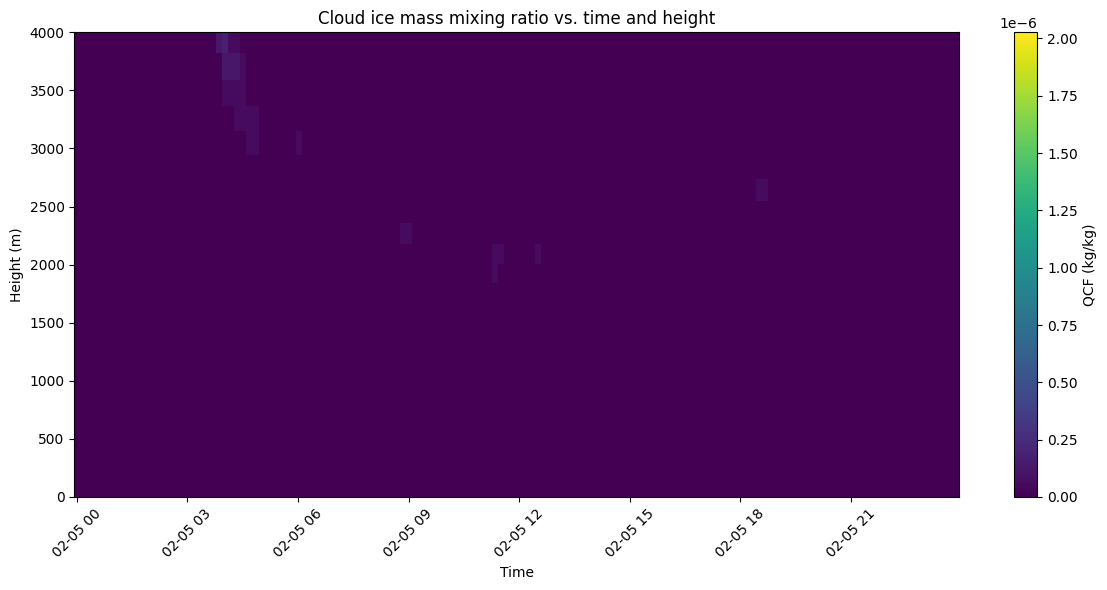

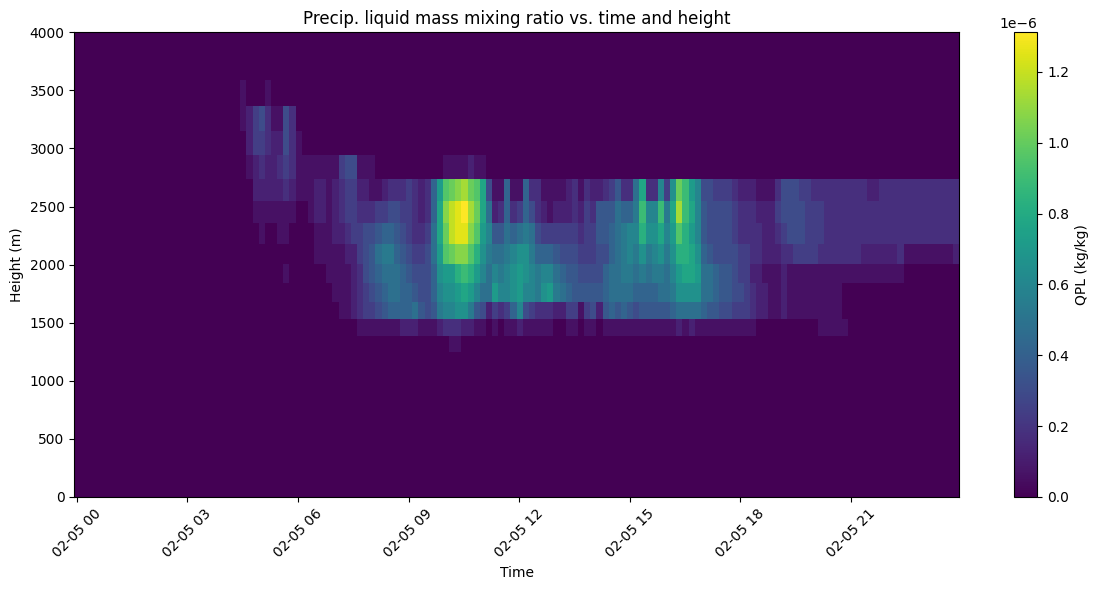

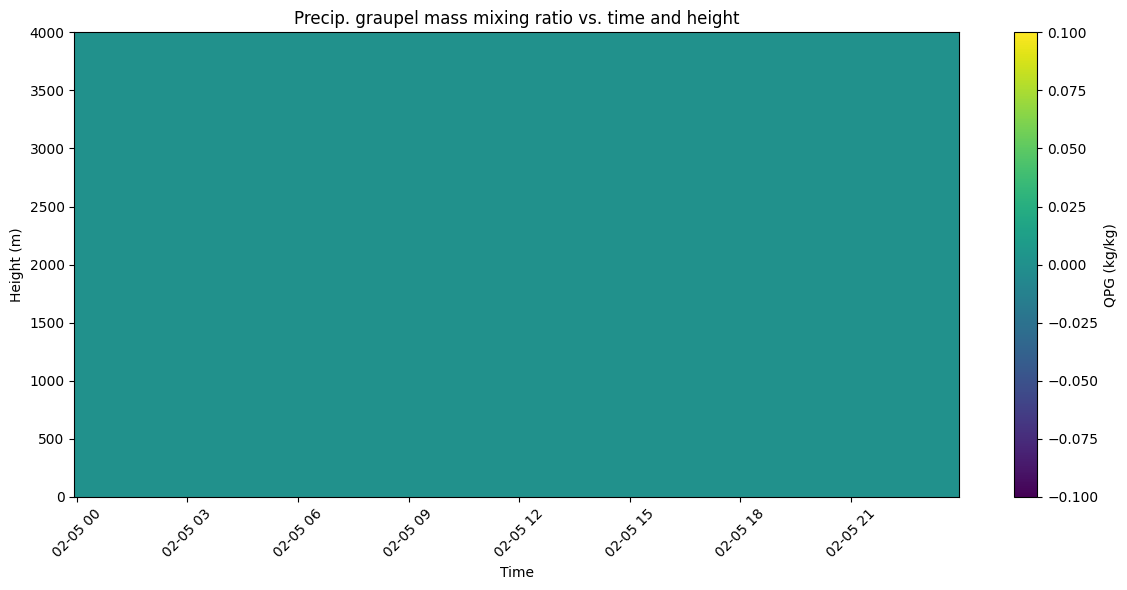

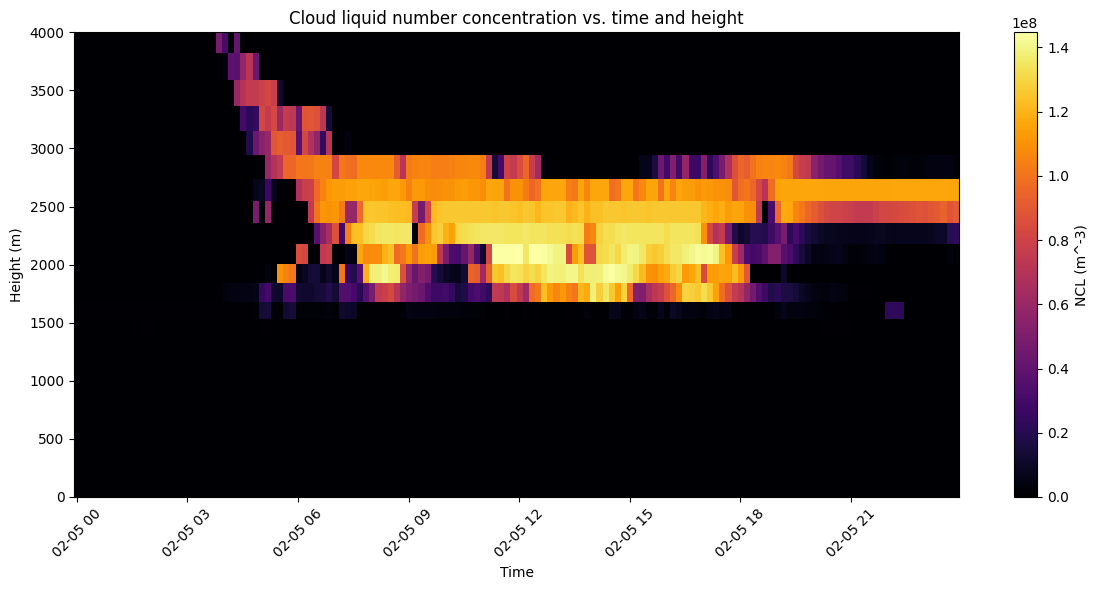

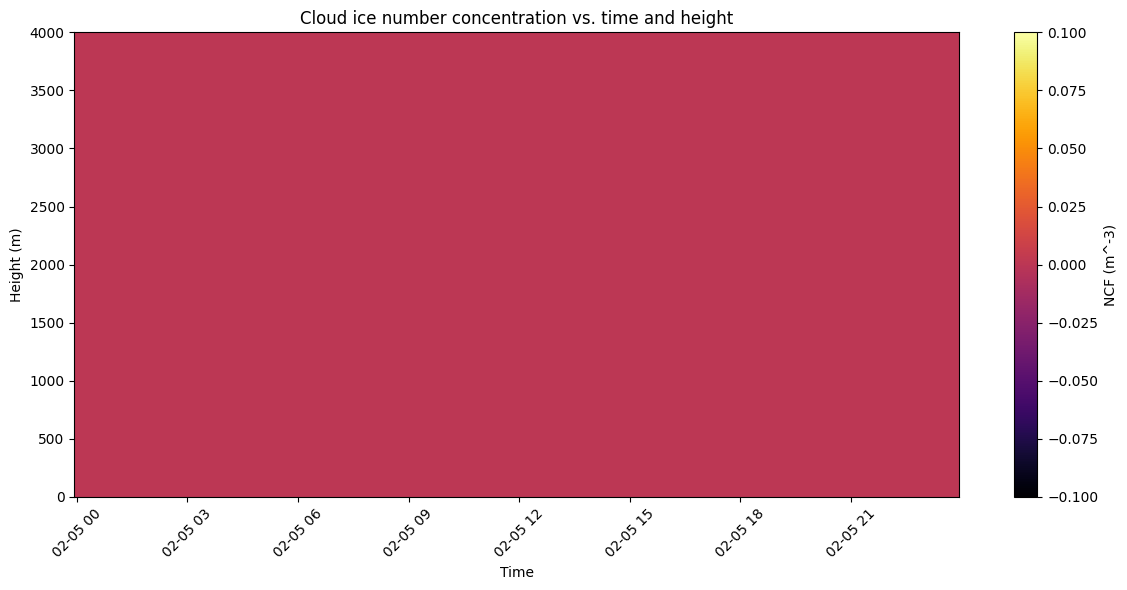

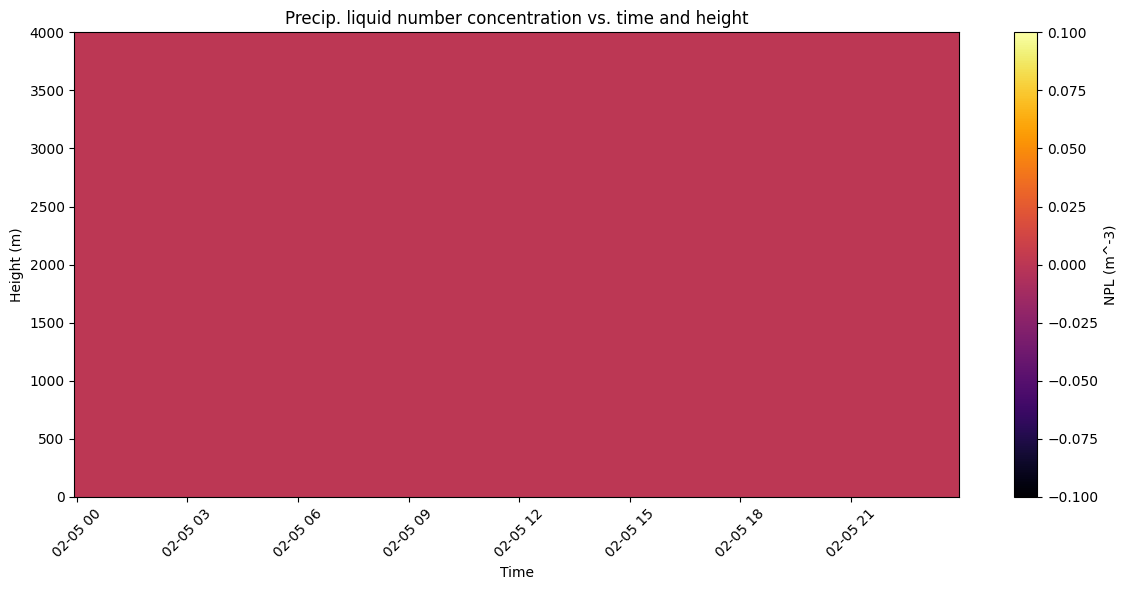

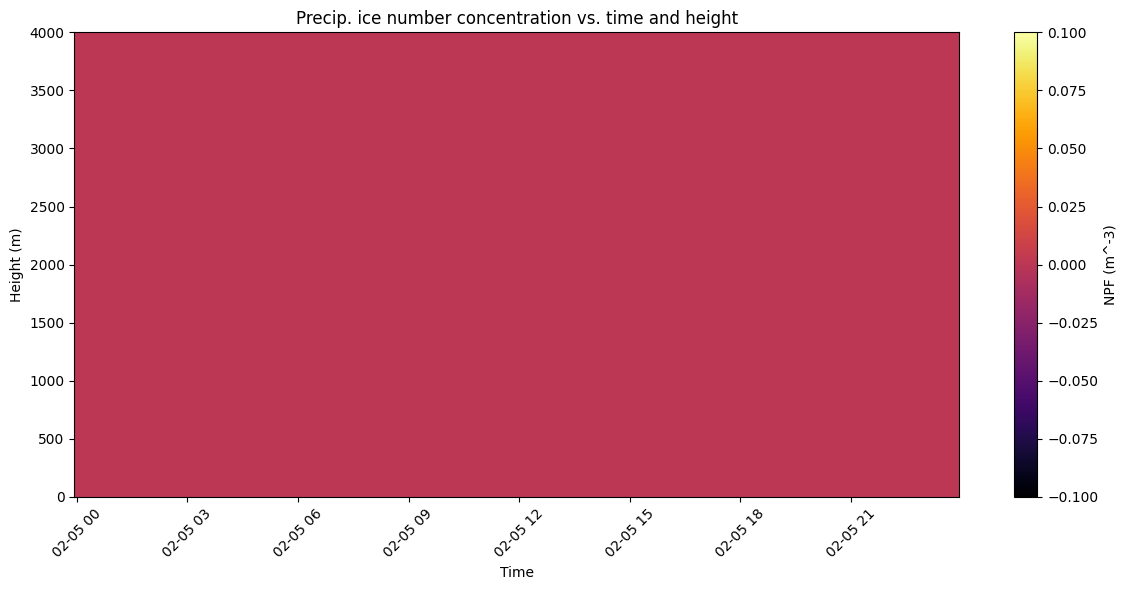

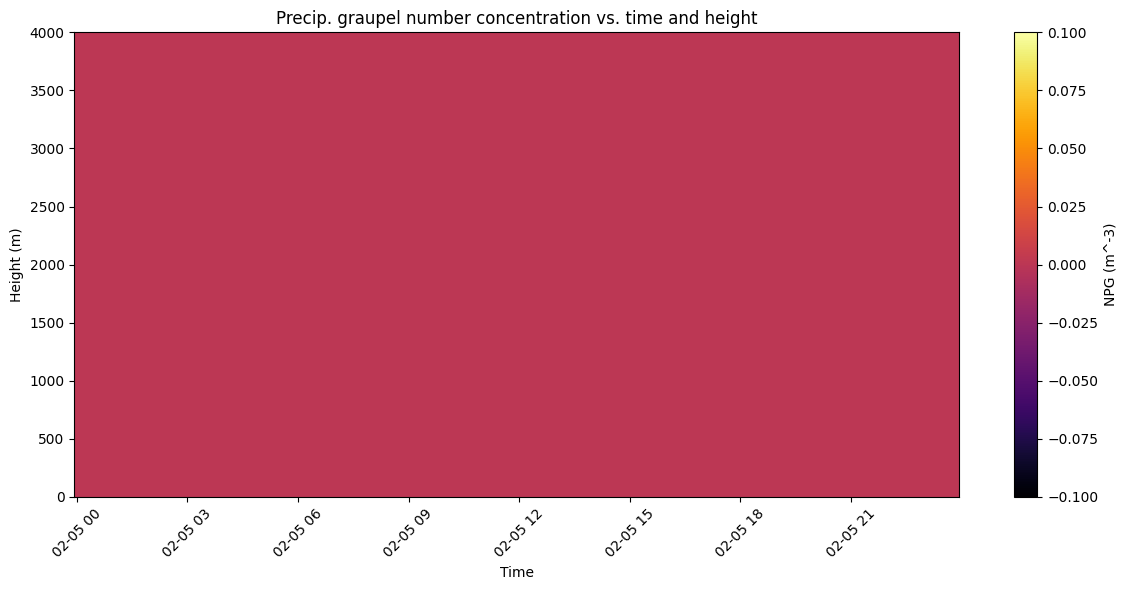

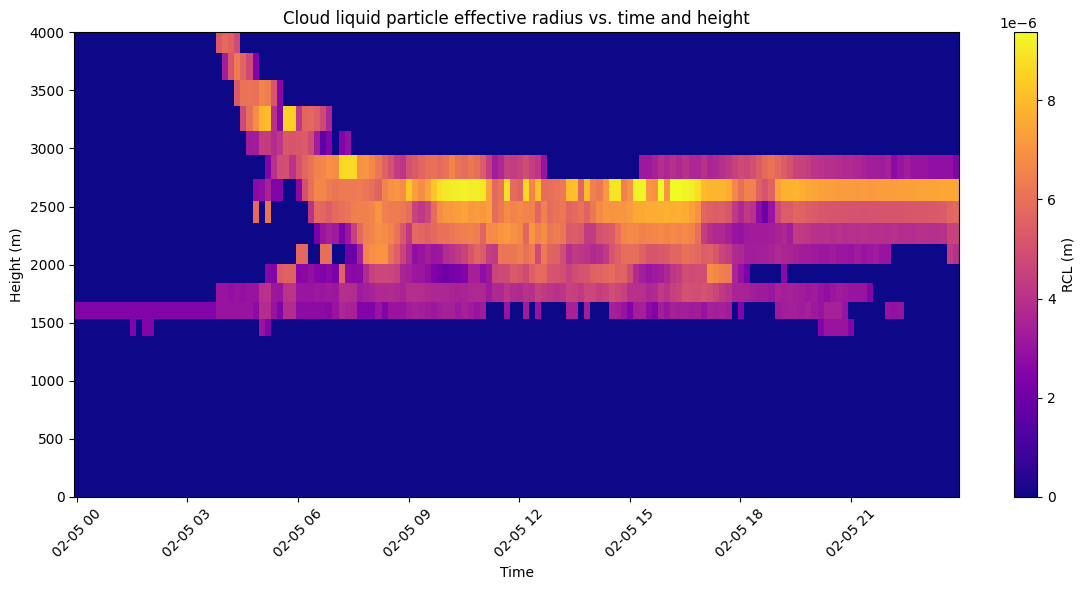

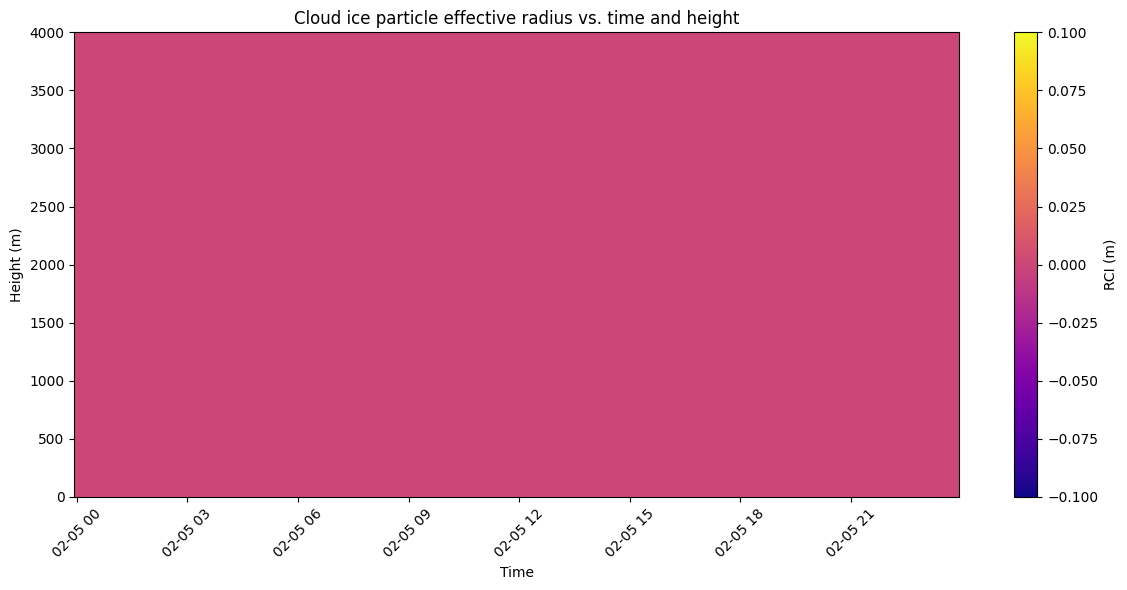

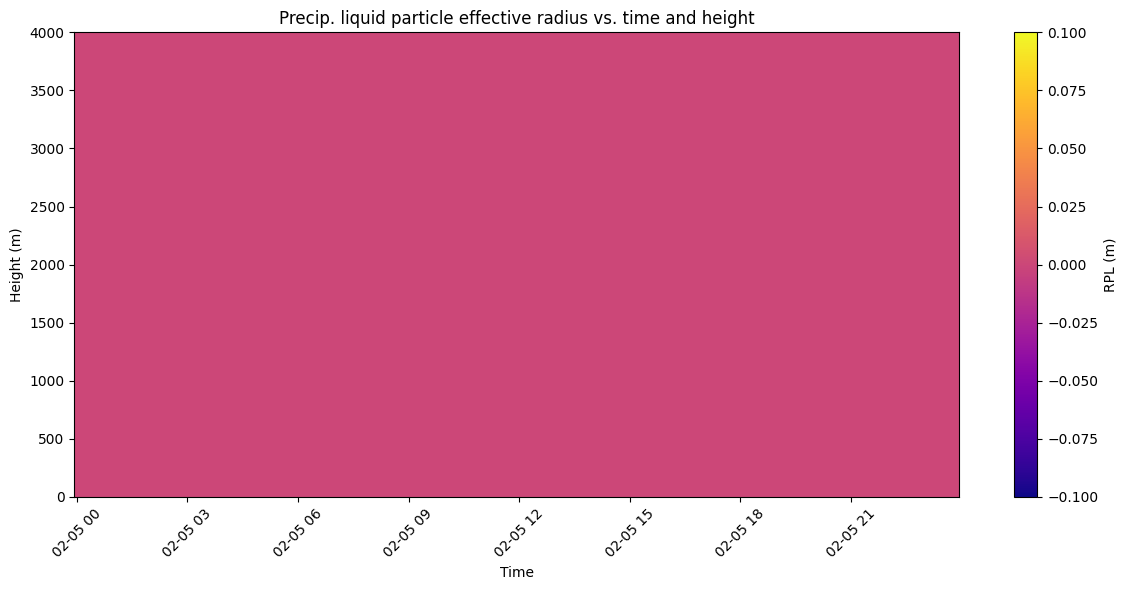

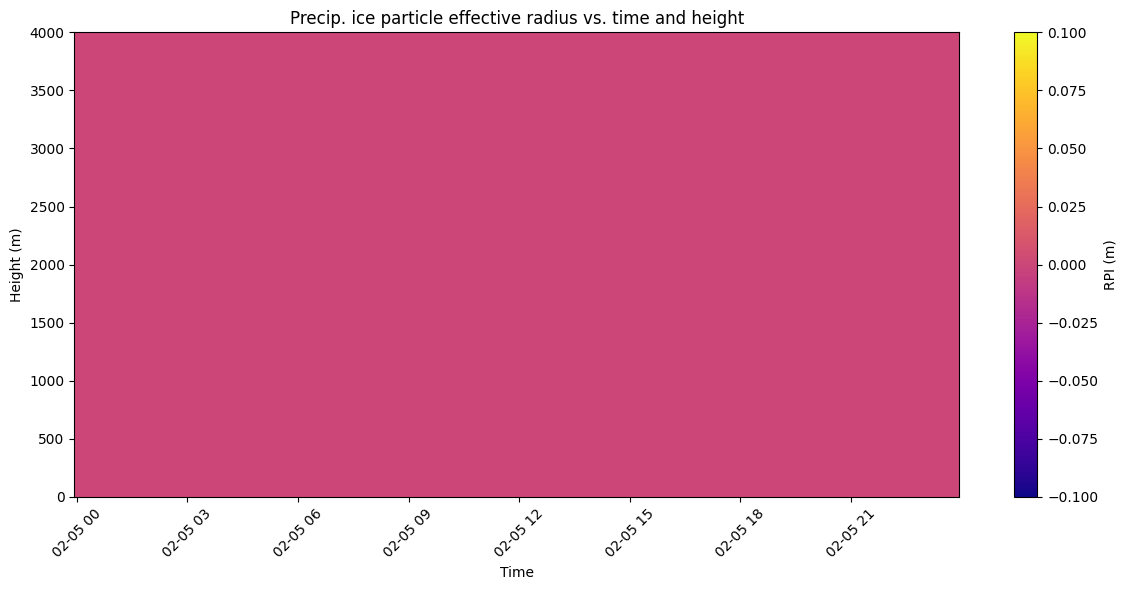

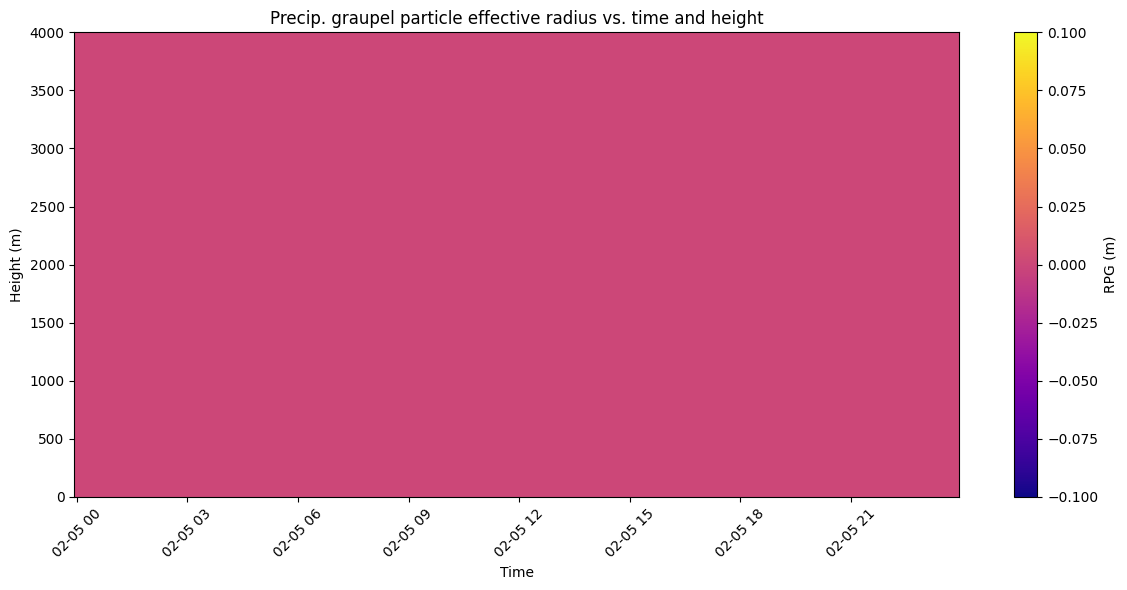

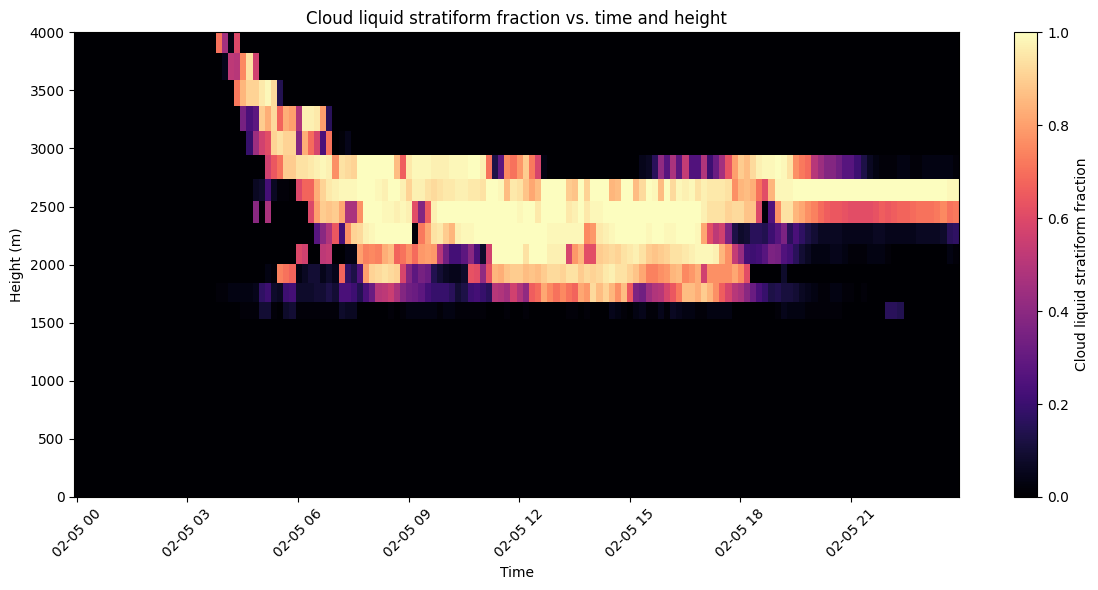

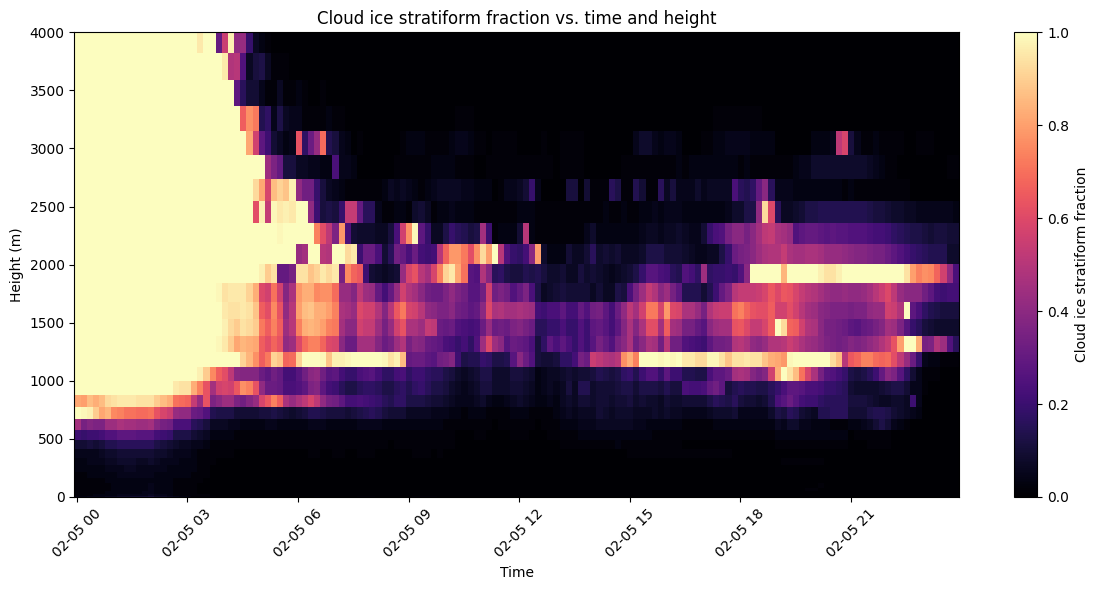

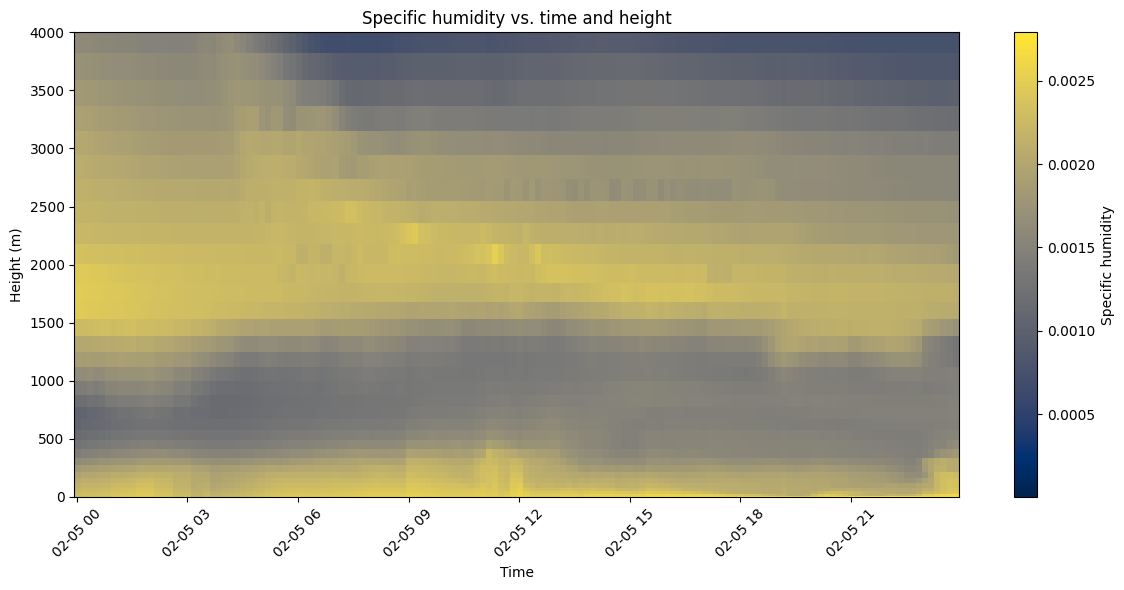

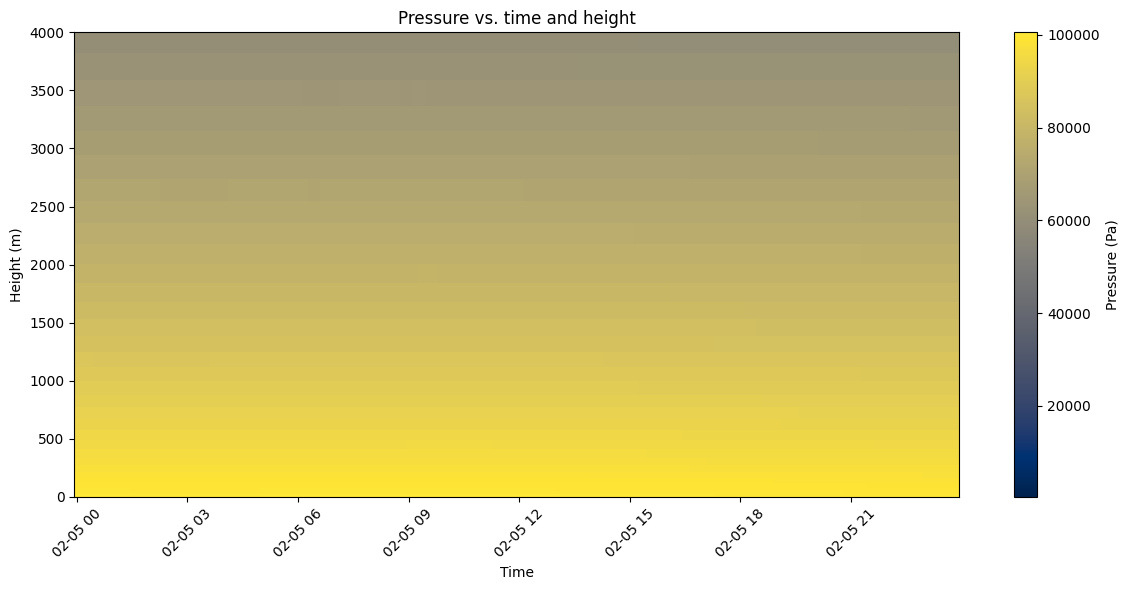

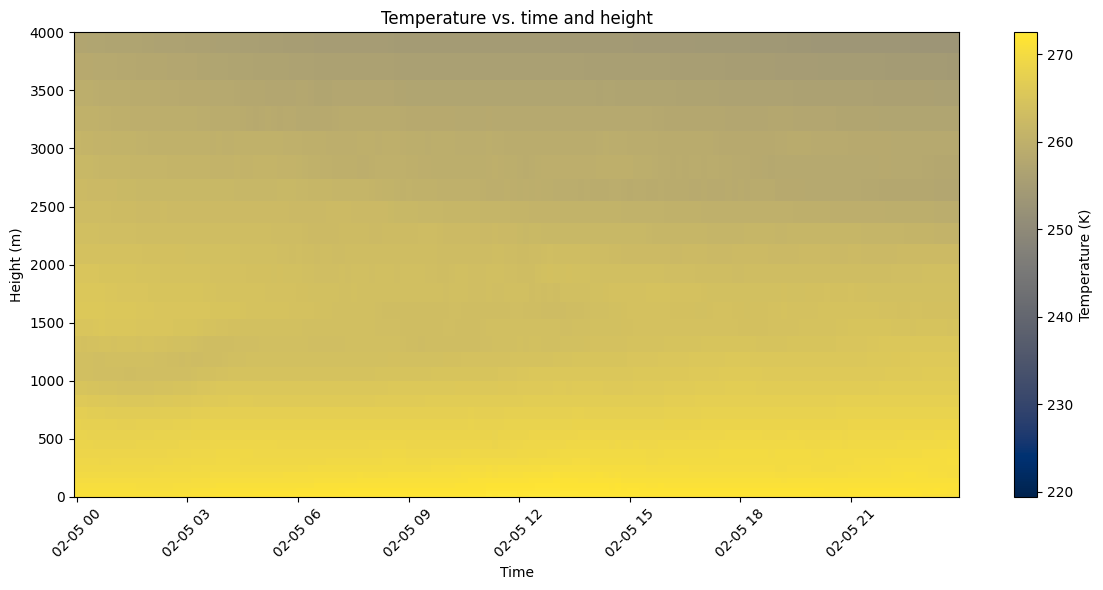

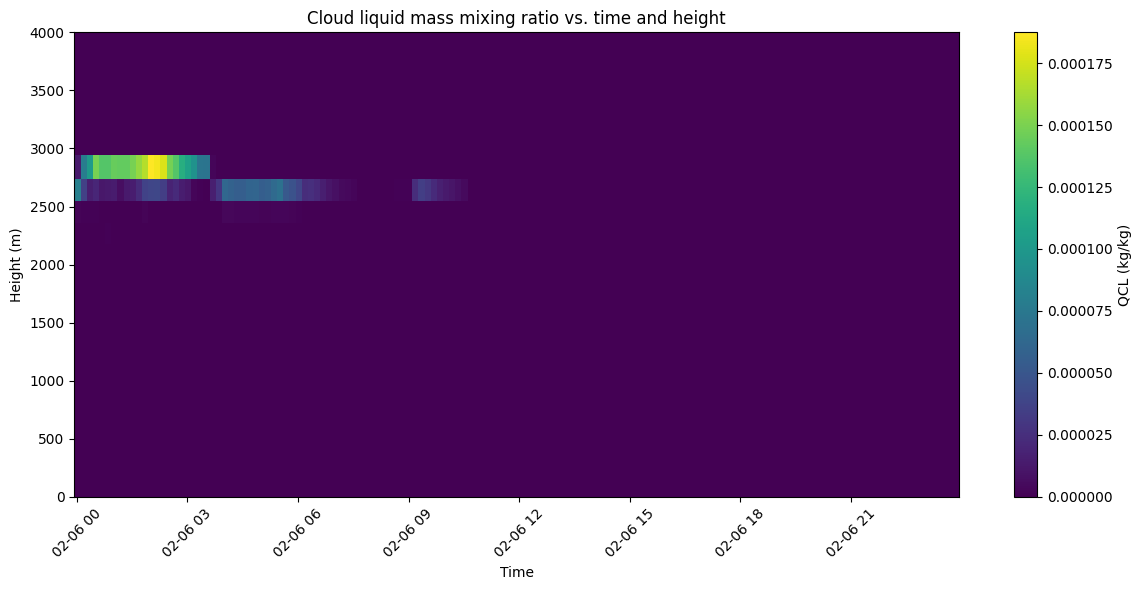

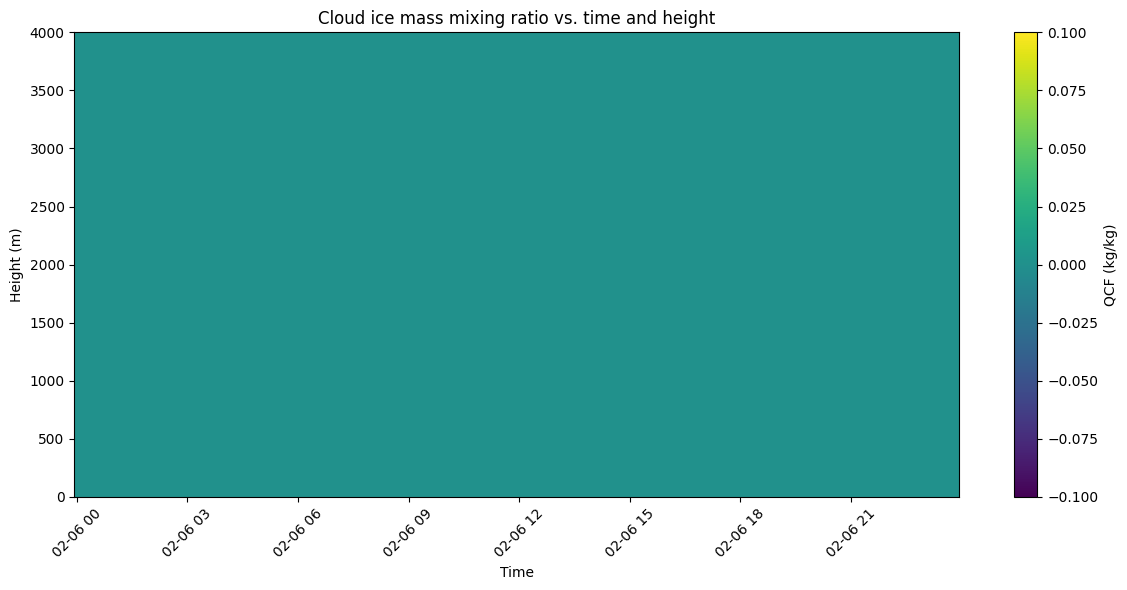

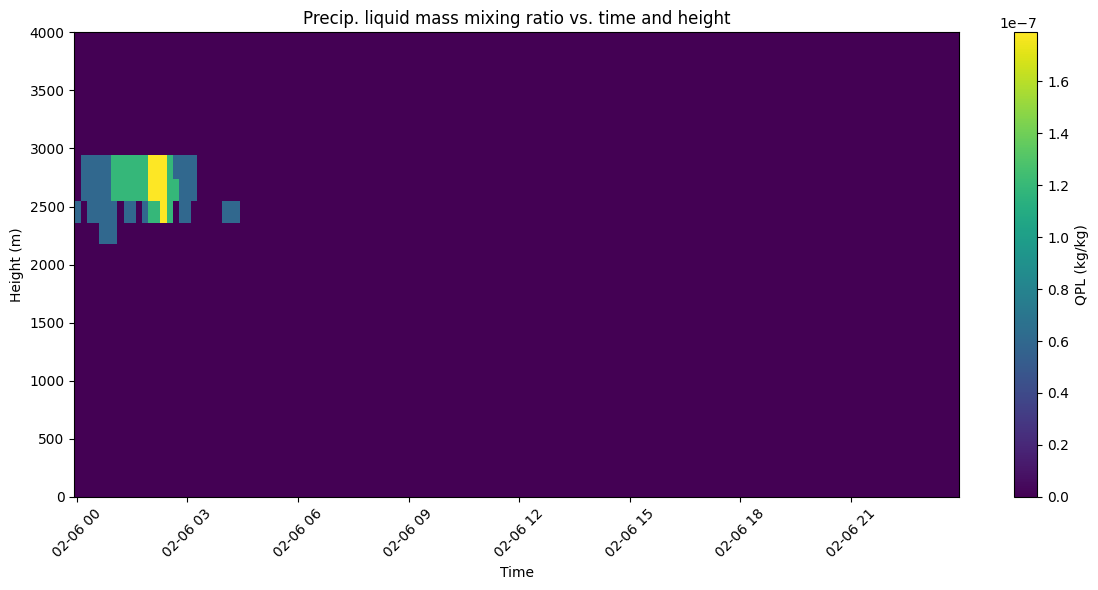

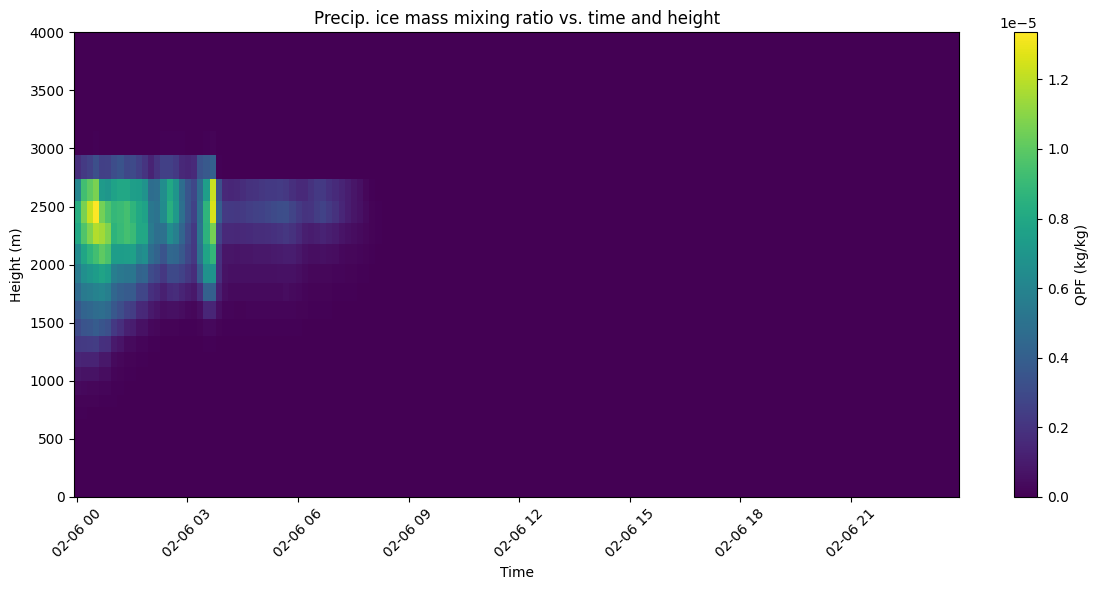

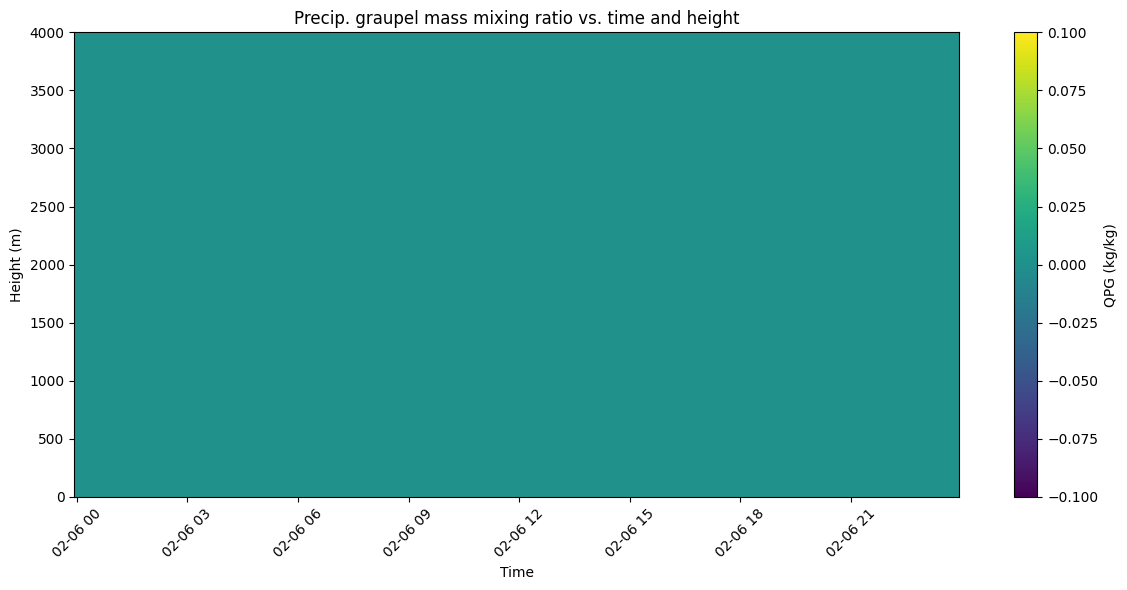

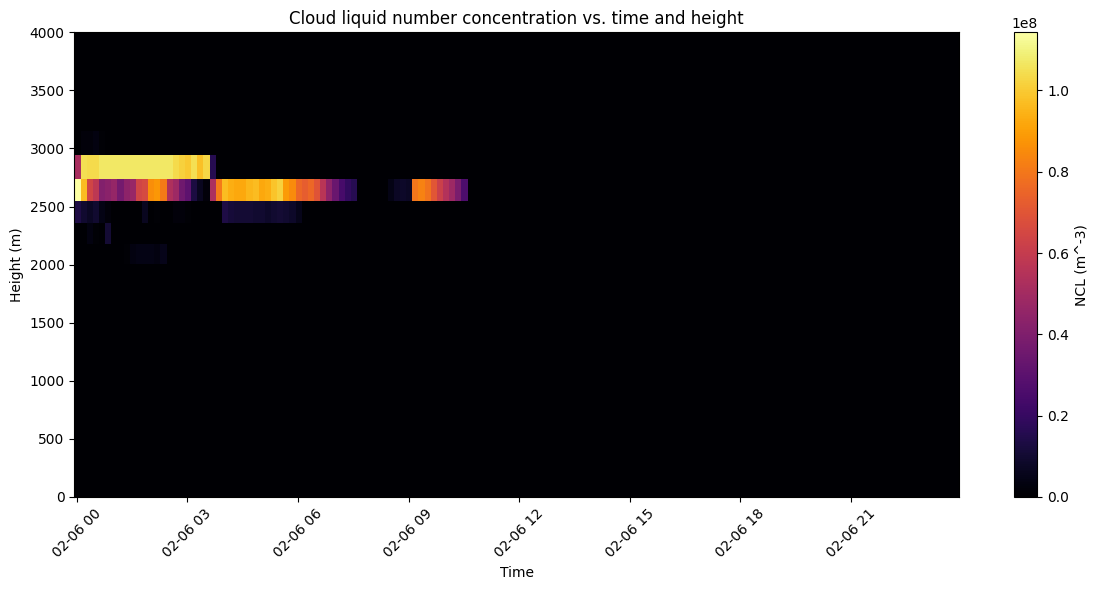

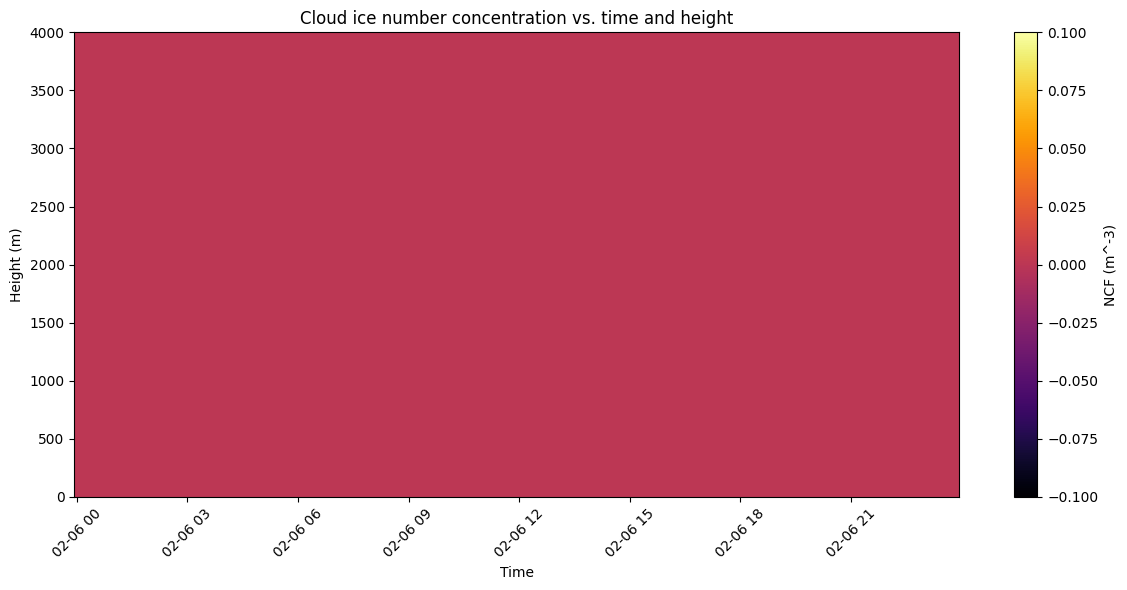

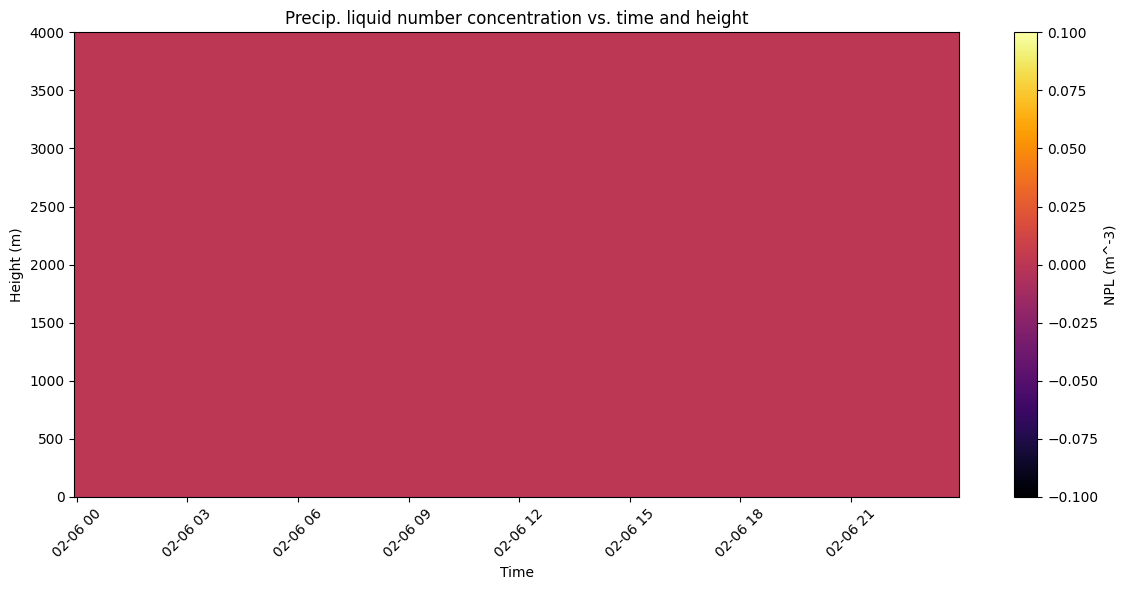

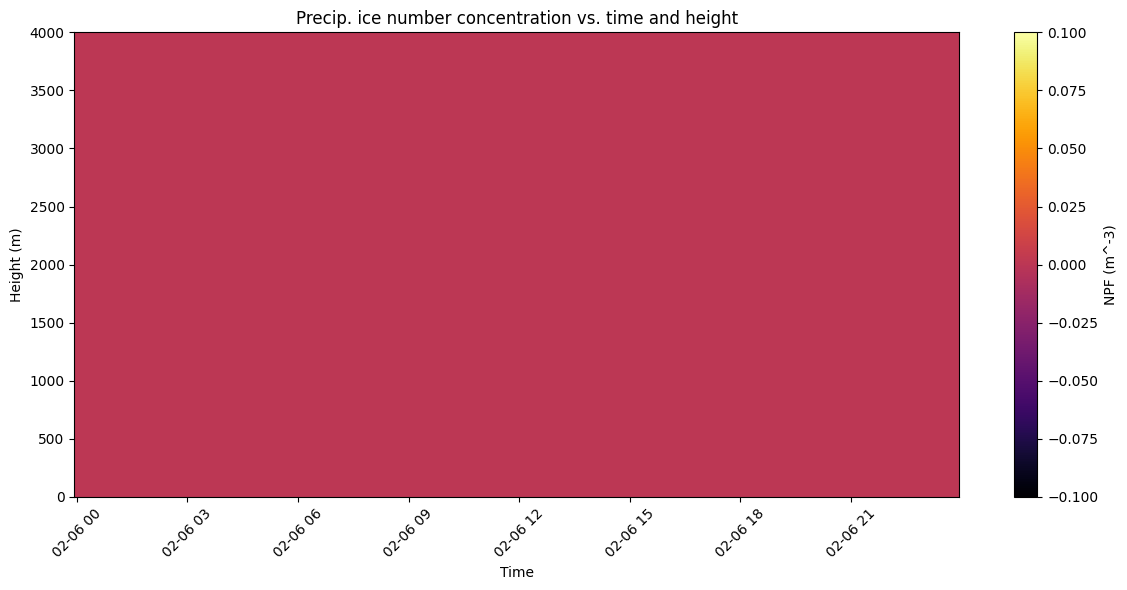

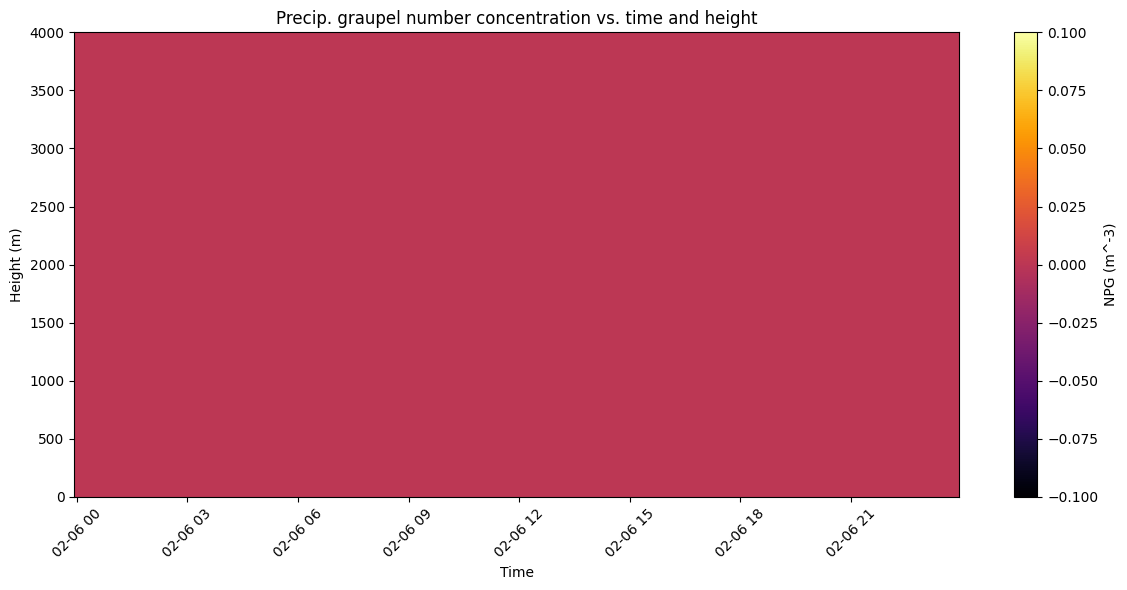

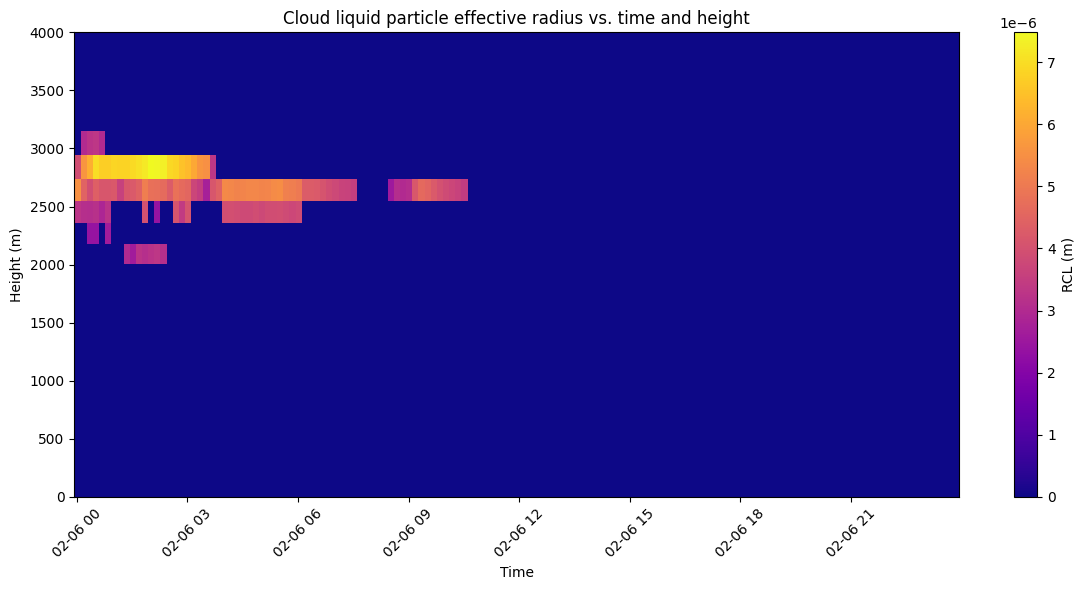

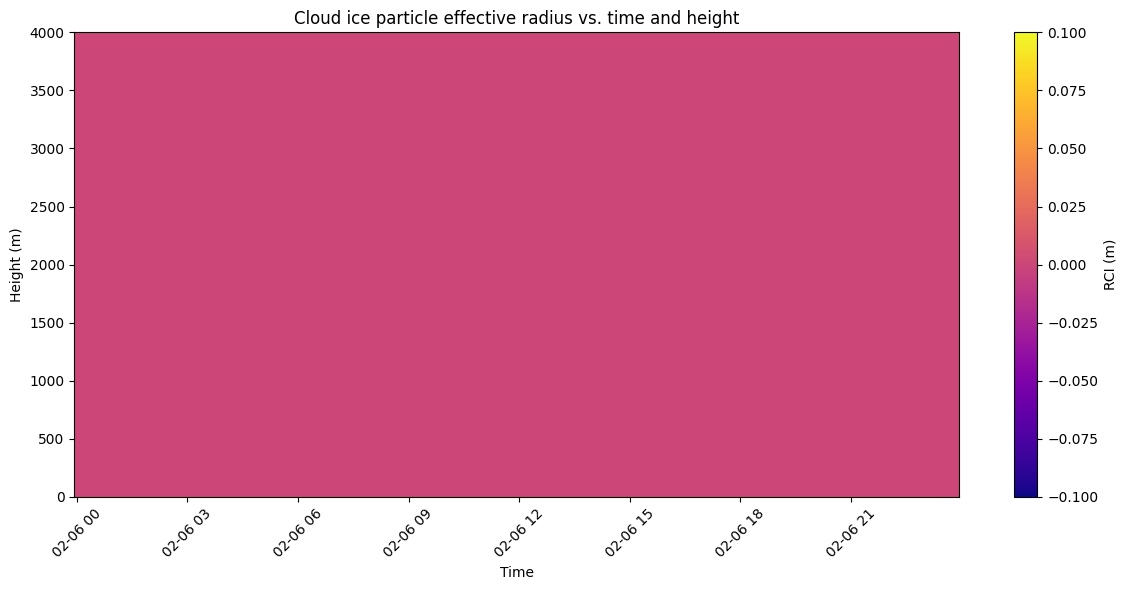

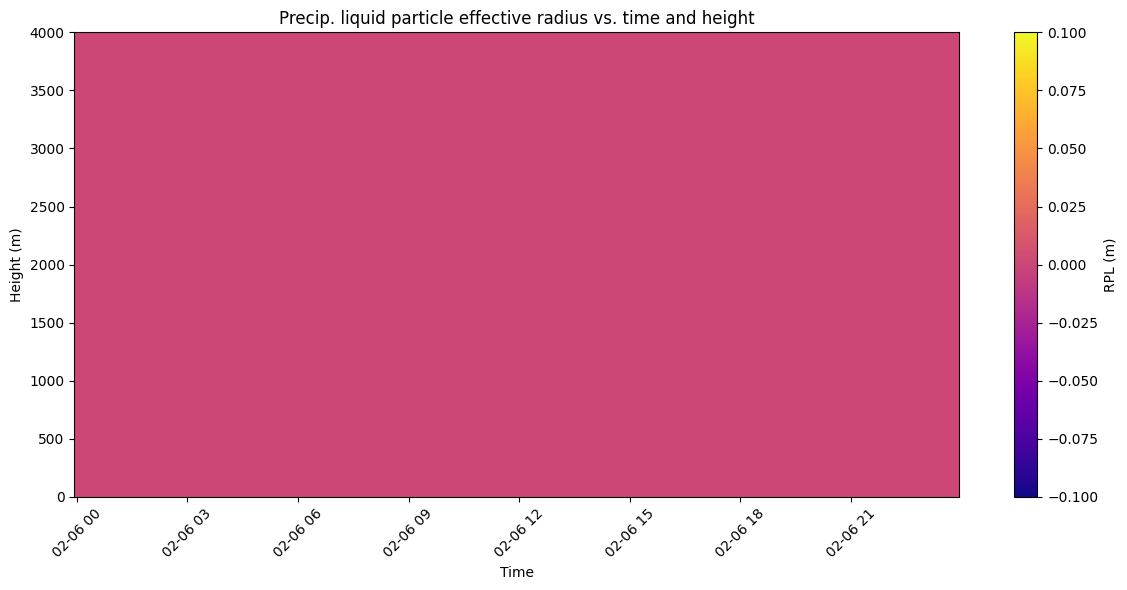

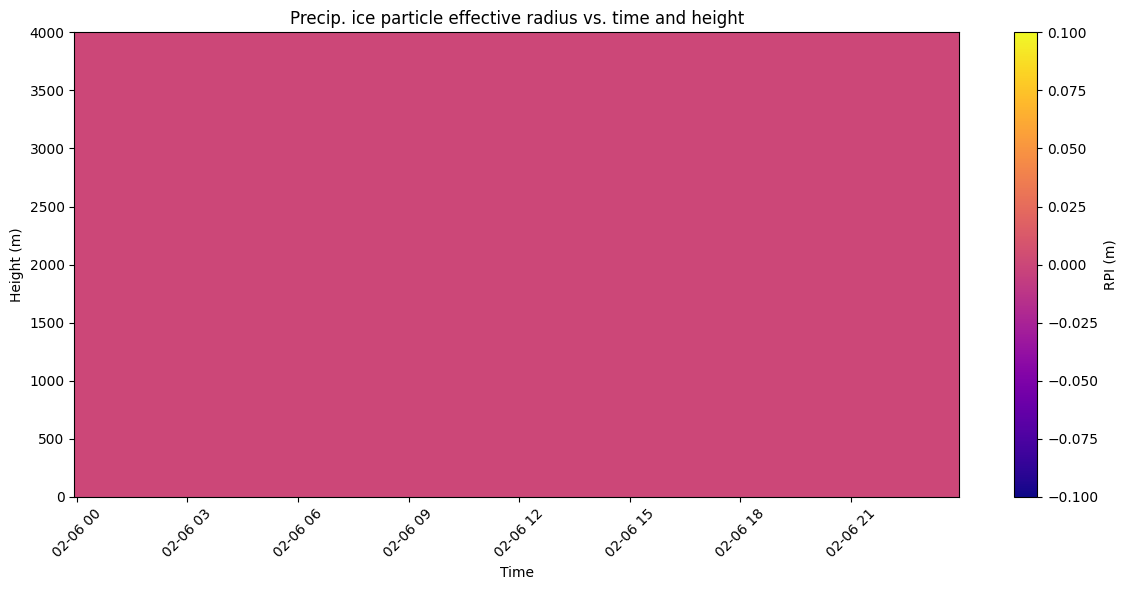

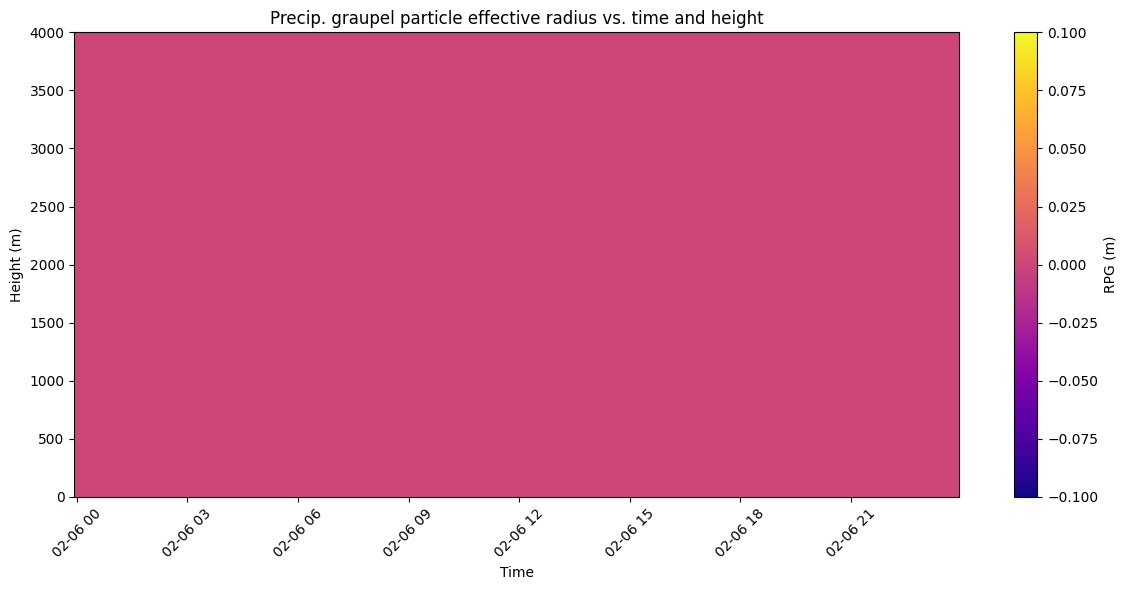

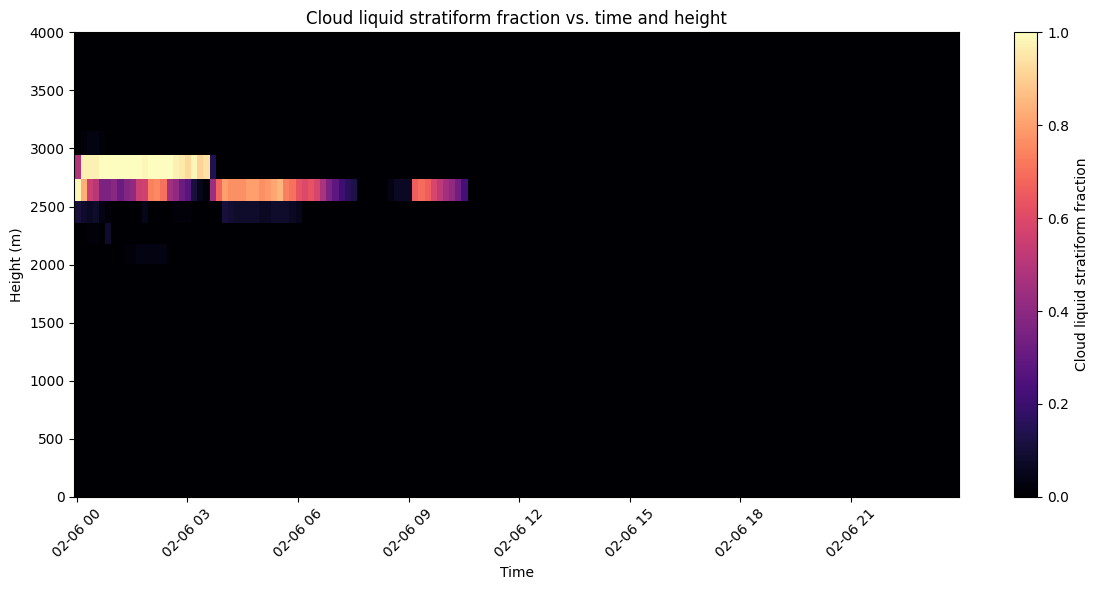

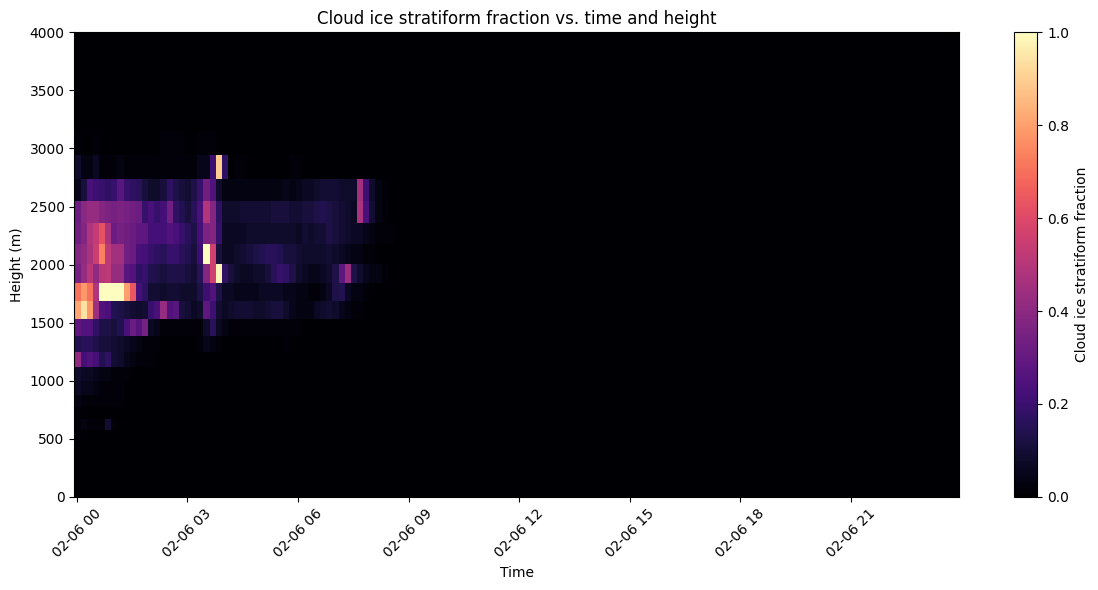

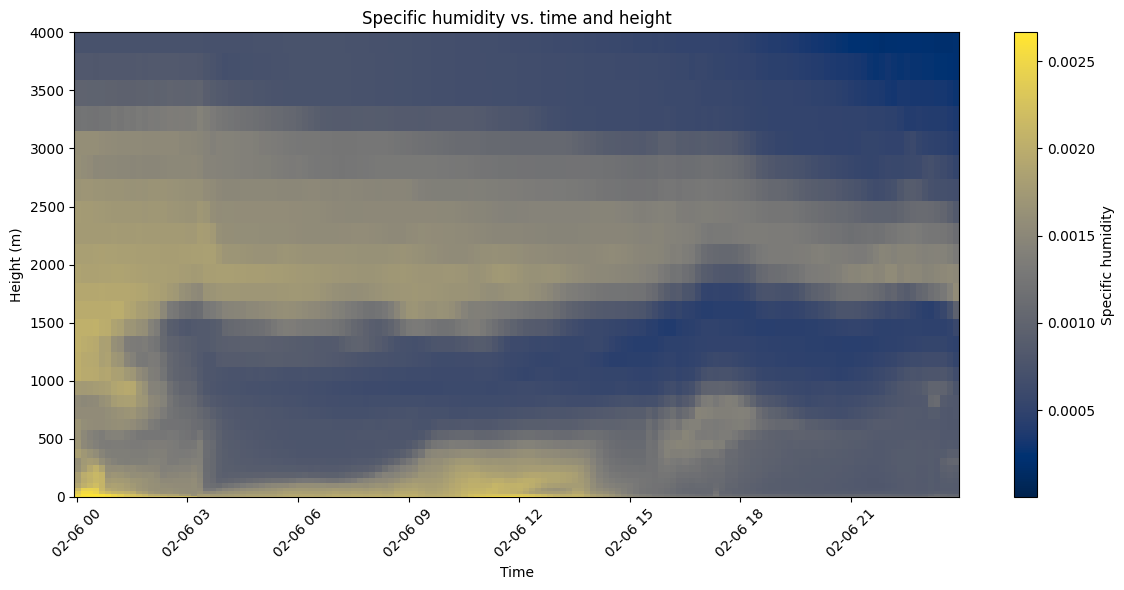

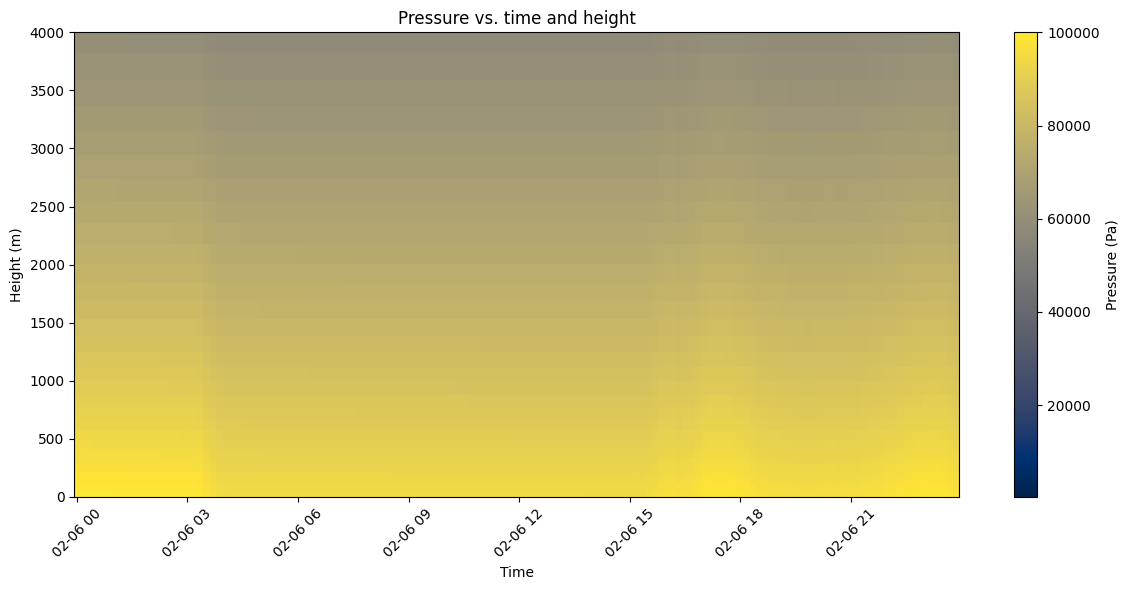

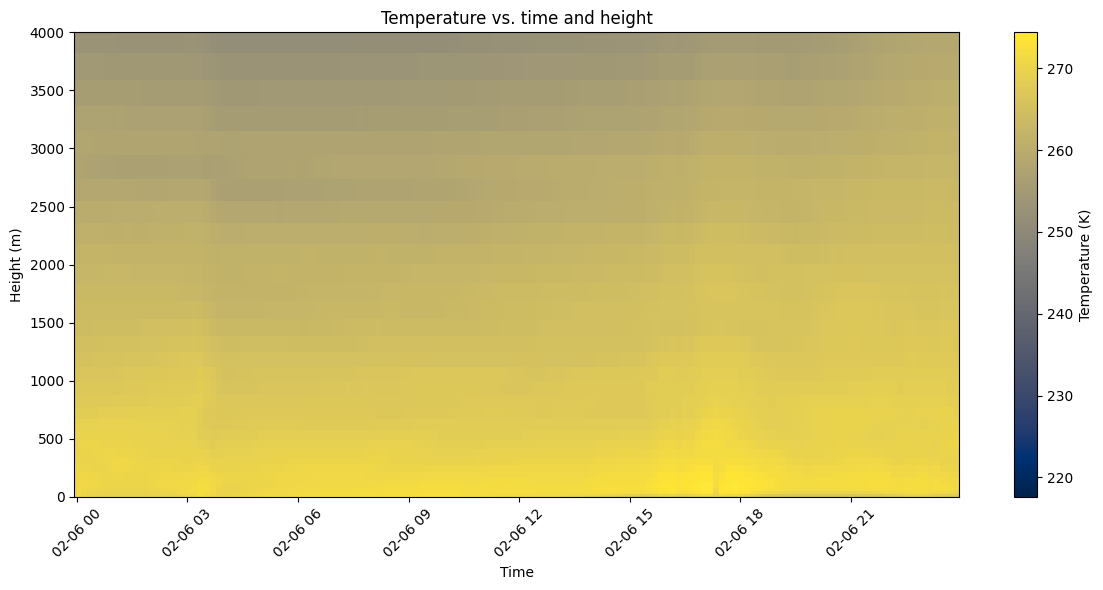

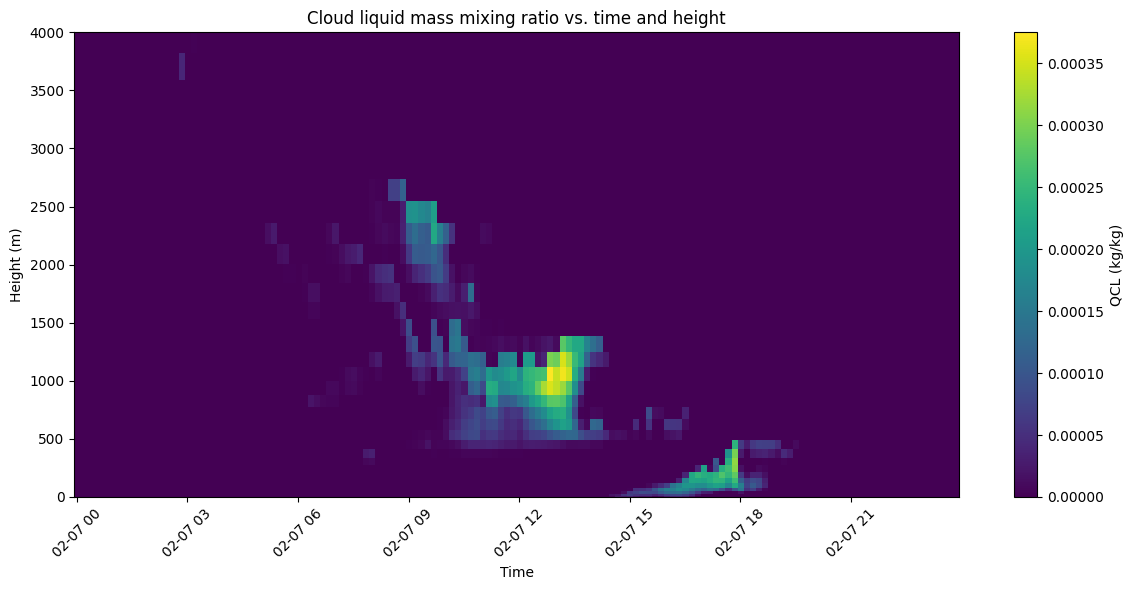

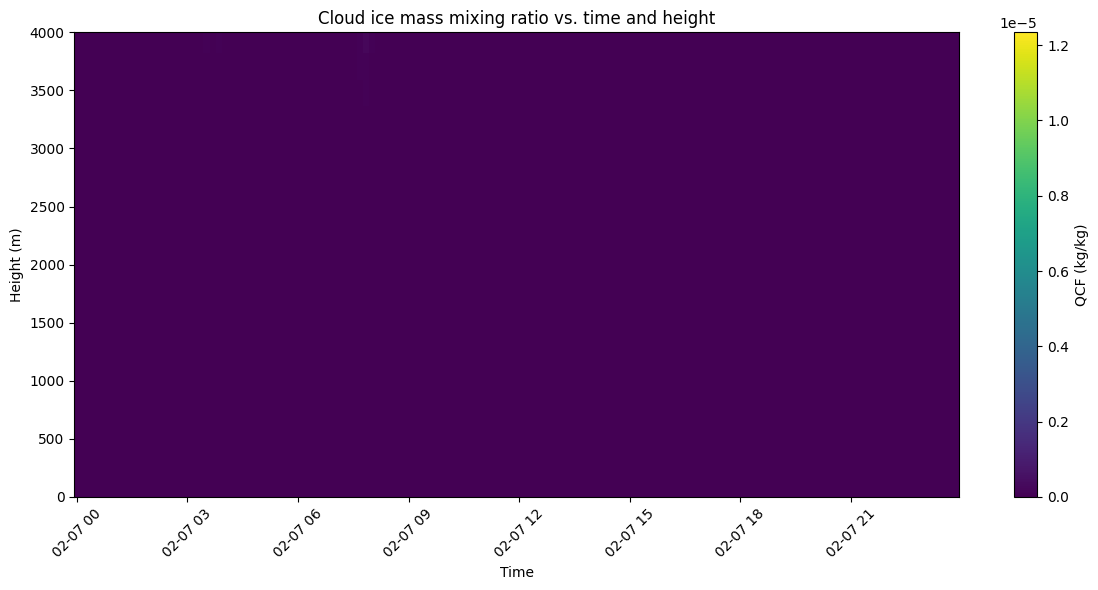

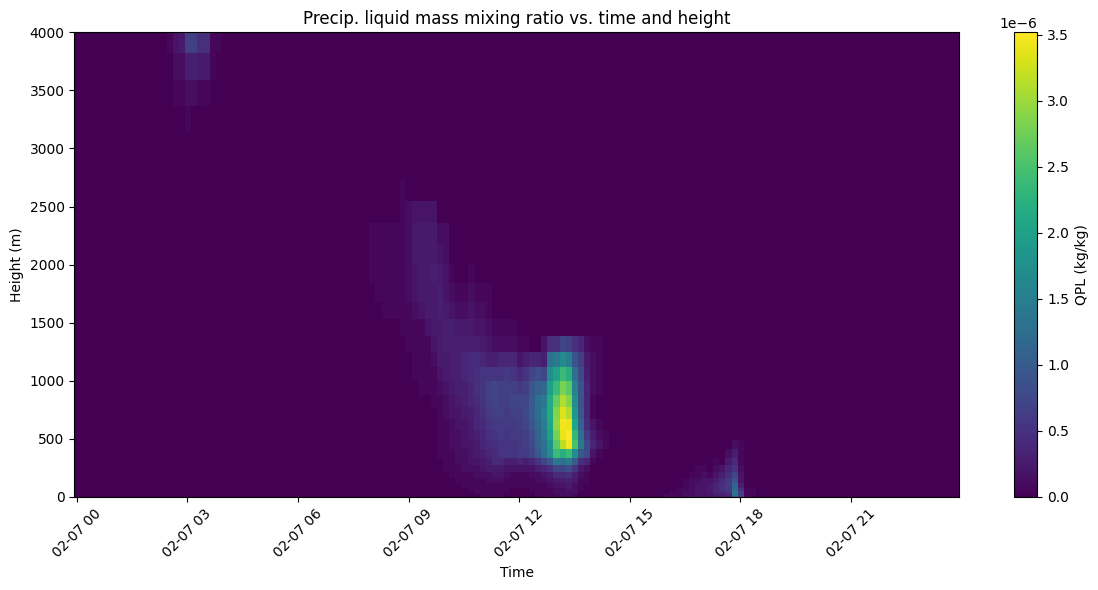

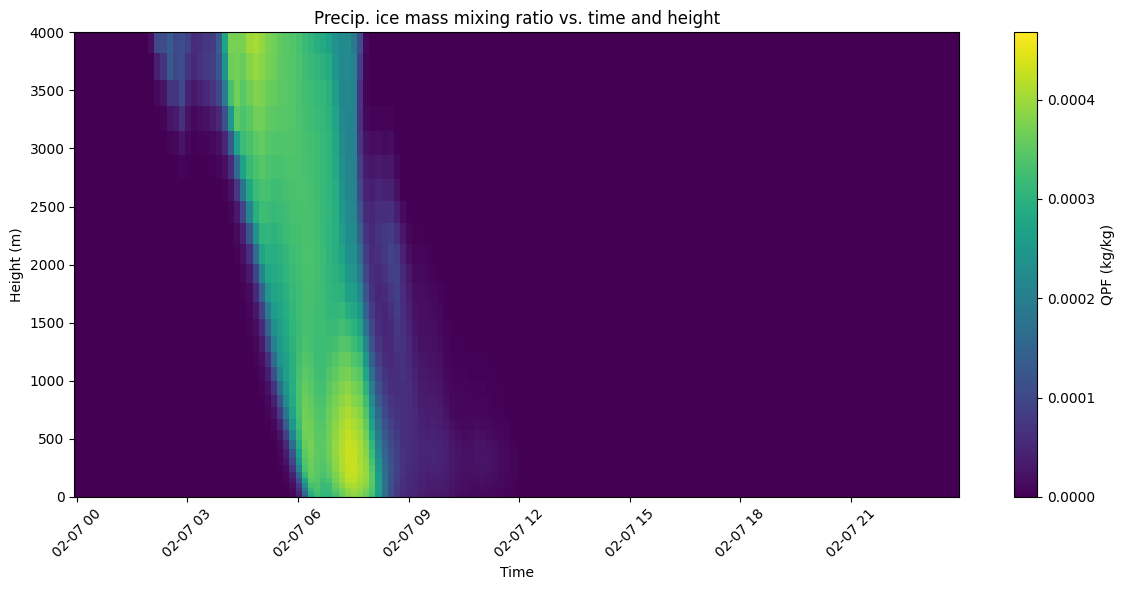

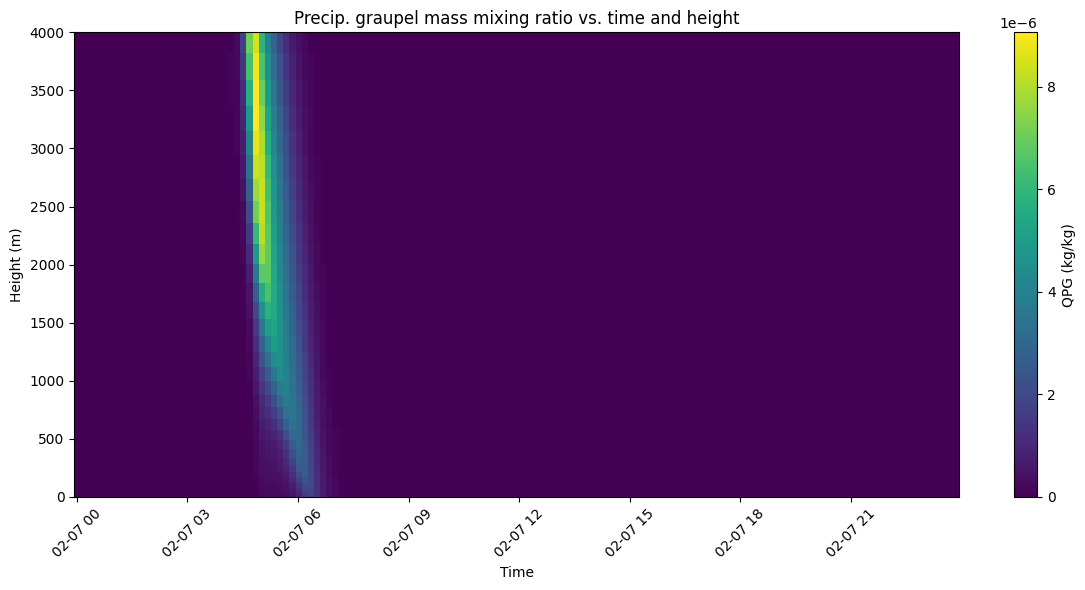

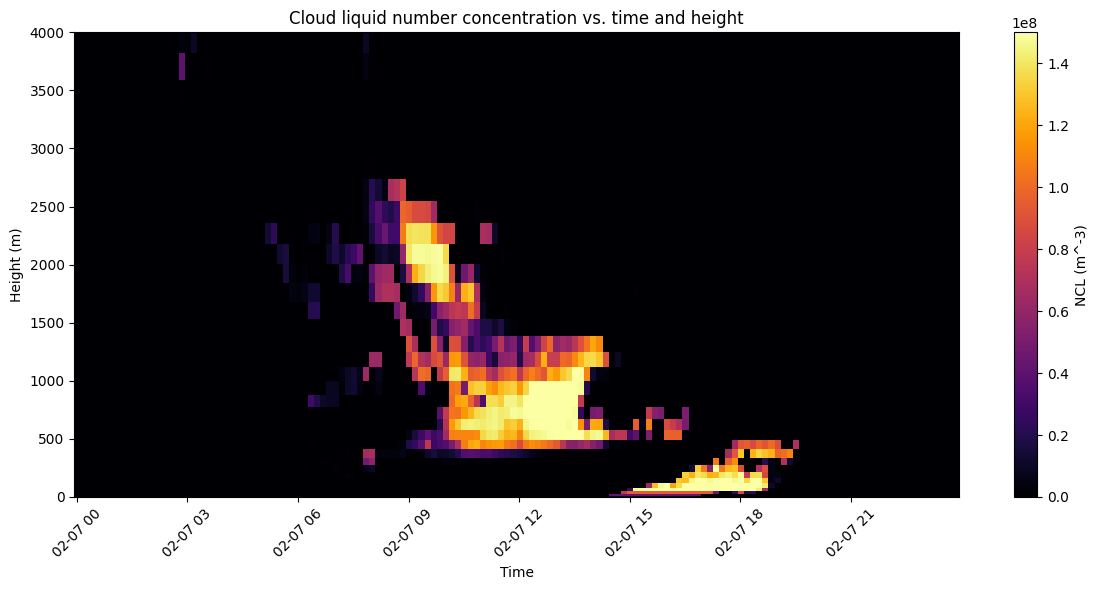

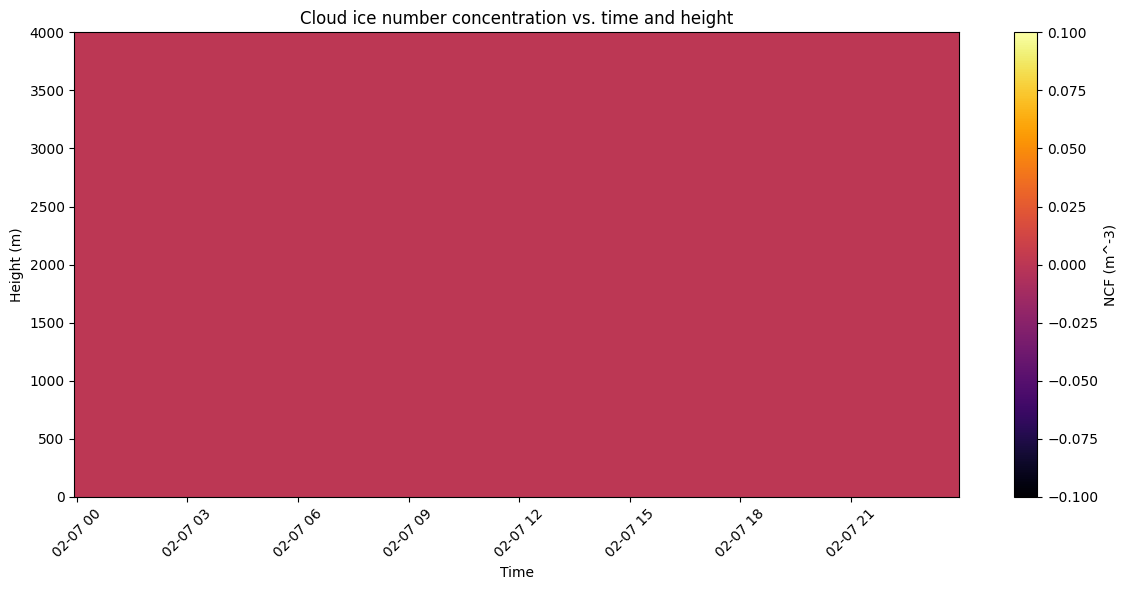

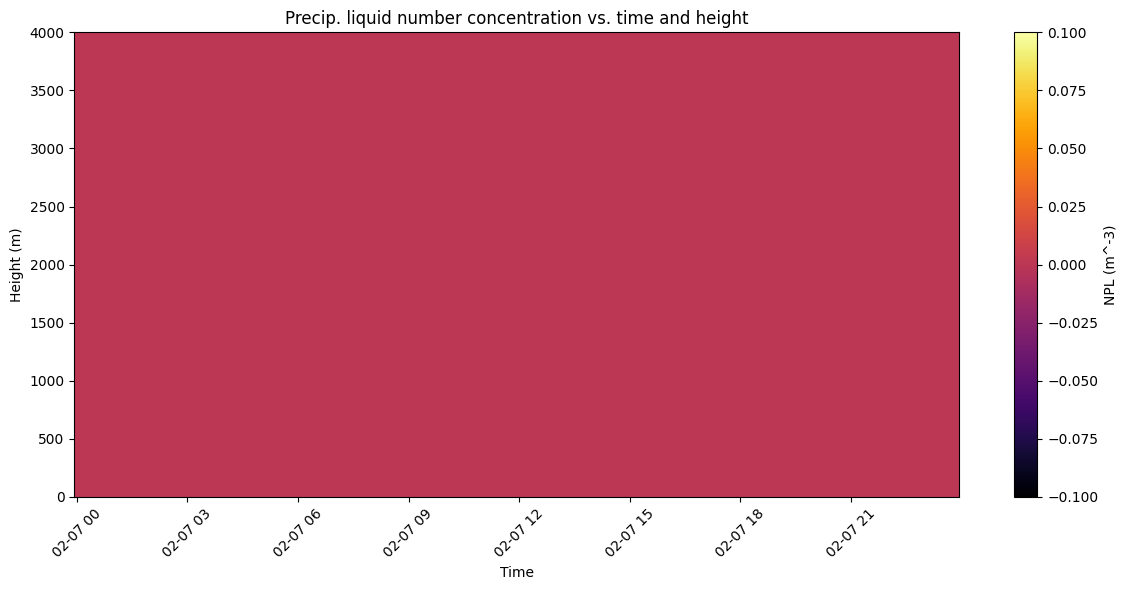

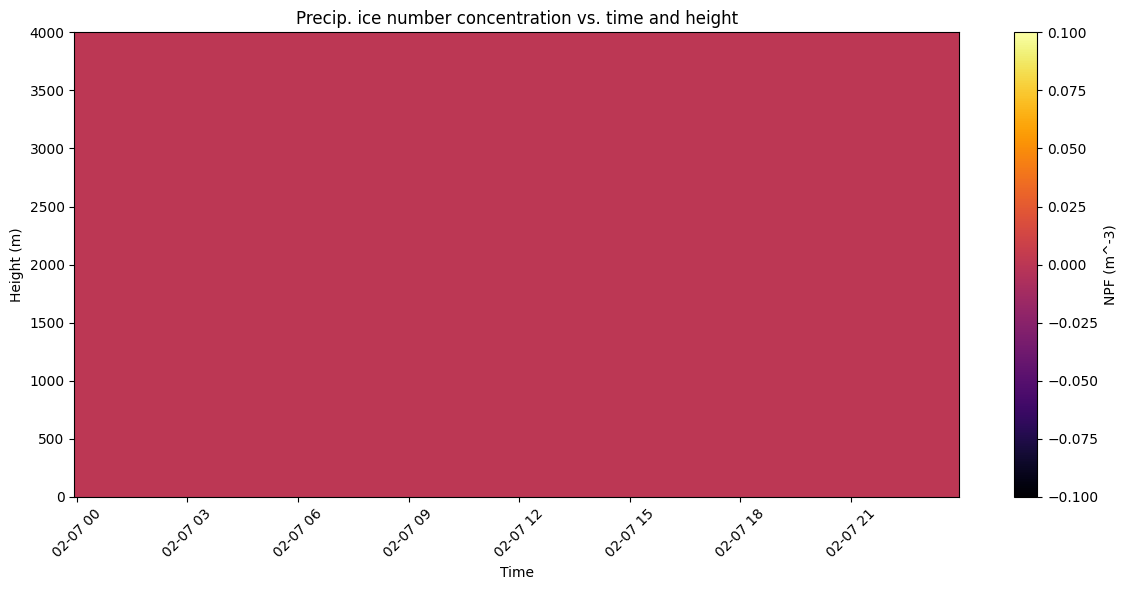

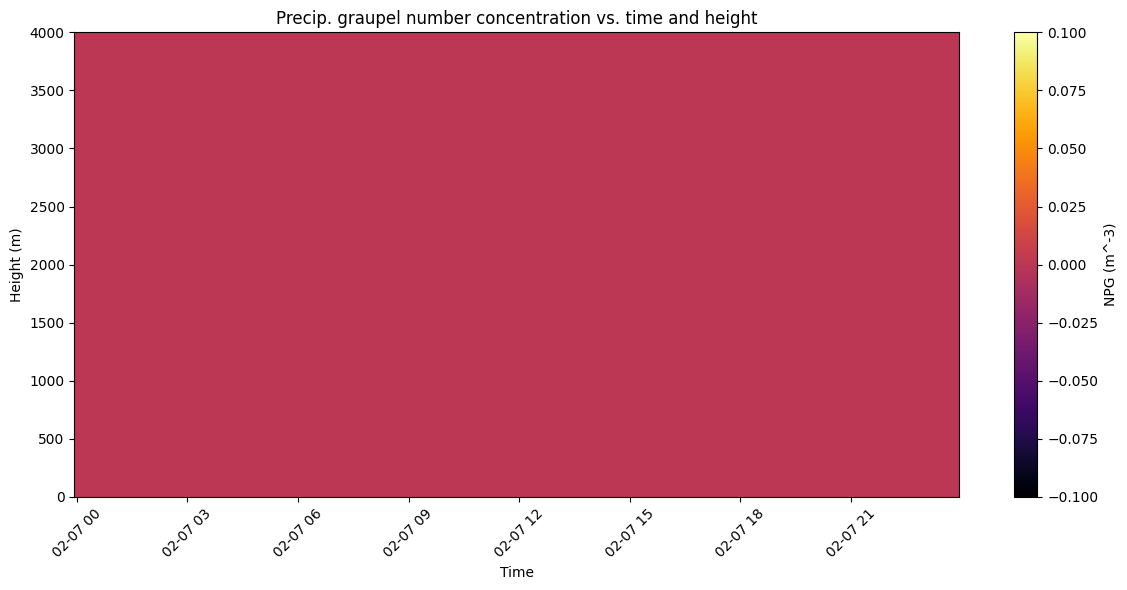

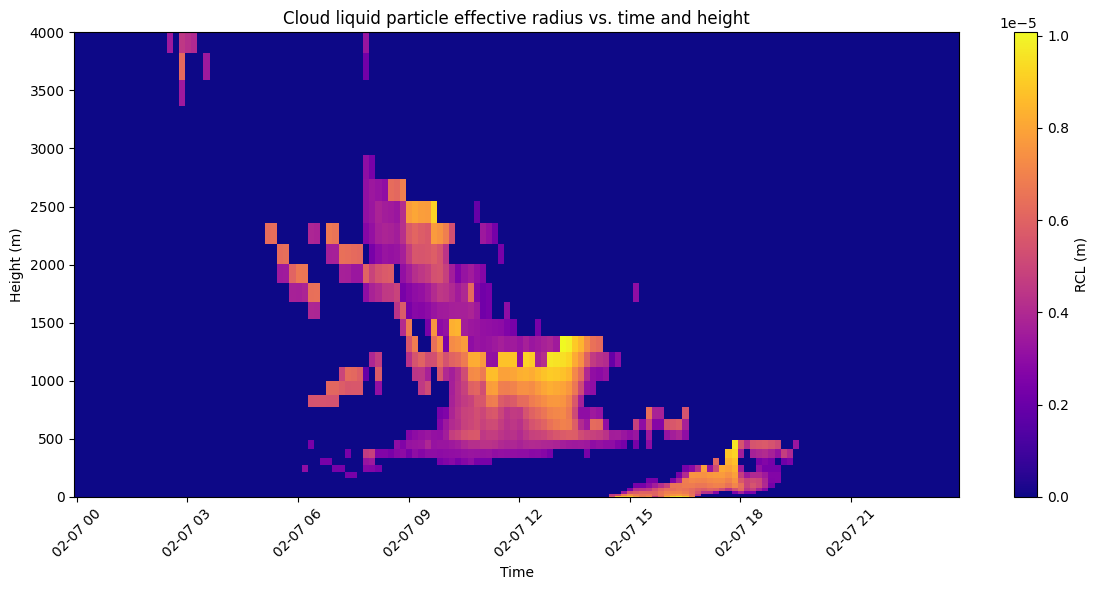

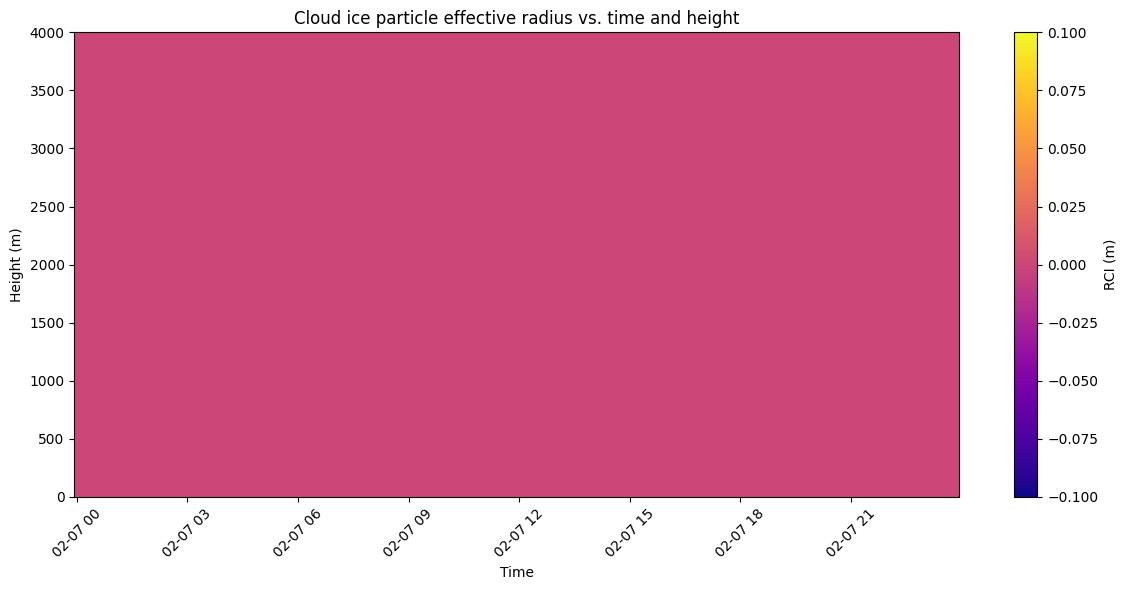

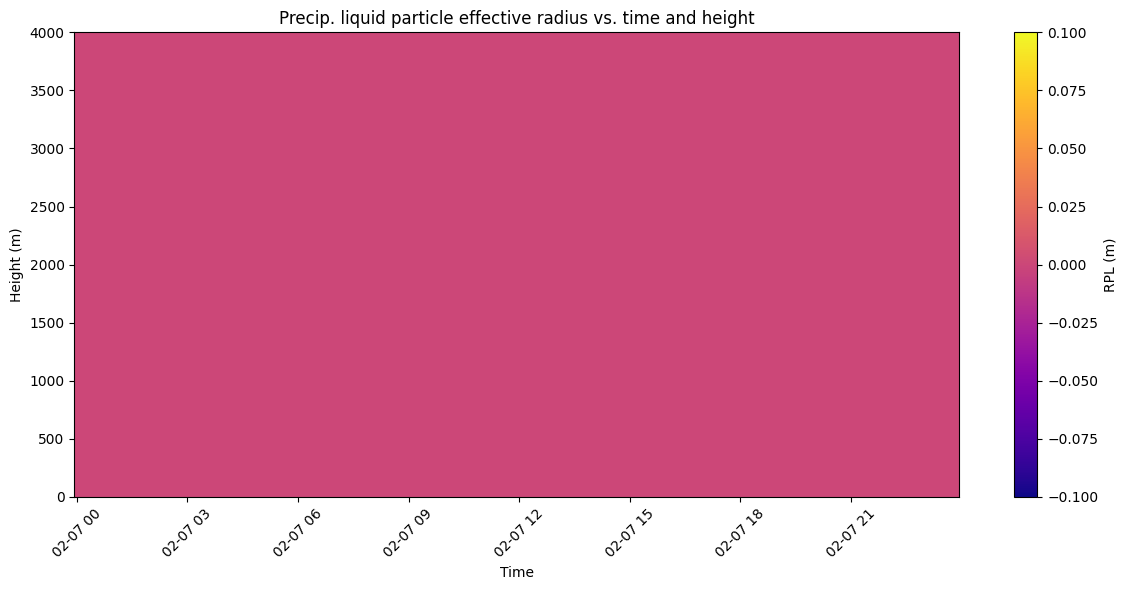

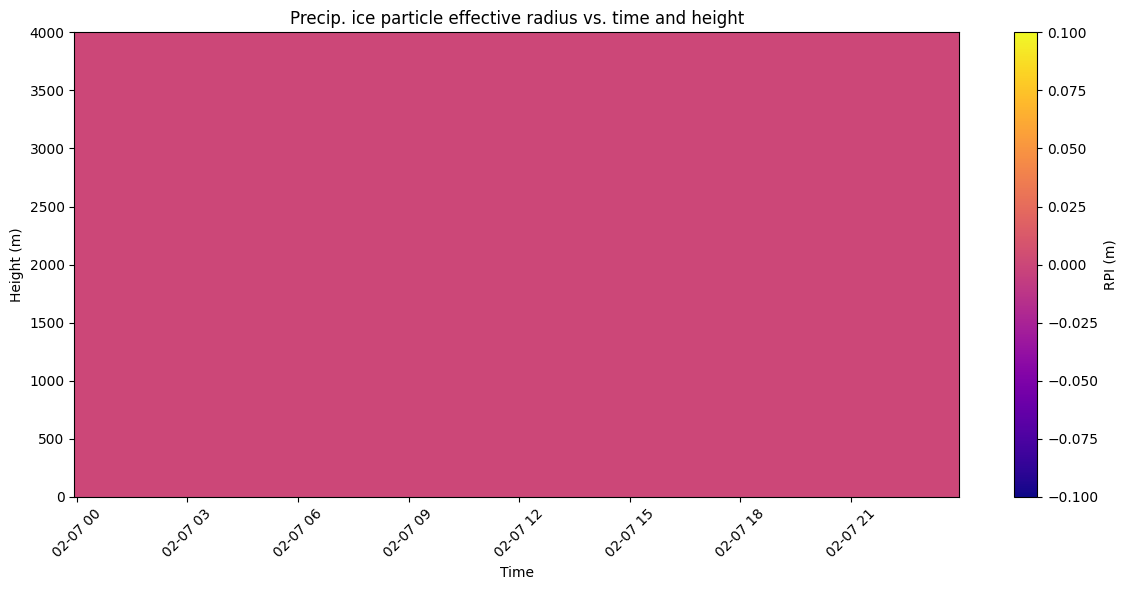

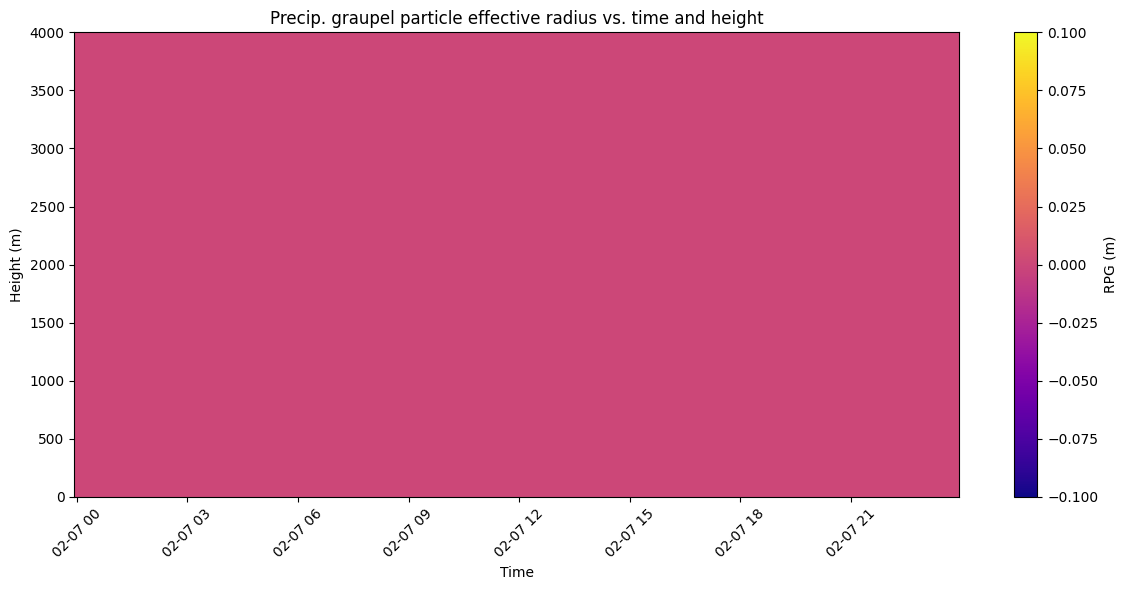

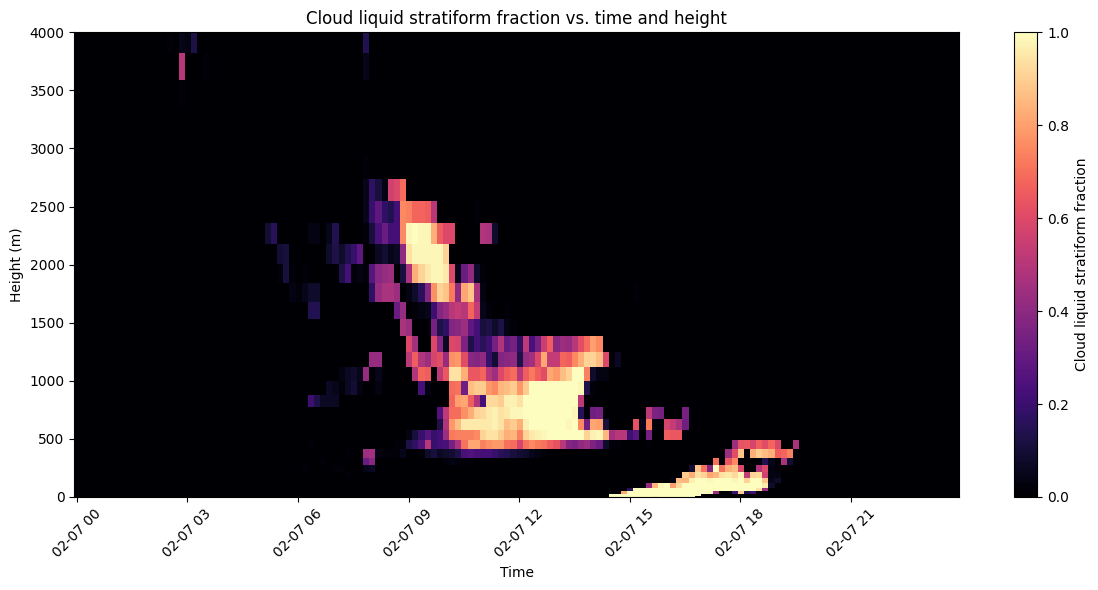

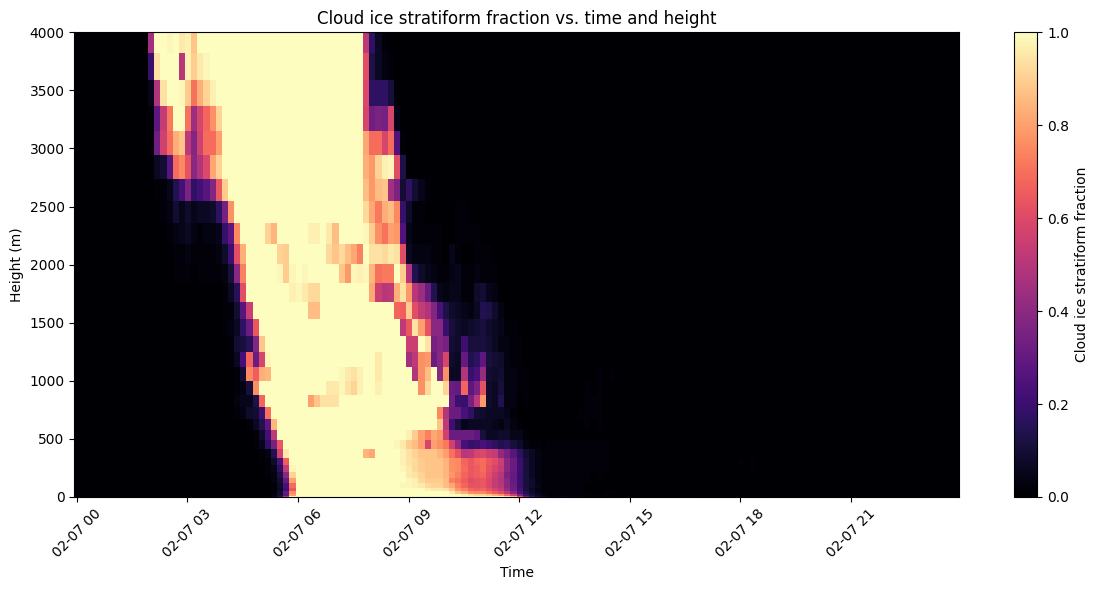

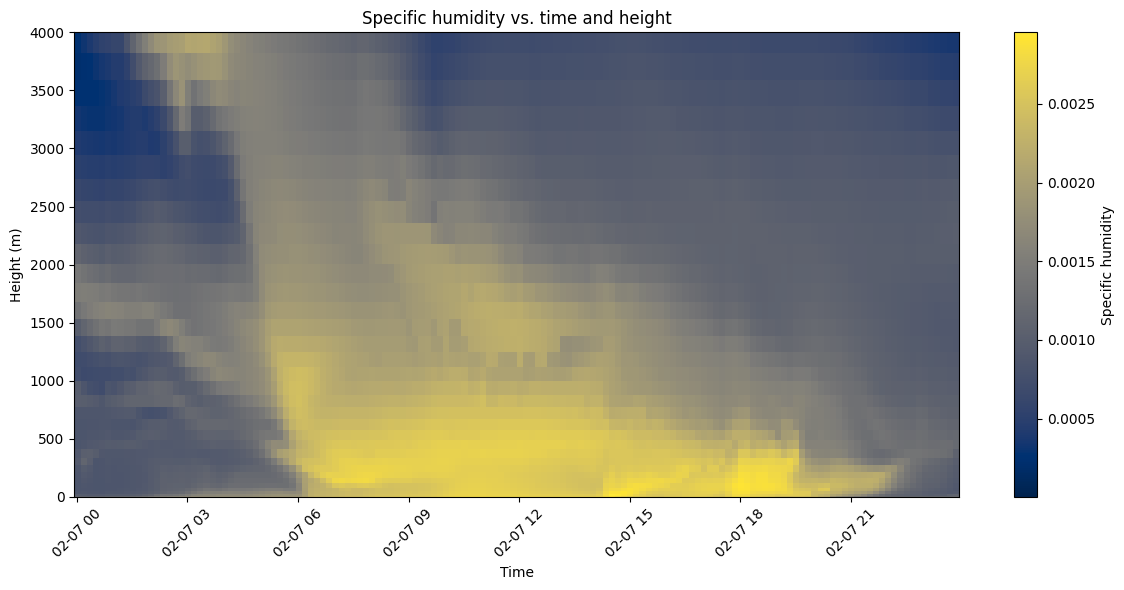

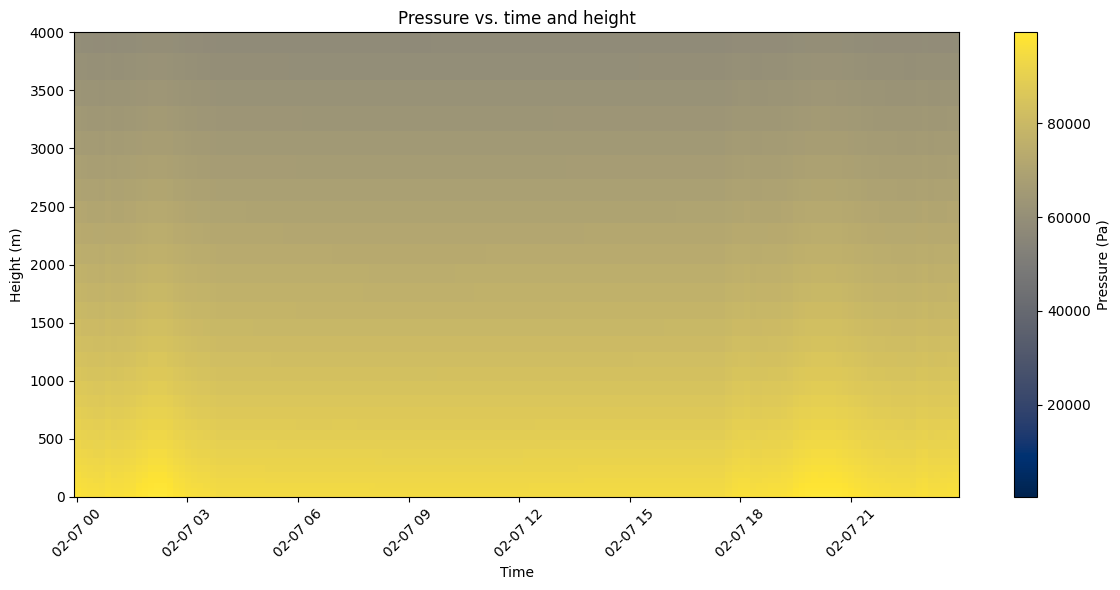

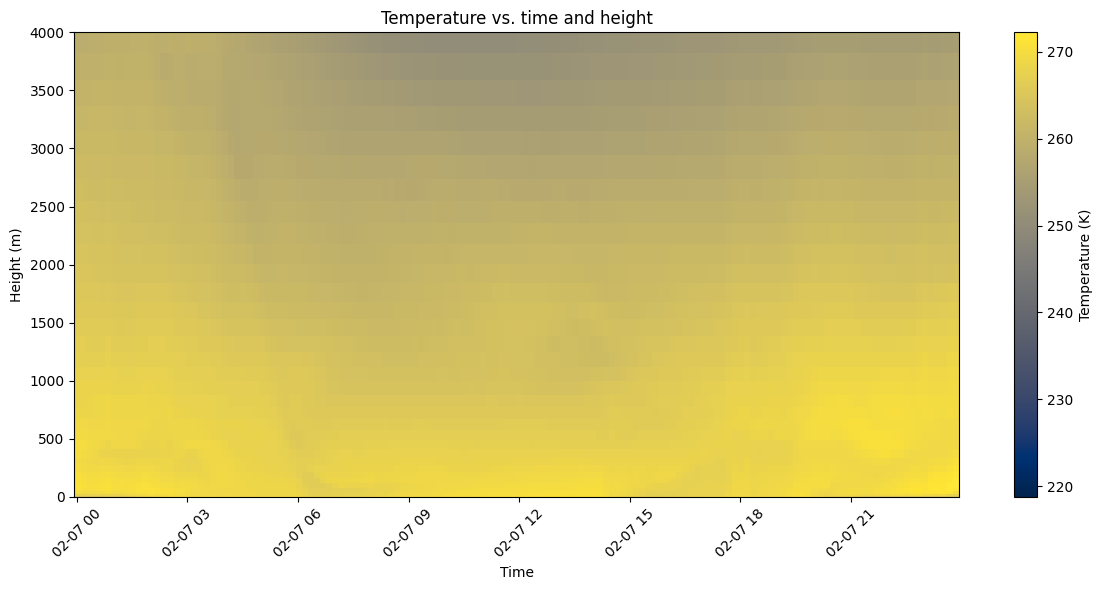

In [45]:
# Save plots of atmospheric properties from UM_reg output

# Save paths for images
plot_path = '/g/data/jk72/ck4840/projects/emc2/figs/um_reg/um_reg_output_subset'

# TEMPORARY TESTING
# daily_UM_reg_list = [daily_UM_reg_list[0]]

# Iterate across the list of daily files, loading each and saving plots of variables
for filepath in daily_UM_reg_list:
    
    # Load the current file
    daily_UM_reg_output = xr.open_dataset(filepath, engine = 'netcdf4')

    # Extract the date from the current file
    current_date = filepath.split('_')[4]
    current_date = current_date.split('.')[0]
    
    # Create a meshgrid for time and height to be used for all plots produced from the current file
    time_mesh, height_mesh = np.meshgrid(daily_UM_reg_output['time'], daily_UM_reg_output['z0_hybrid_height'])

    # QCL
    # Extract the desired variable
    QCL = daily_UM_reg_output['field254']
    # Create the plot with a grey background
    plt.figure(figsize = (12, 6))
    plt.gca().set_facecolor('lightgrey')
    # Create and organise a pcolormesh plot
    pcm = plt.pcolormesh(time_mesh, height_mesh, QCL.T, cmap = 'viridis', shading = 'auto')
    plt.xlabel('Time')
    plt.ylabel('Height (m)')
    plt.colorbar(pcm, label = 'QCL (kg/kg)')
    plt.title('Cloud liquid mass mixing ratio vs. time and height')
    plt.ylim(0, 4000)
    plt.xticks(rotation = 45)
    plt.tight_layout()
    daily_UM_reg_QCL = plt.gcf()
    # Save the plot
    daily_UM_reg_QCL.savefig(f'{plot_path}/UM_reg_QCL_{current_date}', dpi = 200)

    # QCF
    # Extract the desired variable
    QCF = daily_UM_reg_output['field271']
    # Create the plot with a grey background
    plt.figure(figsize = (12, 6))
    plt.gca().set_facecolor('lightgrey')
    # Create and organise a pcolormesh plot
    pcm = plt.pcolormesh(time_mesh, height_mesh, QCF.T, cmap = 'viridis', shading = 'auto')
    plt.xlabel('Time')
    plt.ylabel('Height (m)')
    plt.colorbar(pcm, label = 'QCF (kg/kg)')
    plt.title('Cloud ice mass mixing ratio vs. time and height')
    plt.ylim(0, 4000)
    plt.xticks(rotation = 45)
    plt.tight_layout()
    daily_UM_reg_QCF = plt.gcf()
    # Save the plot
    daily_UM_reg_QCF.savefig(f'{plot_path}/UM_reg_QCF_{current_date}', dpi = 200)

    # QPL
    # Extract the desired variable
    QPL = daily_UM_reg_output['field272']
    # Create the plot with a grey background
    plt.figure(figsize = (12, 6))
    plt.gca().set_facecolor('lightgrey')
    # Create and organise a pcolormesh plot
    pcm = plt.pcolormesh(time_mesh, height_mesh, QPL.T, cmap = 'viridis', shading = 'auto')
    plt.xlabel('Time')
    plt.ylabel('Height (m)')
    plt.colorbar(pcm, label = 'QPL (kg/kg)')
    plt.title('Precip. liquid mass mixing ratio vs. time and height')
    plt.ylim(0, 4000)
    plt.xticks(rotation = 45)
    plt.tight_layout()
    daily_UM_reg_QPL = plt.gcf()
    # Save the plot
    daily_UM_reg_QPL.savefig(f'{plot_path}/UM_reg_QPL_{current_date}', dpi = 200)

    # QPF
    # Extract the desired variable
    QPF = daily_UM_reg_output['field12']
    # Create the plot with a grey background
    plt.figure(figsize = (12, 6))
    plt.gca().set_facecolor('lightgrey')
    # Create and organise a pcolormesh plot
    pcm = plt.pcolormesh(time_mesh, height_mesh, QPF.T, cmap = 'viridis', shading = 'auto')
    plt.xlabel('Time')
    plt.ylabel('Height (m)')
    plt.colorbar(pcm, label = 'QPF (kg/kg)')
    plt.title('Precip. ice mass mixing ratio vs. time and height')
    plt.ylim(0, 4000)
    plt.xticks(rotation = 45)
    plt.tight_layout()
    daily_UM_reg_QPF = plt.gcf()
    # Save the plot
    daily_UM_reg_QPF.savefig(f'{plot_path}/UM_reg_QPF_{current_date}', dpi = 200)

    # QPG
    # Extract the desired variable
    QPG = daily_UM_reg_output['field273']
    # Create the plot with a grey background
    plt.figure(figsize = (12, 6))
    plt.gca().set_facecolor('lightgrey')
    # Create and organise a pcolormesh plot
    pcm = plt.pcolormesh(time_mesh, height_mesh, QPG.T, cmap = 'viridis', shading = 'auto')
    plt.xlabel('Time')
    plt.ylabel('Height (m)')
    plt.colorbar(pcm, label = 'QPG (kg/kg)')
    plt.title('Precip. graupel mass mixing ratio vs. time and height')
    plt.ylim(0, 4000)
    plt.xticks(rotation = 45)
    plt.tight_layout()
    daily_UM_reg_QPG = plt.gcf()
    # Save the plot
    daily_UM_reg_QPG.savefig(f'{plot_path}/UM_reg_QPG_{current_date}', dpi = 200)
    
    # NCL
    # Extract the desired variable
    NCL = daily_UM_reg_output['field75']
    # Create the plot with a grey background
    plt.figure(figsize = (12, 6))
    plt.gca().set_facecolor('lightgrey')
    # Create and organise a pcolormesh plot
    pcm = plt.pcolormesh(time_mesh, height_mesh, NCL.T, cmap = 'inferno', shading = 'auto')
    plt.xlabel('Time')
    plt.ylabel('Height (m)')
    plt.colorbar(pcm, label = 'NCL (m^-3)')
    plt.title('Cloud liquid number concentration vs. time and height')
    plt.ylim(0, 4000)
    plt.xticks(rotation = 45)
    plt.tight_layout()
    daily_UM_reg_NCL = plt.gcf()
    # Save the plot
    daily_UM_reg_NCL.savefig(f'{plot_path}/UM_reg_NCL_{current_date}', dpi = 200)

    # NCF
    # Extract the desired variable
    NCF = daily_UM_reg_output['field78']
    # Create the plot with a grey background
    plt.figure(figsize = (12, 6))
    plt.gca().set_facecolor('lightgrey')
    # Create and organise a pcolormesh plot
    pcm = plt.pcolormesh(time_mesh, height_mesh, NCF.T, cmap = 'inferno', shading = 'auto')
    plt.xlabel('Time')
    plt.ylabel('Height (m)')
    plt.colorbar(pcm, label = 'NCF (m^-3)')
    plt.title('Cloud ice number concentration vs. time and height')
    plt.ylim(0, 4000)
    plt.xticks(rotation = 45)
    plt.tight_layout()
    daily_UM_reg_NCF = plt.gcf()
    # Save the plot
    daily_UM_reg_NCF.savefig(f'{plot_path}/UM_reg_NCF_{current_date}', dpi = 200)

    # NPL
    # Extract the desired variable
    NPL = daily_UM_reg_output['field76']
    # Create the plot with a grey background
    plt.figure(figsize = (12, 6))
    plt.gca().set_facecolor('lightgrey')
    # Create and organise a pcolormesh plot
    pcm = plt.pcolormesh(time_mesh, height_mesh, NPL.T, cmap = 'inferno', shading = 'auto')
    plt.xlabel('Time')
    plt.ylabel('Height (m)')
    plt.colorbar(pcm, label = 'NPL (m^-3)')
    plt.title('Precip. liquid number concentration vs. time and height')
    plt.ylim(0, 4000)
    plt.xticks(rotation = 45)
    plt.tight_layout()
    daily_UM_reg_NPL = plt.gcf()
    # Save the plot
    daily_UM_reg_NPL.savefig(f'{plot_path}/UM_reg_NPL_{current_date}', dpi = 200)

    # NPF
    # Extract the desired variable
    NPF = daily_UM_reg_output['field79']
    # Create the plot with a grey background
    plt.figure(figsize = (12, 6))
    plt.gca().set_facecolor('lightgrey')
    # Create and organise a pcolormesh plot
    pcm = plt.pcolormesh(time_mesh, height_mesh, NPF.T, cmap = 'inferno', shading = 'auto')
    plt.xlabel('Time')
    plt.ylabel('Height (m)')
    plt.colorbar(pcm, label = 'NPF (m^-3)')
    plt.title('Precip. ice number concentration vs. time and height')
    plt.ylim(0, 4000)
    plt.xticks(rotation = 45)
    plt.tight_layout()
    daily_UM_reg_NPF = plt.gcf()
    # Save the plot
    daily_UM_reg_NPF.savefig(f'{plot_path}/UM_reg_NPF_{current_date}', dpi = 200)

    # NPG
    # Extract the desired variable
    NPG = daily_UM_reg_output['field81']
    # Create the plot with a grey background
    plt.figure(figsize = (12, 6))
    plt.gca().set_facecolor('lightgrey')
    # Create and organise a pcolormesh plot
    pcm = plt.pcolormesh(time_mesh, height_mesh, NPG.T, cmap = 'inferno', shading = 'auto')
    plt.xlabel('Time')
    plt.ylabel('Height (m)')
    plt.colorbar(pcm, label = 'NPG (m^-3)')
    plt.title('Precip. graupel number concentration vs. time and height')
    plt.ylim(0, 4000)
    plt.xticks(rotation = 45)
    plt.tight_layout()
    daily_UM_reg_NPG = plt.gcf()
    # Save the plot
    daily_UM_reg_NPG.savefig(f'{plot_path}/UM_reg_NPG_{current_date}', dpi = 200)

    # RCL
    # Extract the desired variable
    RCL = daily_UM_reg_output['re_mccl']
    # Create the plot with a grey background
    plt.figure(figsize = (12, 6))
    plt.gca().set_facecolor('lightgrey')
    # Create and organise a pcolormesh plot
    pcm = plt.pcolormesh(time_mesh, height_mesh, RCL.T, cmap = 'plasma', shading = 'auto')
    plt.xlabel('Time')
    plt.ylabel('Height (m)')
    plt.colorbar(pcm, label = 'RCL (m)')
    plt.title('Cloud liquid particle effective radius vs. time and height')
    plt.ylim(0, 4000)
    plt.xticks(rotation = 45)
    plt.tight_layout()
    daily_UM_reg_RCL = plt.gcf()
    # Save the plot
    daily_UM_reg_RCL.savefig(f'{plot_path}/UM_reg_RCL_{current_date}', dpi = 200)

    # RCI
    # Extract the desired variable
    RCI = daily_UM_reg_output['re_mcci']
    # Create the plot with a grey background
    plt.figure(figsize = (12, 6))
    plt.gca().set_facecolor('lightgrey')
    # Create and organise a pcolormesh plot
    pcm = plt.pcolormesh(time_mesh, height_mesh, RCI.T, cmap = 'plasma', shading = 'auto')
    plt.xlabel('Time')
    plt.ylabel('Height (m)')
    plt.colorbar(pcm, label = 'RCI (m)')
    plt.title('Cloud ice particle effective radius vs. time and height')
    plt.ylim(0, 4000)
    plt.xticks(rotation = 45)
    plt.tight_layout()
    daily_UM_reg_RCI = plt.gcf()
    # Save the plot
    daily_UM_reg_RCI.savefig(f'{plot_path}/UM_reg_RCI_{current_date}', dpi = 200)

    # RPL
    # Extract the desired variable
    RPL = daily_UM_reg_output['re_mcpl']
    # Create the plot with a grey background
    plt.figure(figsize = (12, 6))
    plt.gca().set_facecolor('lightgrey')
    # Create and organise a pcolormesh plot
    pcm = plt.pcolormesh(time_mesh, height_mesh, RPL.T, cmap = 'plasma', shading = 'auto')
    plt.xlabel('Time')
    plt.ylabel('Height (m)')
    plt.colorbar(pcm, label = 'RPL (m)')
    plt.title('Precip. liquid particle effective radius vs. time and height')
    plt.ylim(0, 4000)
    plt.xticks(rotation = 45)
    plt.tight_layout()
    daily_UM_reg_RPL = plt.gcf()
    # Save the plot
    daily_UM_reg_RPL.savefig(f'{plot_path}/UM_reg_RPL_{current_date}', dpi = 200)

    # RPI
    # Extract the desired variable
    RPI = daily_UM_reg_output['re_mcpi']
    # Create the plot with a grey background
    plt.figure(figsize = (12, 6))
    plt.gca().set_facecolor('lightgrey')
    # Create and organise a pcolormesh plot
    pcm = plt.pcolormesh(time_mesh, height_mesh, RPI.T, cmap = 'plasma', shading = 'auto')
    plt.xlabel('Time')
    plt.ylabel('Height (m)')
    plt.colorbar(pcm, label = 'RPI (m)')
    plt.title('Precip. ice particle effective radius vs. time and height')
    plt.ylim(0, 4000)
    plt.xticks(rotation = 45)
    plt.tight_layout()
    daily_UM_reg_RPI = plt.gcf()
    # Save the plot
    daily_UM_reg_RPI.savefig(f'{plot_path}/UM_reg_RPI_{current_date}', dpi = 200)

    # RPG
    # Extract the desired variable
    RPG = daily_UM_reg_output['re_mcpg']
    # Create the plot with a grey background
    plt.figure(figsize = (12, 6))
    plt.gca().set_facecolor('lightgrey')
    # Create and organise a pcolormesh plot
    pcm = plt.pcolormesh(time_mesh, height_mesh, RPG.T, cmap = 'plasma', shading = 'auto')
    plt.xlabel('Time')
    plt.ylabel('Height (m)')
    plt.colorbar(pcm, label = 'RPG (m)')
    plt.title('Precip. graupel particle effective radius vs. time and height')
    plt.ylim(0, 4000)
    plt.xticks(rotation = 45)
    plt.tight_layout()
    daily_UM_reg_RPG = plt.gcf()
    # Save the plot
    daily_UM_reg_RPG.savefig(f'{plot_path}/UM_reg_RPG_{current_date}', dpi = 200)

    # Cloud liquid stratiform fraction
    # Extract the desired variable
    cl_strat_frac = daily_UM_reg_output['field267']
    # Create the plot with a grey background
    plt.figure(figsize = (12, 6))
    plt.gca().set_facecolor('lightgrey')
    # Create and organise a pcolormesh plot
    pcm = plt.pcolormesh(time_mesh, height_mesh, cl_strat_frac.T, cmap = 'magma', shading = 'auto')
    plt.xlabel('Time')
    plt.ylabel('Height (m)')
    plt.colorbar(pcm, label = 'Cloud liquid stratiform fraction')
    plt.title('Cloud liquid stratiform fraction vs. time and height')
    plt.ylim(0, 4000)
    plt.xticks(rotation = 45)
    plt.tight_layout()
    daily_UM_reg_cl_strat_frac = plt.gcf()
    # Save the plot
    daily_UM_reg_cl_strat_frac.savefig(f'{plot_path}/UM_reg_cl_strat_frac_{current_date}', dpi = 200)

    # Cloud ice stratiform fraction
    # Extract the desired variable
    ci_strat_frac = daily_UM_reg_output['field268']
    # Create the plot with a grey background
    plt.figure(figsize = (12, 6))
    plt.gca().set_facecolor('lightgrey')
    # Create and organise a pcolormesh plot
    pcm = plt.pcolormesh(time_mesh, height_mesh, ci_strat_frac.T, cmap = 'magma', shading = 'auto')
    plt.xlabel('Time')
    plt.ylabel('Height (m)')
    plt.colorbar(pcm, label = 'Cloud ice stratiform fraction')
    plt.title('Cloud ice stratiform fraction vs. time and height')
    plt.ylim(0, 4000)
    plt.xticks(rotation = 45)
    plt.tight_layout()
    daily_UM_reg_ci_strat_frac = plt.gcf()
    # Save the plot
    daily_UM_reg_ci_strat_frac.savefig(f'{plot_path}/UM_reg_ci_strat_frac_{current_date}', dpi = 200)

    # Water vapour mixing ratio
    # Extract the desired variable
    hus = daily_UM_reg_output['hus']
    # Create the plot with a grey background
    plt.figure(figsize = (12, 6))
    plt.gca().set_facecolor('lightgrey')
    # Create and organise a pcolormesh plot
    pcm = plt.pcolormesh(time_mesh, height_mesh, hus.T, cmap = 'cividis', shading = 'auto')
    plt.xlabel('Time')
    plt.ylabel('Height (m)')
    plt.colorbar(pcm, label = 'Specific humidity')
    plt.title('Specific humidity vs. time and height')
    plt.ylim(0, 4000)
    plt.xticks(rotation = 45)
    plt.tight_layout()
    daily_UM_reg_hus = plt.gcf()
    # Save the plot
    daily_UM_reg_hus.savefig(f'{plot_path}/UM_reg_hus_{current_date}', dpi = 200)

    # Pressure
    # Extract the desired variable
    pressure = daily_UM_reg_output['field408']
    # Create the plot with a grey background
    plt.figure(figsize = (12, 6))
    plt.gca().set_facecolor('lightgrey')
    # Create and organise a pcolormesh plot
    pcm = plt.pcolormesh(time_mesh, height_mesh, pressure.T, cmap = 'cividis', shading = 'auto')
    plt.xlabel('Time')
    plt.ylabel('Height (m)')
    plt.colorbar(pcm, label = 'Pressure (Pa)')
    plt.title('Pressure vs. time and height')
    plt.ylim(0, 4000)
    plt.xticks(rotation = 45)
    plt.tight_layout()
    daily_UM_reg_pressure = plt.gcf()
    # Save the plot
    daily_UM_reg_pressure.savefig(f'{plot_path}/UM_reg_pressure_{current_date}', dpi = 200)

    # Temperature
    # Extract the desired variable
    ta = daily_UM_reg_output['ta']
    # Create the plot with a grey background
    plt.figure(figsize = (12, 6))
    plt.gca().set_facecolor('lightgrey')
    # Create and organise a pcolormesh plot
    pcm = plt.pcolormesh(time_mesh, height_mesh, ta.T, cmap = 'cividis', shading = 'auto')
    plt.xlabel('Time')
    plt.ylabel('Height (m)')
    plt.colorbar(pcm, label = 'Temperature (K)')
    plt.title('Temperature vs. time and height')
    plt.ylim(0, 4000)
    plt.xticks(rotation = 45)
    plt.tight_layout()
    daily_UM_reg_ta = plt.gcf()
    # Save the plot
    daily_UM_reg_ta.savefig(f'{plot_path}/UM_reg_ta_{current_date}', dpi = 200)
print('Finished plotting')